# Diplomatura en ciencia de datos, aprendizaje automático y sus aplicaciones - Edición 2023 - FAMAF (UNC)

## Mentoría 16 - ¿Cómo identificar fuga de ventas? Inteligencia artificial aplicada al sector comercial.

### Explorando Patrones de Datos a través de Clustering (TP3) - Parte 1: Preparación de los datos

**Integrantes:**
- Canalis, Patricio.
- Chevallier-Boutell, Ignacio José.
- Villarroel Torrez, Daniel.

**Mentores:**
- Gonzalez, Lucía
- Lahoz, Nahuel

---
## Librerías

In [1]:
# Para que las funciones se actualicen sin tener que refrescar el kernel
%load_ext autoreload
%autoreload 2

# Funciones de visualización y curación
import pandas as pd
import json
from os.path import exists
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import linregress as LR
from scipy.stats import skew, kurtosis, skewtest, kurtosistest

# Funciones de clustering
from sklearn.cluster import KMeans, MeanShift
from sklearn import manifold, preprocessing, decomposition

# Funciones propias
from utils_limpieza import * 

# Preferencias
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows',150)
sns.set_context('talk')
sns.set_theme(style='white')

---
# Preparación de Datos <span style="color:magenta">**(Paso 1)**</span>

Se repiten los pasos de curación realizados en la entrega anterior. A tener en cuenta:
* Algunos pasos que se hacían por separado, ahora se hacen todos juntos. 
* No se simplifica la variable `Deposito`, ya que se descarta desde el principio.
* lo del 10K
* No se hace el cálculo de promedio y varianza de los vectores finales.

1. **Cargamos el dataset crudo.**

In [2]:
path = '../data/raw/tp2_muestra_diplodatos_ventas_omega_modelo_2023.csv'
ventas_raw = pd.read_csv(path)

/tmp/ipykernel_249693/1602723889.py:2: DtypeWarning: Columns (10,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  ventas_raw = pd.read_csv(path)


2. **Eliminamos las siguientes variables:**
    * `INSCRIPCION`.
    * `CATEGORIA`.
    * `DESCRIPCION_CATEGORIA`.
    * `CATEGORIA (Ajustado)`.
    * `NOMBRE`.
    * `CM04`.
    * `DESC_TRATAMIENTO_FISCAL`.
    * `TRATAMIENTO_DIFERNCIAL`.
    * `TRATAMIENTO_FISCAL`.
    * `PORCENTAJE_COMISION_EMPRESA`.
    * `DEPOSITO`.

In [3]:
ventas = limpiar_basic(ventas_raw, cols_drop=['INSCRIPCION', 'CATEGORIA', 'DESCRIPCION_CATEGORIA', 'CATEGORIA (Ajustado)', 
                                              'NOMBRE', 'CM04', 'DEPOSITO', 'DESC_TRATAMIENTO_FISCAL', 'TRATAMIENTO_DIFERNCIAL', 
                                              'TRATAMIENTO_FISCAL', 'PORCENTAJE_COMISION_EMPRESA'])

3. **Renombramos como `Otros` las subcategorías que no tengan al menos 1 `MODELO` = 1.**

In [4]:
ventas = renombrar_elementos(ventas, columna='SUB-CATEGORIA', 
                                     fill_otros='Otros')

4. **Eliminamos los registros que contienen las siguientes subcategorías:**
    * `Otros`.
    * `Instalación, Mantenimiento, Reparación, etc de productos varios` (a.k.a. `Mantenimiento`).

In [5]:
ventas = ventas[ventas['SUB-CATEGORIA'] != 'Otros'].copy()
ventas = ventas[ventas['SUB-CATEGORIA'] != 'Instalación, Mantenimiento, Reparación, etc de productos varios'].copy()

5. **Creamos la variable `Fecha` y eliminamos las variables `MES` y `AÑO`.**

In [6]:
ventas["Fecha"] = pd.to_datetime(ventas['MES'].astype(str) + '-' + ventas['AÑO'].astype(str), format='%m-%Y')
ventas = limpiar_basic(ventas, cols_drop=['MES', 'AÑO'])

6. **Anonimizamos la variable sensible `ID_VENDEDOR`.**

In [7]:
ventas, _ = anonimizar(ventas, 'ID_VENDEDOR')

Actualizando variable ID_VENDEDOR
	 Progreso del 0%
	 Progreso del 10%
	 Progreso del 20%
	 Progreso del 30%
	 Progreso del 40%
	 Progreso del 50%
	 Progreso del 60%
	 Progreso del 70%
	 Progreso del 80%
	 Progreso del 90%
	 Progreso del 100%


7. **Simplificamos el nombre de las variables.**

In [8]:
with open("../references/tp2_column_dict.json") as column_dict_json:
    column_dict = json.load(column_dict_json)

ventas.rename(columns = column_dict, inplace = True)

8. **Simplificamos las categorías en `Subrubro`.**

In [9]:
with open("../references/tp2_subrubro_dict.json") as subrubro_dict_json:
    subrubro_dict = json.load(subrubro_dict_json)

ventas['Subrubro'] = ventas['Subrubro'].replace(subrubro_dict)

9. <span style="color:magenta">**(Este paso es nuevo)**</span> **Remplazamos con $0 a todas las ventas y comisiones que estén en el rango desde -$10.000 hasta $10.000.**

In [10]:
ventas[['Ventas', 'Comision']].describe()

Ventas      Comision
count  3.706220e+05  3.706220e+05
mean   7.573558e+06  3.218162e+05
std    4.253813e+07  1.897839e+06
min   -1.052917e+08 -4.402579e+06
25%    0.000000e+00  0.000000e+00
50%    1.775391e+05  7.138745e+03
75%    3.705039e+06  1.539599e+05
max    4.876872e+09  2.438436e+08

Se trata de 152657 registros. De los cuales 143623 ya son idénticamente nulos.
Es decir que tenemos 9034 registros que no son nulos dentro de este rango ($-10000, $10000).
De los valores no nulos, hay 8704 positivos y 330 negativos.


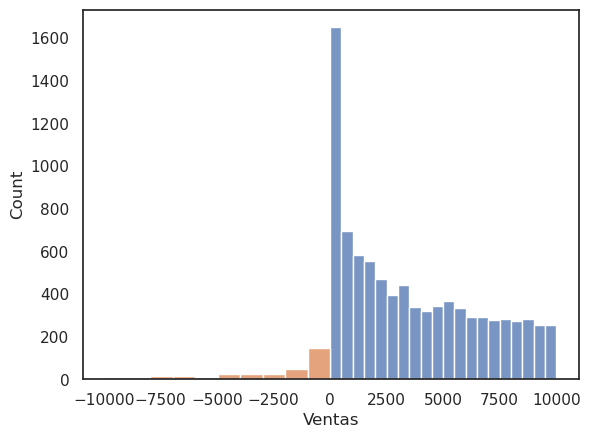

In [11]:
cut = 10000
a = ventas[(ventas['Ventas'] < cut) & (ventas['Ventas'] > - cut)].copy()
b = a[a['Ventas']==0].copy()
print(f'Se trata de {a.shape[0]} registros. De los cuales {b.shape[0]} ya son idénticamente nulos.')
print(f'Es decir que tenemos {a.shape[0] - b.shape[0]} registros que no son nulos dentro de este rango (${-cut}, ${cut}).')
c = a[a['Ventas'] != 0].copy()
cpos = c[c['Ventas']>0]
cneg = c[c['Ventas']<0]
print(f'De los valores no nulos, hay {cpos.shape[0]} positivos y {cneg.shape[0]} negativos.')

sns.histplot(cpos['Ventas'])
sns.histplot(cneg['Ventas'])
plt.show()

In [12]:
# Imputamos las ventas
ven = ventas['Ventas'].copy()
ven.mask((ven < cut) & (ven > - cut), inplace=True)
ven.fillna(0, inplace=True)
ventas['Ventas'] = ven

# Imputamos las comisiones
ven = ventas['Comision'].copy()
ven.mask((ven < cut) & (ven > - cut), inplace=True)
ven.fillna(0, inplace=True)
ventas['Comision'] = ven

10. **Eliminamos el efecto de la inflación.**

In [14]:
precios_path = "../data/external/tp2_IPC_Indec.csv"

if exists(precios_path):
    print('Este archivo ya existe.')
else:
    print('Este archivo no existe: ¡Vamos a crearlo!')
    url = "https://www.indec.gob.ar/ftp/cuadros/economia/sh_ipc_06_23.xls"
    df = pd.read_excel(url, sheet_name="Índices IPC Cobertura Nacional", header=None, usecols="B:CA", skiprows=[0, 1, 2, 3, 4, 6, 7, 8], nrows=2)
    df = df.transpose()
    df.columns = ["Fecha", "INDICE"]
    df["Fecha"] = pd.to_datetime(df["Fecha"])
    df.to_csv(precios_path, index=False)

precios = pd.read_csv(precios_path)
precios.columns = ["Fecha", "INDICE"]

# Hay que asegurar que la variable clave tenga el mismo tipo en los dos dataframes
precios["Fecha"] = pd.to_datetime(precios["Fecha"])

ventas = ventas.merge(precios[["Fecha", "INDICE"]], on="Fecha", how="left")

Este archivo ya existe.


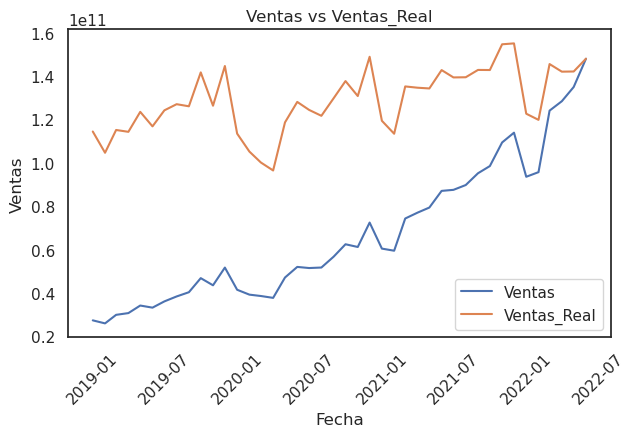

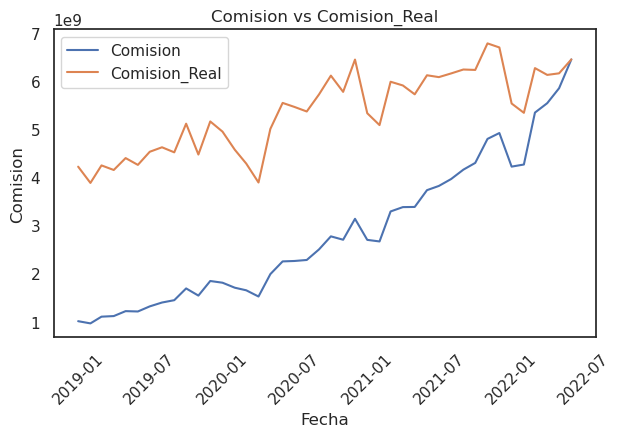

In [15]:
# Hacemos la imputación
indexar(ventas, 'Ventas')
indexar(ventas, 'Comision')

In [16]:
# Se descartan las variables que no se usan
ventas = limpiar_basic(ventas, cols_drop=['Ventas', 'Comision', 'INDICE'])

# Se renombran las variables
ventas.rename(columns = {'Ventas_Real': 'Ventas', 
                         'Comision_Real': 'Comision'}, inplace = True)

# Se reacomodan las columnas
ventas = ventas[['ID', 'Omega', 'Subrubro', 'Fecha', 'Ventas', 'Comision', 'Modelo']]

ventas = ventas.sort_values(['Fecha', 'Ventas']).reset_index(drop=True)

11. **Pasar de ventas a vendedores**

    Para cada combinación posible de `Subrubro`, `ID` y `Fecha`, vamos a:
    * Sumar todos los valores de `Ventas`.
    * Sumar todos los valores de `Comision`.
    * Mantener los valores de `Modelo` y de `Omega`.

    Al hacer esto, se agregan en una única fila todas las observaciones que pertenezcan a un mismo vendedor en una dada fecha bajo un cierto subrubro.

In [17]:
agregado = ventas.groupby(['Subrubro', 'ID', 'Fecha']).agg({
    'Ventas': 'sum',
    'Comision': 'sum',
    'Modelo': 'min',
    'Omega': 'min'
}).reset_index()

12. **Se eliminan los registros asociados a vendedores que tienen siempre `Ventas` nulas dentro de un mismo `Subrubro`.**

In [18]:
agregado_no_nulo = agregado.groupby(['Subrubro', 'ID']).filter(lambda x: (x['Ventas'] != 0).any()).copy()

13. **Deberíamos tener 42 observaciones por par `ID`/`Subrubro`. Imputamos los meses faltantes con valor 0 en `Ventas` y en `Comision`.**

In [19]:
# Distinguimos los valores originales de los imputados (`Dato_original`).
agregado_no_nulo['Dato_original'] = 1

# Contar las observaciones por combinación de ID y Subrubro
conteo_combinaciones = agregado_no_nulo.groupby(['Subrubro', 'ID']).size().reset_index(name='Conteo')

# Filtrar las combinaciones con menos de 42 observaciones
combinaciones_faltantes = conteo_combinaciones[conteo_combinaciones['Conteo'] < 42]

# Lista para almacenar las observaciones faltantes
observaciones_faltantes = []

# Iterar sobre las combinaciones faltantes
for _, combinacion in combinaciones_faltantes.iterrows():
    id_val = combinacion['ID']
    subrubro_val = combinacion['Subrubro']
    
    # Obtener fechas existentes y fechas faltantes
    fechas_existentes = agregado_no_nulo[(agregado_no_nulo['ID'] == id_val) & (agregado_no_nulo['Subrubro'] == subrubro_val)]['Fecha']
    fechas_faltantes = set(agregado_no_nulo['Fecha'].unique()) - set(fechas_existentes)
    
    # Agregar observaciones faltantes al DataFrame
    for fecha_faltante in fechas_faltantes:
        observacion = {
            'ID': id_val,
            'Subrubro': subrubro_val,
            'Fecha': fecha_faltante,
            'Ventas': 0,
            'Comision': 0,
        }
        observaciones_faltantes.append(observacion)

# Crear DataFrame con las observaciones faltantes
df_observaciones_faltantes = pd.DataFrame(observaciones_faltantes)

# Agregar observaciones faltantes al DataFrame agregado_no_nulo
agregado_limpio = pd.concat([agregado_no_nulo, df_observaciones_faltantes], ignore_index=True)

# Imputo los valores Omega y Modelo asociados a los nuevos meses adicionados. Es más eficiente agregarlo en una celda aparte y no en el for (antes demoraba 9 minutos, ahora menos de 1).
agregado_limpio['Omega'] = agregado_limpio.groupby(['ID', 'Subrubro'])['Omega'].transform('max')
agregado_limpio['Modelo'] = agregado_limpio.groupby(['ID', 'Subrubro'])['Modelo'].transform('max')

# Relleno los valores nulos de Dato_original con 0.
agregado_limpio['Dato_original'] = agregado_limpio['Dato_original'].fillna(0)

# Convertir las columnas 'Omega', 'Modelo' y 'Dato_original' a tipo int64
agregado_limpio['Omega'] = agregado_limpio['Omega'].astype('int64')
agregado_limpio['Modelo'] = agregado_limpio['Modelo'].astype('int64')
agregado_limpio['Dato_original'] = agregado_limpio['Dato_original'].astype('int64')

promedio_observaciones = agregado_limpio.groupby(['Subrubro', 'ID']).size().mean()

# Mostrar el promedio de observaciones por combinación de ID y Subrubro
print(f'Cade vendedor tiene asociados {promedio_observaciones} meses diferentes.')

Cade vendedor tiene asociados 42.0 meses diferentes.


14. **Ordenar luego de todo lo que se hizo.**

In [20]:
# Dejar que primero esté Fecha. Sirve para el pivoteo que hacemos después.
registros_vendedores_abs = agregado_limpio.sort_values(['Fecha', 'Subrubro', 'ID']).reset_index(drop=True)

# Gurdamos el dataset
registros_vendedores_abs.to_csv('../data/interim/tp3_registros_vendedores_abs.csv', index=False)

15. **Reemplazar ceros por NaN**

    Queremos hacer el cálculo de la variación porcentual. Con el dataset como está actualmente (presencia de ceros), pueden generarse resultados que tienden a infinito. Para superar esta situación, se reemplazan todos los ceros por NaN.

In [21]:
registros_vendedores_rel = registros_vendedores_abs.copy()
registros_vendedores_rel[['Ventas', 'Comision']] = registros_vendedores_rel[['Ventas', 'Comision']].replace({0:np.NaN})

16. **Cálculo de cambios porcentuales.**

    **NOTA:** La función pct_change devuelve en el rango normal, no en el porcentual

In [22]:
crear_diferencia_porcentual(registros_vendedores_rel, 'Ventas', 12)
crear_diferencia_porcentual(registros_vendedores_rel, 'Comision', 12)
crear_diferencia_porcentual(registros_vendedores_rel, 'Ventas', 4)
crear_diferencia_porcentual(registros_vendedores_rel, 'Comision', 4)

17. **Pivotear los datos.**

In [23]:
pivotear = registros_vendedores_rel.copy()

# Extraer el mes y el año de la columna "Fecha"
pivotear["Fecha"] = pd.to_datetime(pivotear["Fecha"])
pivotear["Month"] = pivotear["Fecha"].dt.month
pivotear["Year"] = pivotear["Fecha"].dt.year

# Convertir "Month" a string con formato de dos cifras
pivotear["Month"] = pivotear["Month"].apply(lambda x: str(x).zfill(2))

# Convertir "Year" a string y quedarse con los últimos 2 dígitos
pivotear["Year"] = pivotear["Year"].apply(lambda x: str(x)[-2:])

# Crear la variable "Fecha2" que concatena "Year" y "Month"
pivotear["Fecha2"] = pivotear["Year"] + pivotear["Month"]

# Eliminar columnas
pivotear.drop(columns=['Fecha','Ventas','Comision','Dato_original','Month','Year'], inplace=True)

# Renombrar la columnas
pivotear.rename(columns={'Fecha2': 'Fecha', 'Y_pct_Ventas': 'Y_pct_Ven', 'Y_pct_Comision': 'Y_pct_Com', 'F_pct_Ventas': 'F_pct_Ven', 'F_pct_Comision': 'F_pct_Com'}, inplace=True)

In [24]:
# Realizar el pivoteo y la agrupación
pivot_df = pivotear.pivot_table(index=["ID",'Subrubro','Omega','Modelo'], columns=['Fecha'], values=['Y_pct_Ven', 'Y_pct_Com', 'F_pct_Ven', 'F_pct_Com'])

# Generar los nombres de las columnas finales
columns = [f"{col[0]}_{col[1]}" for col in pivot_df.columns]

# Asignar los nuevos nombres de columnas
pivot_df.columns = columns

# Restablecer el índice para que "ID" vuelva a ser una columna
pivot_df = pivot_df.reset_index()

18. **Guaradamos todo lo hecho.**

In [25]:
pivot_df.to_csv('../data/interim/tp3_vendedores_vector.csv', index=False)

---
# Análisis del dataset antes de hacer agregaciones y pivotearlo: veamos con qué nos quedamos ahora

## Análisis de variables categóricas: `Subrubro` vs `Modelo`

Para algunos ID se asignan diferentes valores de Subrubro:
ID
1474    10
1416     9
1987     9
1525     9
1089     9
        ..
1352     2
1353     2
1355     2
1360     2
3134     2
Name: Subrubro, Length: 1458, dtype: int64


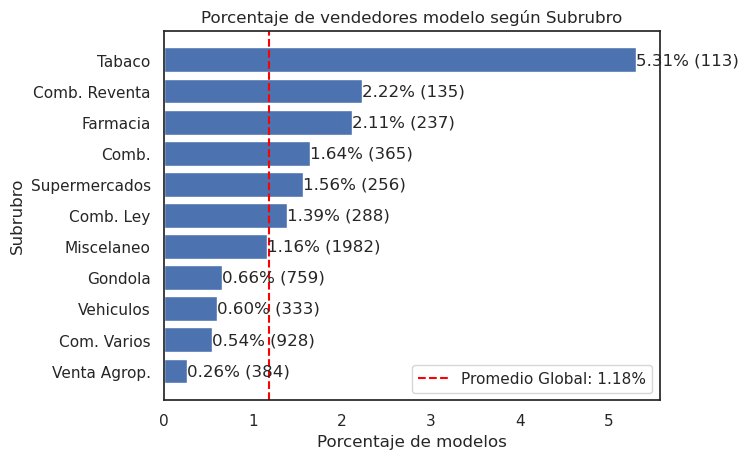

In [26]:
checkear_unicidad(ventas, 'Subrubro', 'ID')
graficar_modelo(ventas, 'Subrubro')

## Análisis de variables numéricas

In [27]:
ventas[['Ventas', 'Comision']].describe()

Ventas      Comision
count  3.706220e+05  3.706220e+05
mean   1.459124e+07  6.064590e+05
std    7.432475e+07  3.227135e+06
min   -3.475437e+08 -1.216403e+07
25%    0.000000e+00  0.000000e+00
50%    3.936936e+05  0.000000e+00
75%    8.060644e+06  3.353994e+05
max    6.894934e+09  3.447467e+08

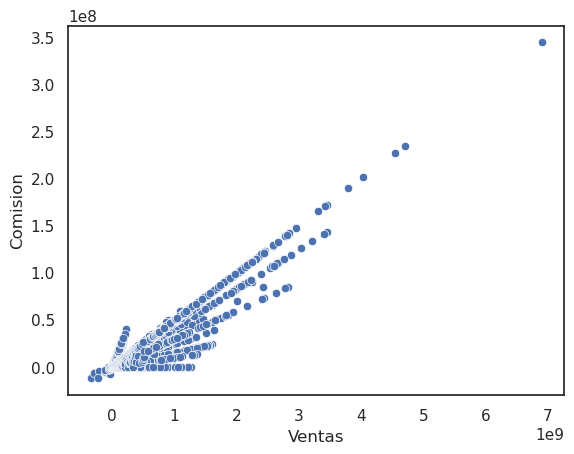

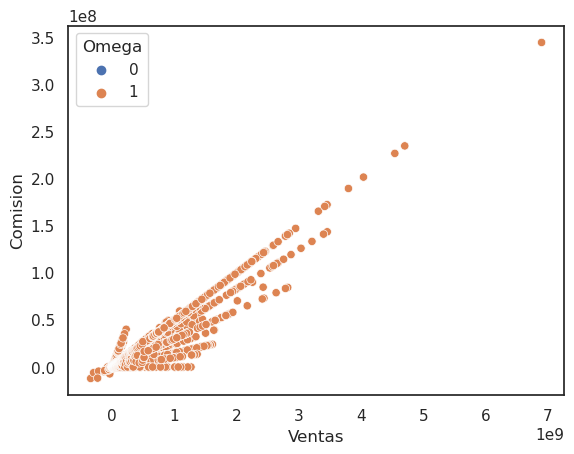

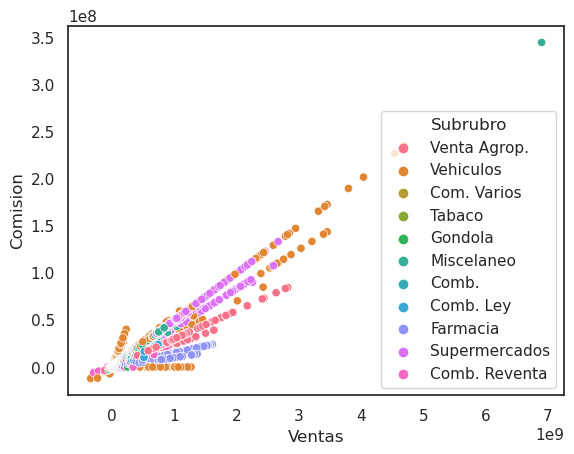

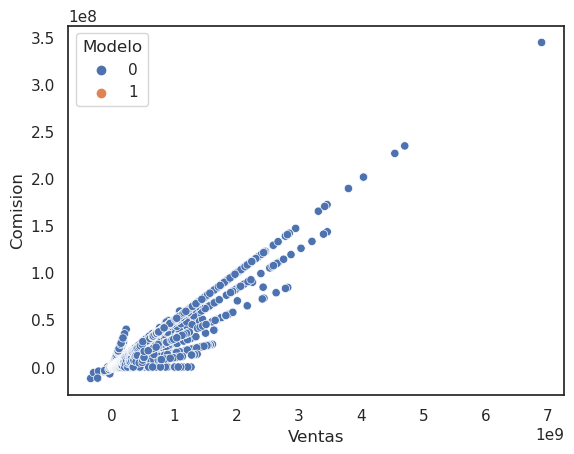

In [28]:
sns.scatterplot(data=ventas[['Ventas', 'Comision']], x='Ventas', y='Comision')
plt.show()

# Estas gráficas tardan bastante en generarse, descomentar para obtenerlas

for col in ['Omega', 'Subrubro', 'Modelo']:
    sns.scatterplot(data=ventas[['Ventas', 'Comision',col]], x='Ventas', y='Comision', hue=col)
    plt.show()

## Análisis de la serie temporal

En todos los subrurbos vemos que hay modelos y no modelo, incluso si exluimos las ventas nulas.

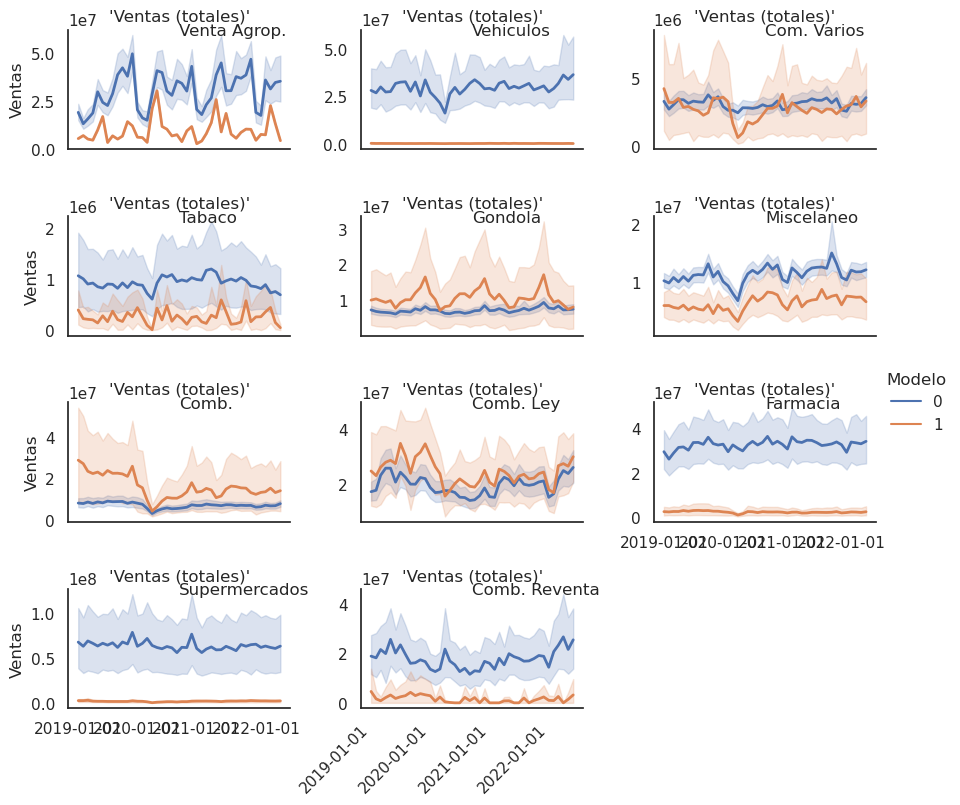

In [29]:
g = sns.relplot(
    data=ventas,
    x="Fecha", y="Ventas", col="Subrubro", hue="Modelo",
    kind="line", linewidth=2, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=True,
    facet_kws=dict(sharey=False)
)

# Iterate over each subplot to customize further
for subrubro, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.5, .95, subrubro, transform=ax.transAxes)

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xticks(rotation=45, ha='right')

g.set_titles("'Ventas (totales)'")
g.set_axis_labels("", "Ventas")    
#g.tight_layout()

plt.show()

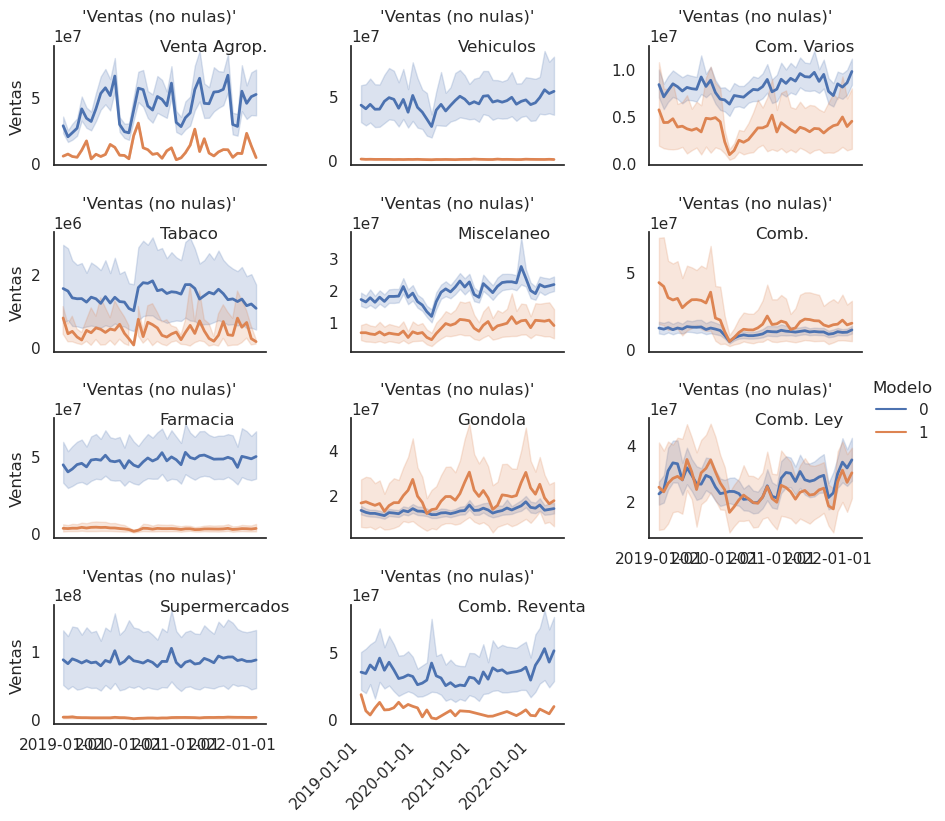

In [30]:
g = sns.relplot(
    data=ventas[ventas['Ventas'] != 0],
    x="Fecha", y="Ventas", col="Subrubro", hue="Modelo",
    kind="line", linewidth=2, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=True,
    facet_kws=dict(sharey=False)
)

# Iterate over each subplot to customize further
for subrubro, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.5, .95, subrubro, transform=ax.transAxes)

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xticks(rotation=45, ha='right')

g.set_titles("'Ventas (no nulas)'")
g.set_axis_labels("", "Ventas")    
#g.tight_layout()

plt.show()

---
# Datasets pivoteados: tp2 vs tp3

Vamos a comparar el dataset pivoteado que generamos al final del tp2 con el dataset pivoteado que generamos ahora, cuya principal diferencia es el punto 9 del pretratamiento: remplazamos con $0 a todas las ventas y comisiones que estaban en el rango desde -$10.000 hasta $10.000.

In [31]:
tp2 = pd.read_csv('../data/interim/tp2_vendedores_vector_resumen.csv')
tp2 = limpiar_basic(tp2, cols_drop=['Omega', 'F_ven_mean', 'F_ven_var', 
                                    'F_com_mean', 'F_com_var', 'Y_ven_mean', 
                                    'Y_ven_var', 'Y_com_mean', 'Y_com_var'])

tp3 = pd.read_csv('../data/interim/tp3_vendedores_vector.csv')
tp3 = limpiar_basic(tp3, cols_drop='Omega')

Las filas de estos datasets representaban un vendedor único, dado el subrubro. Esto implica que un mismo `ID` puede aparecer más de una vez, pero es porque ese vendedor vende en dos o más `Subrubros`.

In [32]:
print(f'El del tp2 tenía {tp2.shape[0]} filas, mientras que el nuevo tiene {tp3.shape[0]}.')
print(f'Hay {tp2.shape[0] - tp3.shape[0]} menos.')

El del tp2 tenía 4616 filas, mientras que el nuevo tiene 4544.
Hay 72 menos.


## Sin diferenciar por subrubro

En la siguiente figura se grafican las medias con sus respectivas desviaciones estándares para cada variable porcentual. Vemos que, al haber agregado este paso nuevo en el pretratamiento, los datos son muchísimo menos ruidosos.

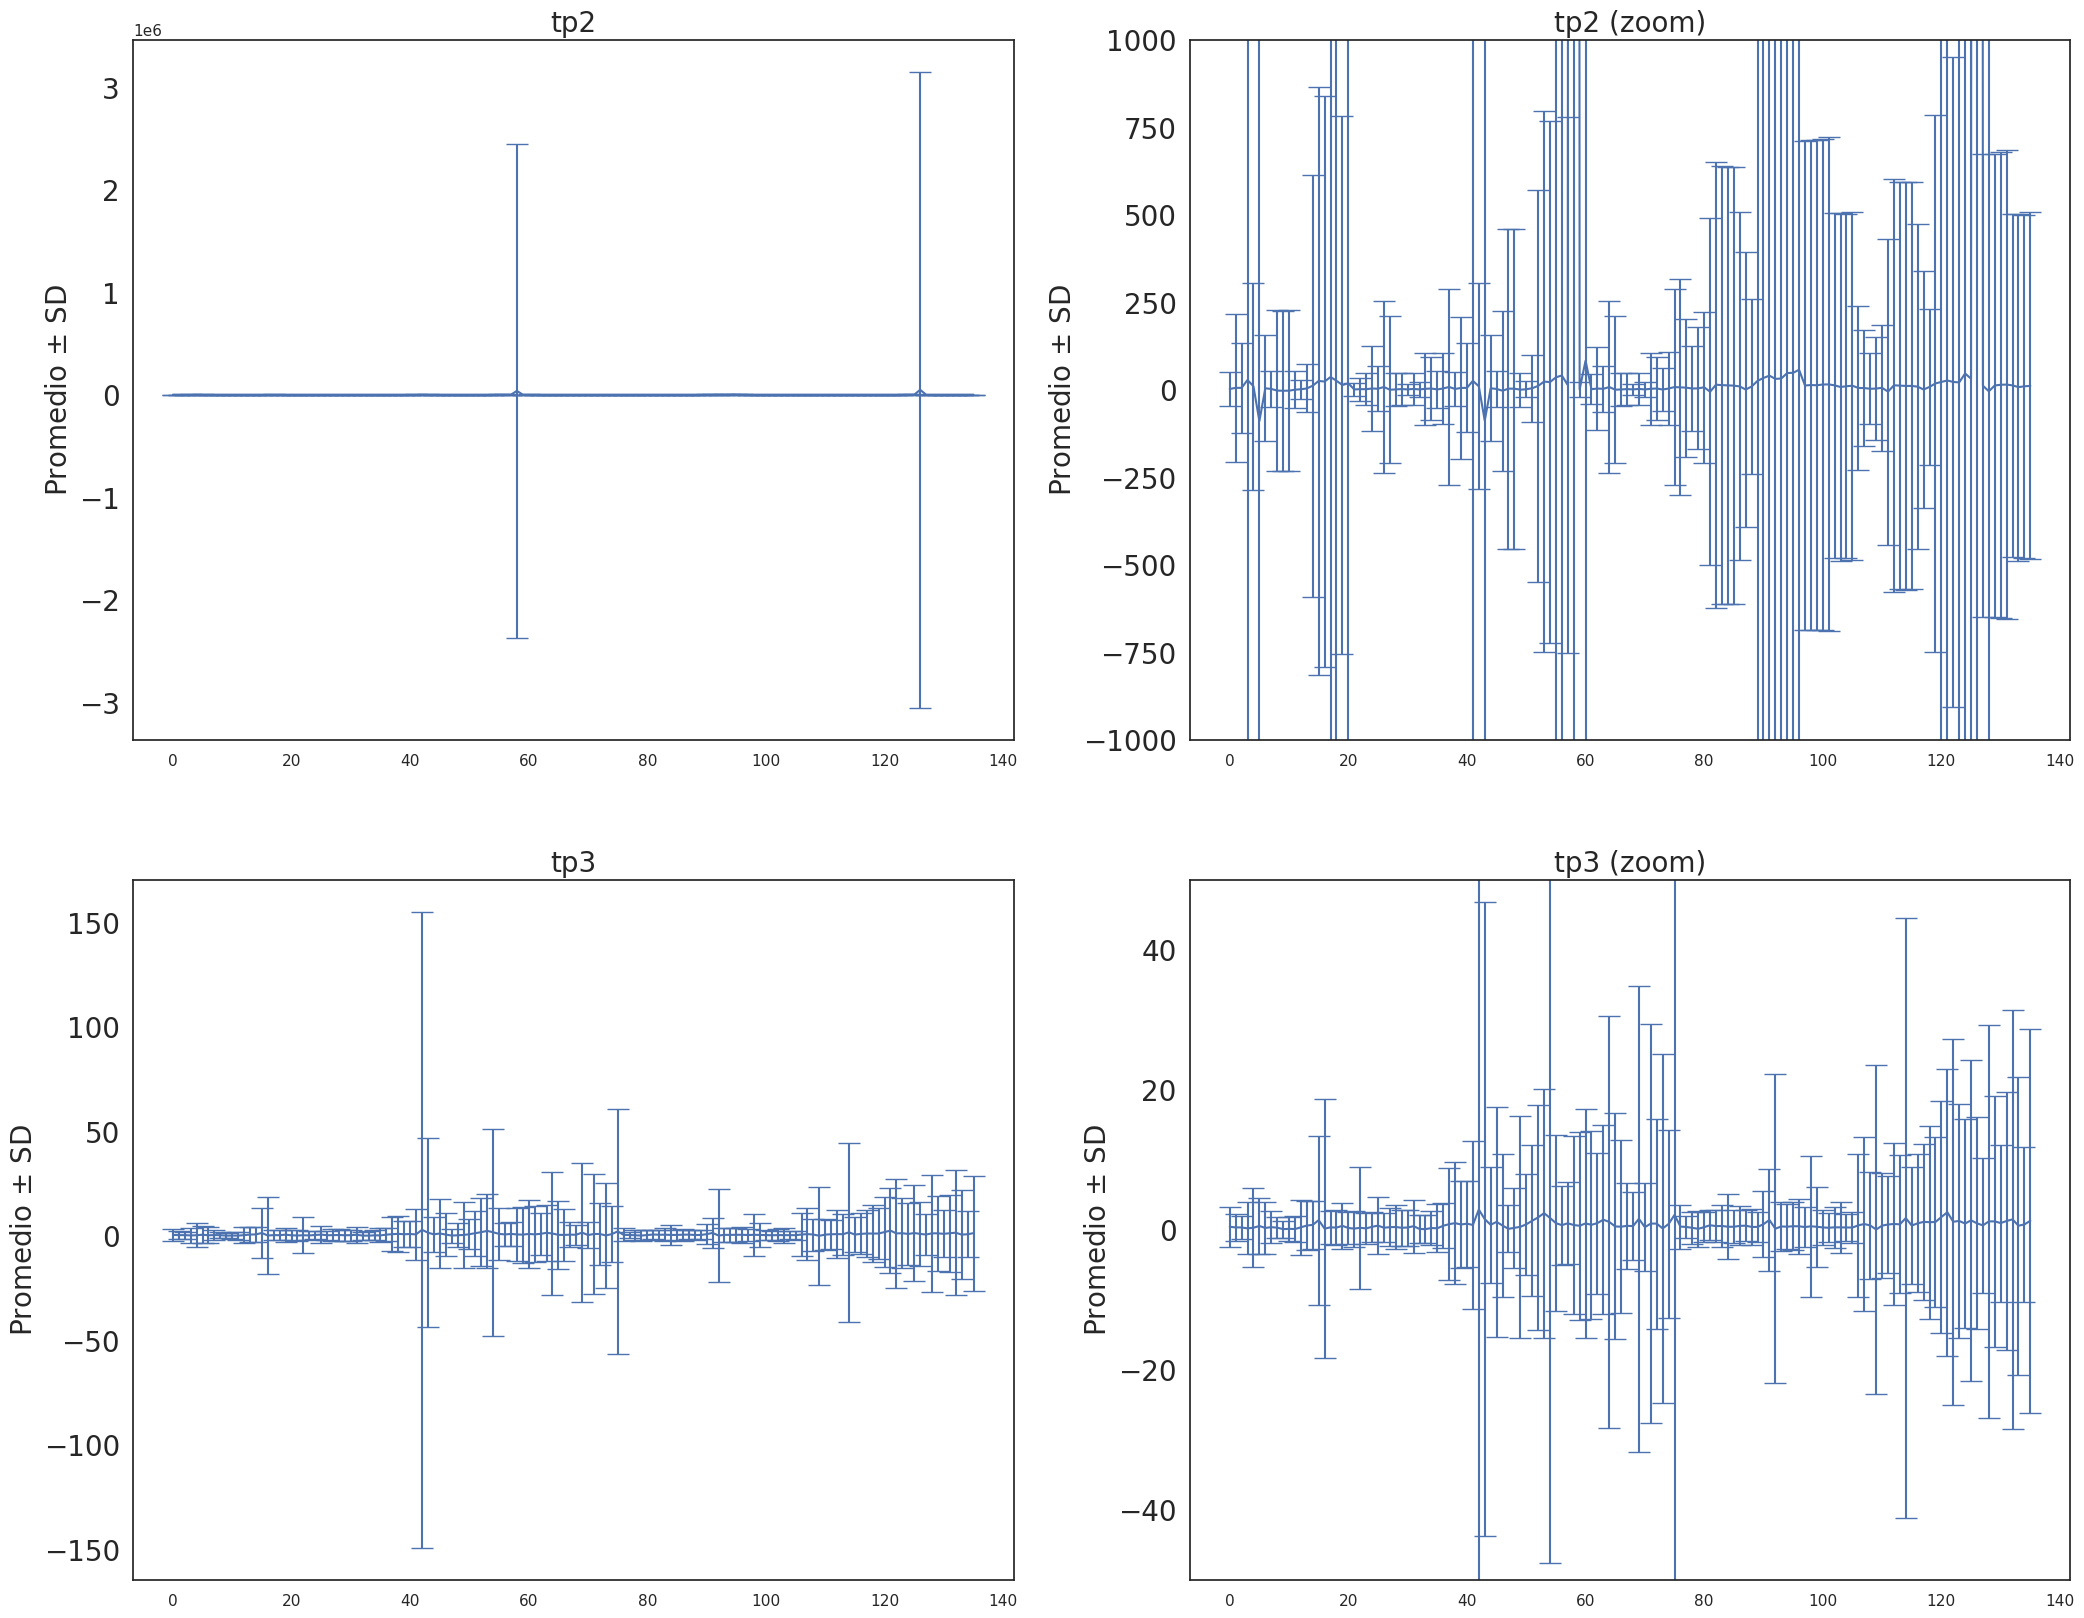

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(25, 20))

axs[0, 0].set_title('tp2', fontsize=20)
axs[0, 0].errorbar(range(len(tp2.iloc[:, 3:].mean())), tp2.iloc[:, 3:].mean(), yerr = tp2.iloc[:, 3:].std(), capsize = 8)
axs[0, 0].set_ylabel(r'Promedio $\pm$ SD', fontsize=20)
axs[0, 0].tick_params(axis='y', labelsize=20)

axs[0, 1].set_title('tp2 (zoom)', fontsize=20)
axs[0, 1].errorbar(range(len(tp2.iloc[:, 3:].mean())), tp2.iloc[:, 3:].mean(), yerr = tp2.iloc[:, 3:].std(), capsize = 8)
axs[0, 1].set_ylabel(r'Promedio $\pm$ SD', fontsize=20)
axs[0, 1].set_ylim(-1E3, 1E3)
axs[0, 1].tick_params(axis='y', labelsize=20)

axs[1, 0].set_title('tp3', fontsize=20)
axs[1, 0].errorbar(range(len(tp3.iloc[:, 3:].mean())), tp3.iloc[:, 3:].mean(), yerr = tp3.iloc[:, 3:].std(), capsize = 8)
axs[1, 0].set_ylabel(r'Promedio $\pm$ SD', fontsize=20)
axs[1, 0].tick_params(axis='y', labelsize=20)

axs[1, 1].set_title('tp3 (zoom)', fontsize=20)
axs[1, 1].errorbar(range(len(tp3.iloc[:, 3:].mean())), tp3.iloc[:, 3:].mean(), yerr = tp3.iloc[:, 3:].std(), capsize = 8)
axs[1, 1].set_ylabel(r'Promedio $\pm$ SD', fontsize=20)
axs[1, 1].set_ylim(-50, 50)
axs[1, 1].tick_params(axis='y', labelsize=20)

plt.show()

Al comparar entre valores promedios, vemos que hay dos variables cuyo promedio ha bajado drásticamente. Para el resto, en general ha bajado en la mayoría de los casos, salvo algunos donde ha subido.

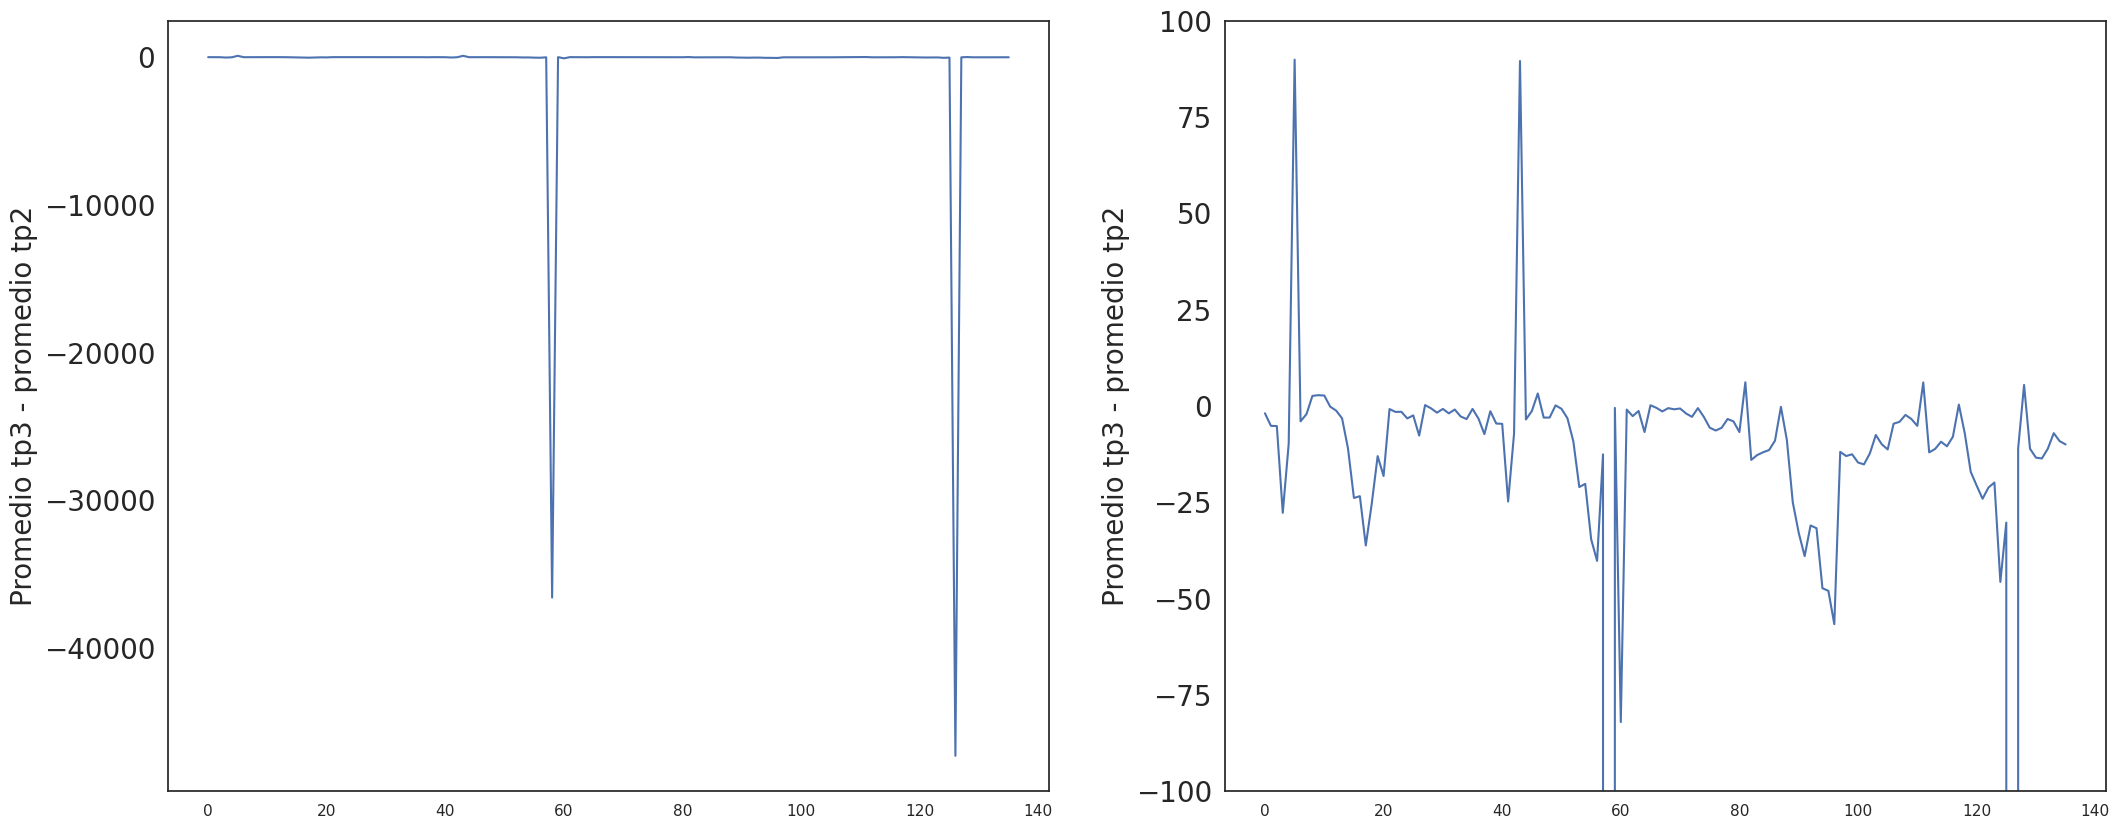

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(25, 10))

axs[0].plot(range(len(tp3.iloc[:, 3:].mean())), tp3.iloc[:, 3:].mean() - tp2.iloc[:, 3:].mean())
axs[0].set_ylabel(r'Promedio tp3 - promedio tp2', fontsize=20)
axs[0].tick_params(axis='y', labelsize=20)

axs[1].plot(range(len(tp3.iloc[:, 3:].mean())), tp3.iloc[:, 3:].mean() - tp2.iloc[:, 3:].mean())
axs[1].set_ylabel(r'Promedio tp3 - promedio tp2', fontsize=20)
axs[1].tick_params(axis='y', labelsize=20)
axs[1].set_ylim(-100, 100)

plt.show()

Veamos cuáles eran los órdenes de magnitud de valores más extremos a lo largo de todo el dataset. Antes las variaciones porcentuales cubrían 13 órdenes de magnitud, mientras que ahora ocupan 6.

In [35]:
print('TP2:')
print(f'\t El mínimo era {np.min(tp2.iloc[:, 3:].min()):.2e}')
print(f'\t El máximo era {np.max(tp2.iloc[:, 3:].max()):.2e}')

print('TP3:')
print(f'\t El mínimo es {np.min(tp3.iloc[:, 3:].min()):.2e}')
print(f'\t El máximo es {np.max(tp3.iloc[:, 3:].max()):.2e}')

TP2:
	 El mínimo era -3.82e+05
	 El máximo era 2.04e+08
TP3:
	 El mínimo es -1.47e+03
	 El máximo es 9.62e+03


## Diferenciando por subrubro

Al desagregar por subrubro, se sigue manteniendo el hecho de que los datos son muchísimo menos ruidosos ahora. Sin embargo, se ve que algunos subrubros presentan una mayor variación entre el tp2 y tp3 que otros: 'Farmacia', 'Comb.', 'Vehiculos', 'Tabaco' y 'Comb. Reventa' presentan las variaciones más leves.

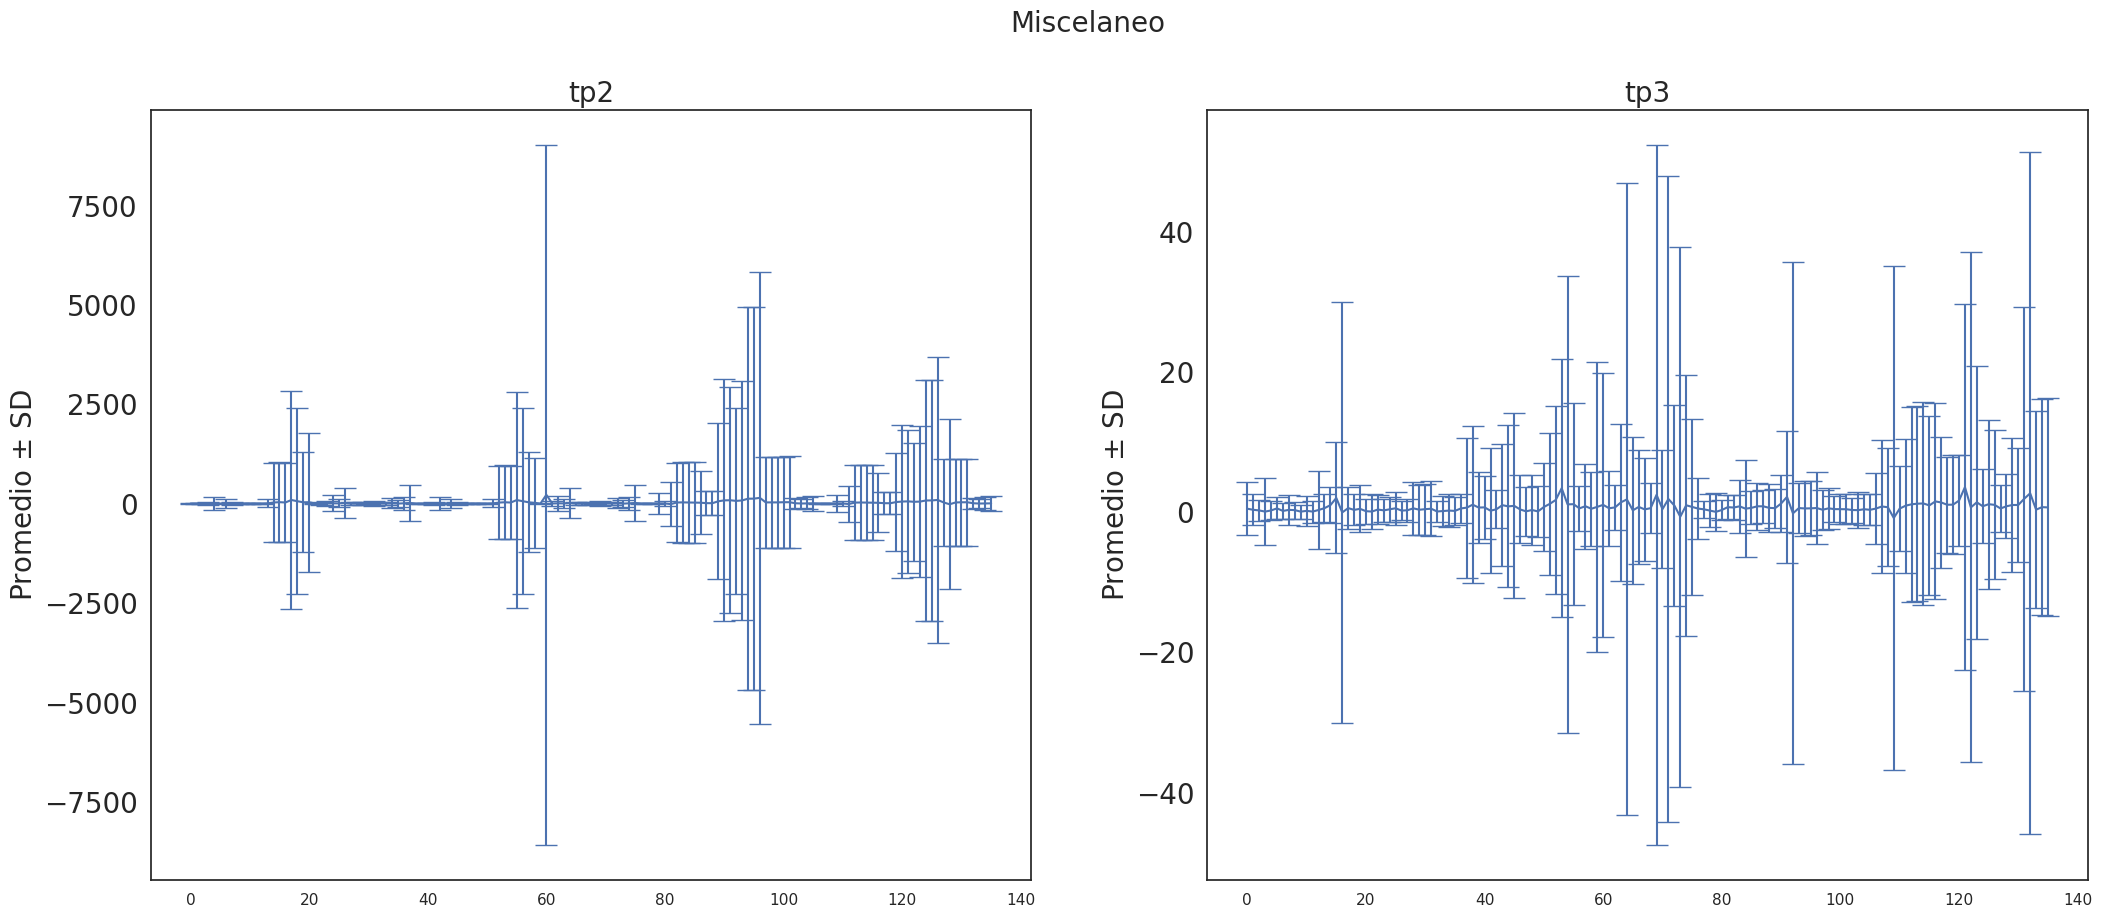

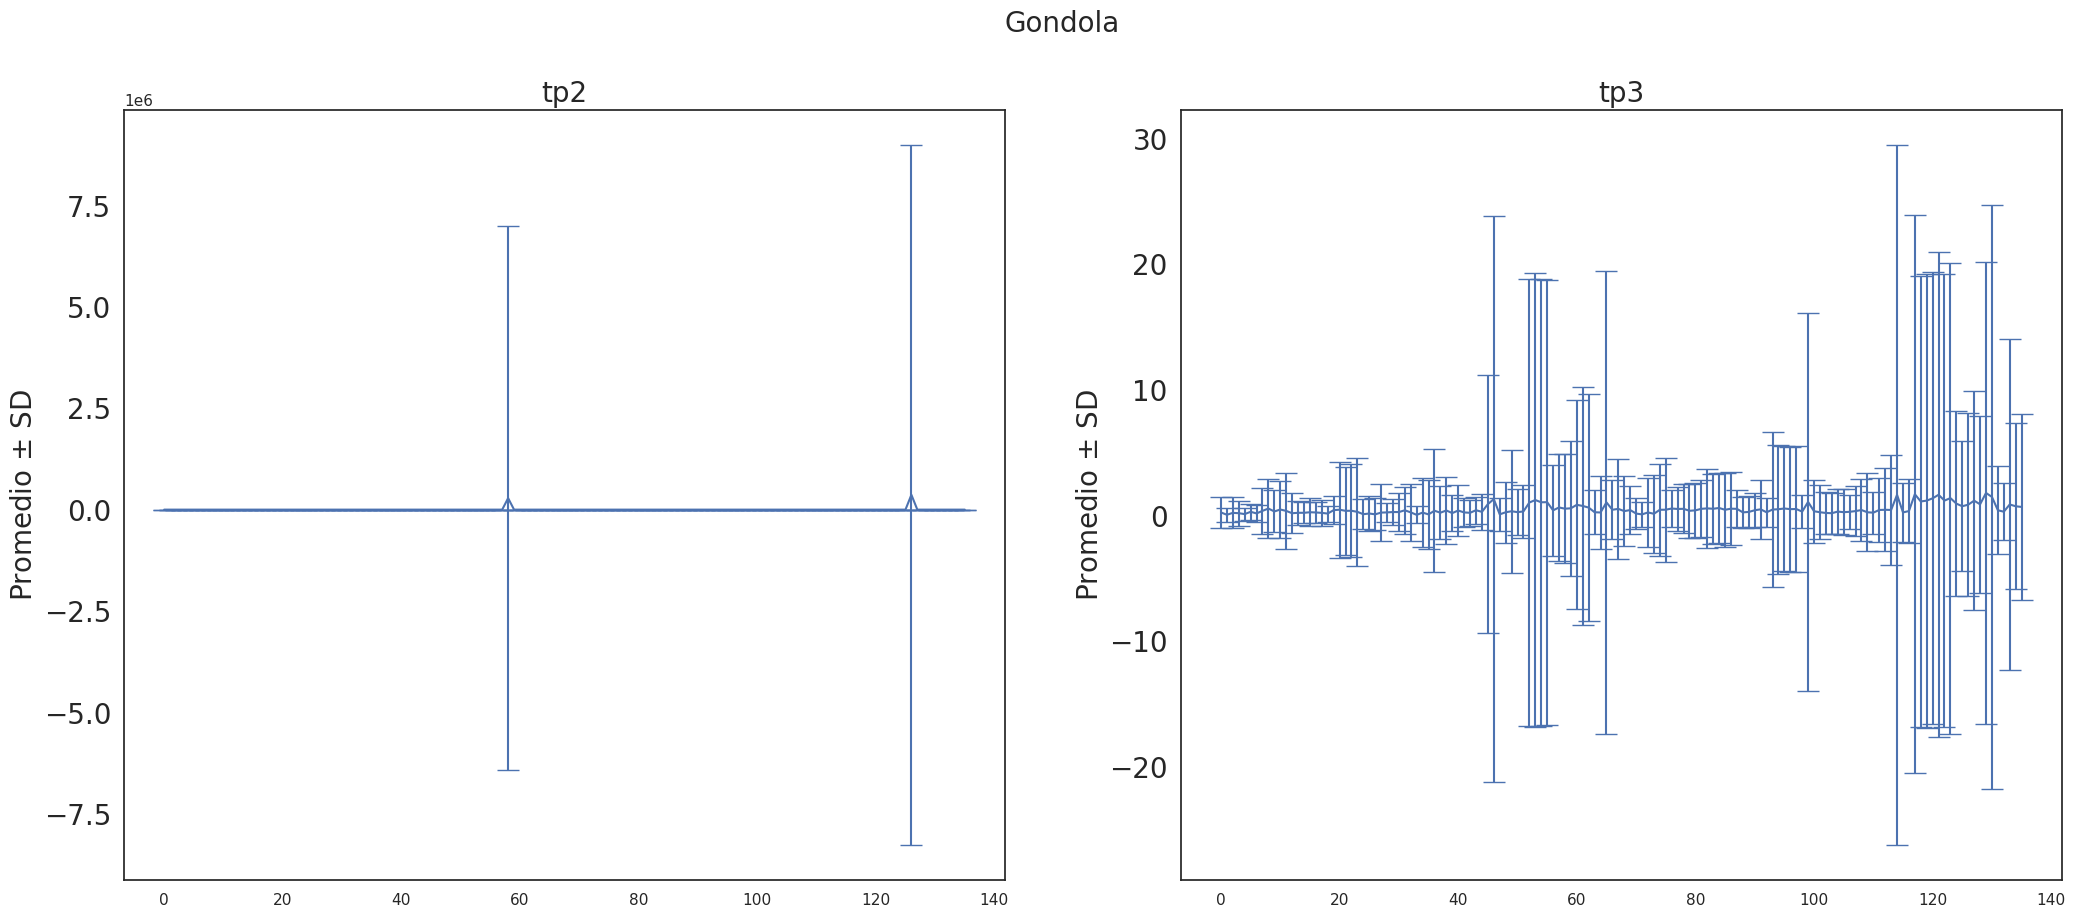

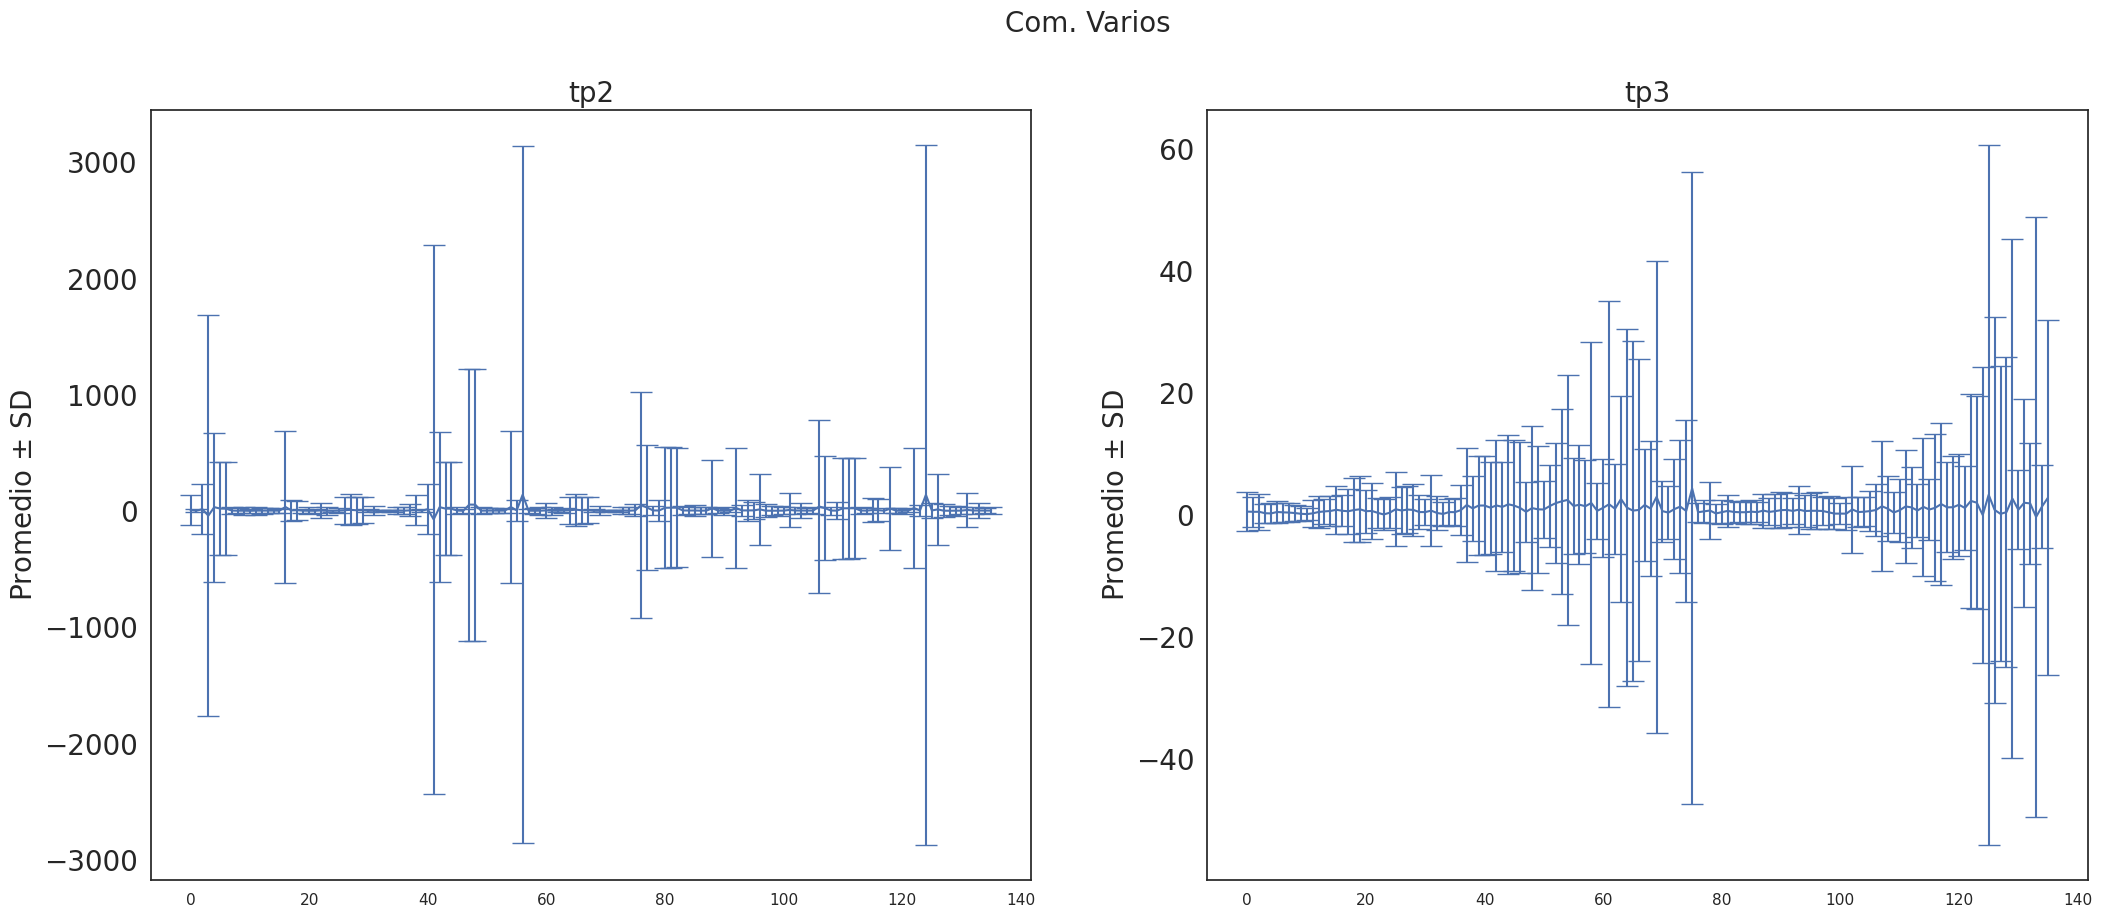

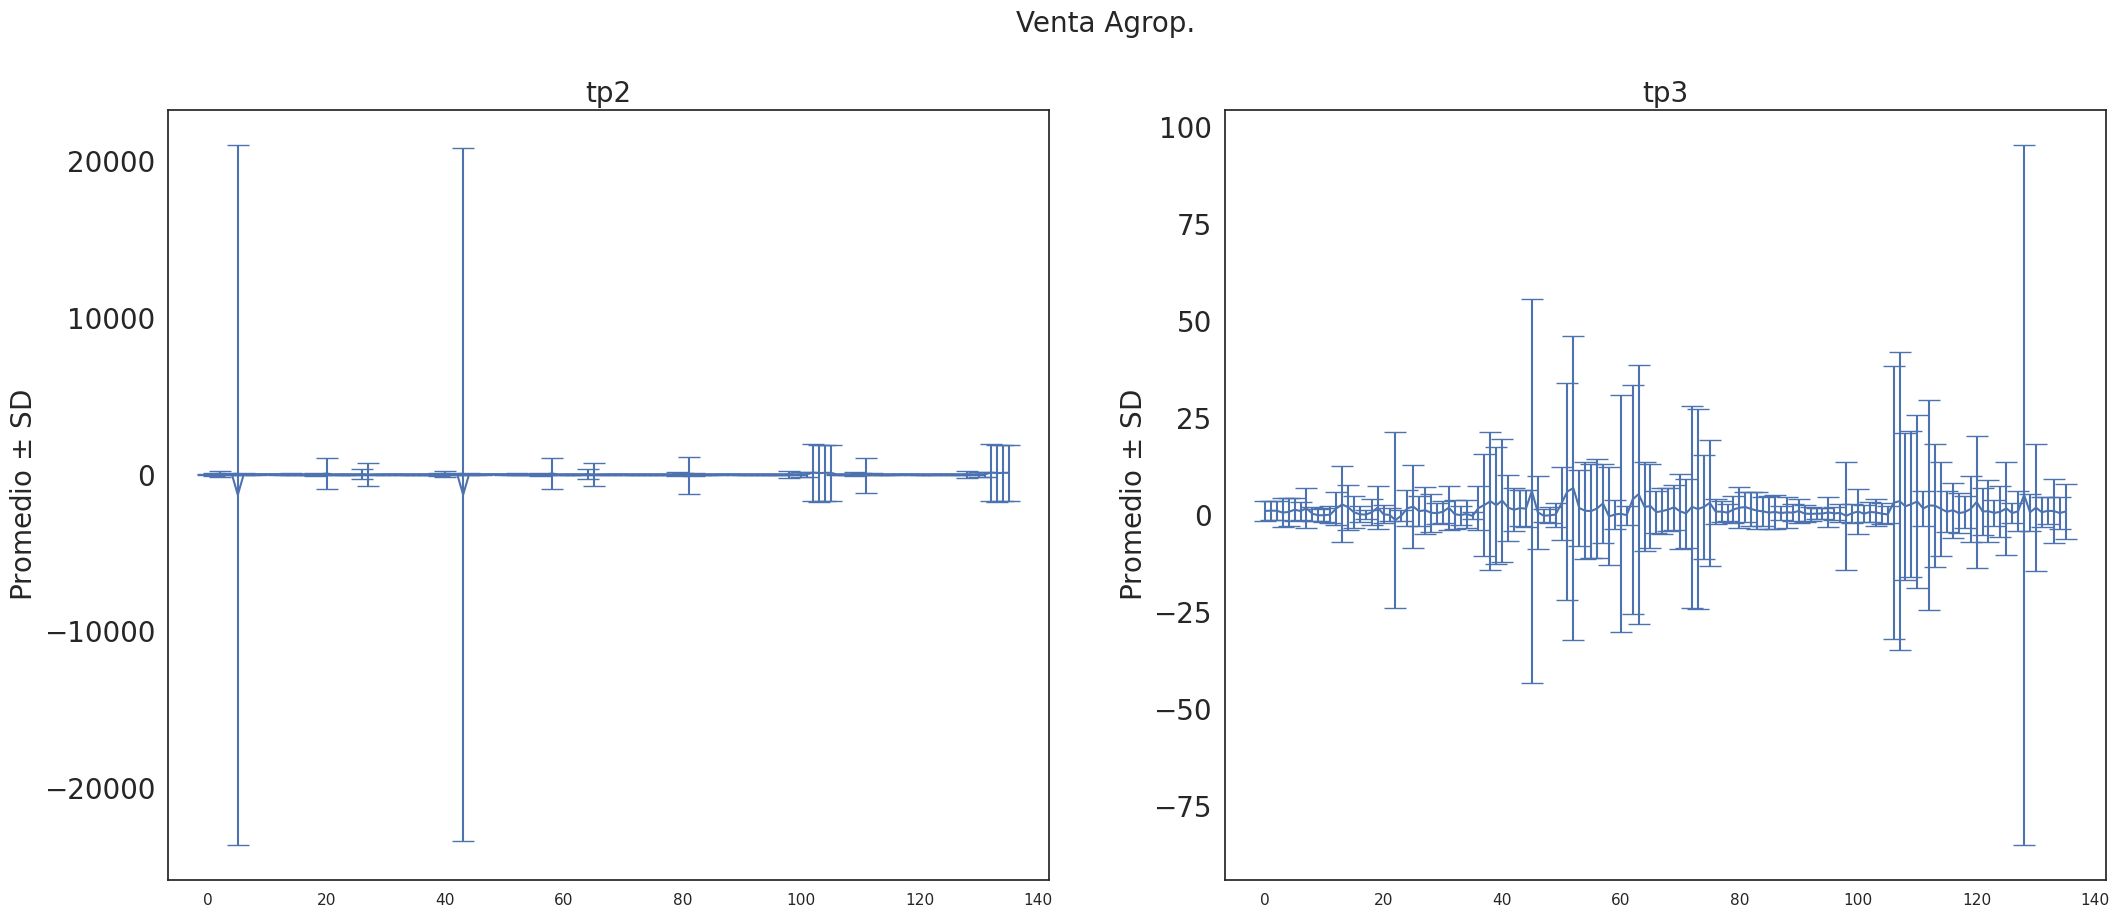

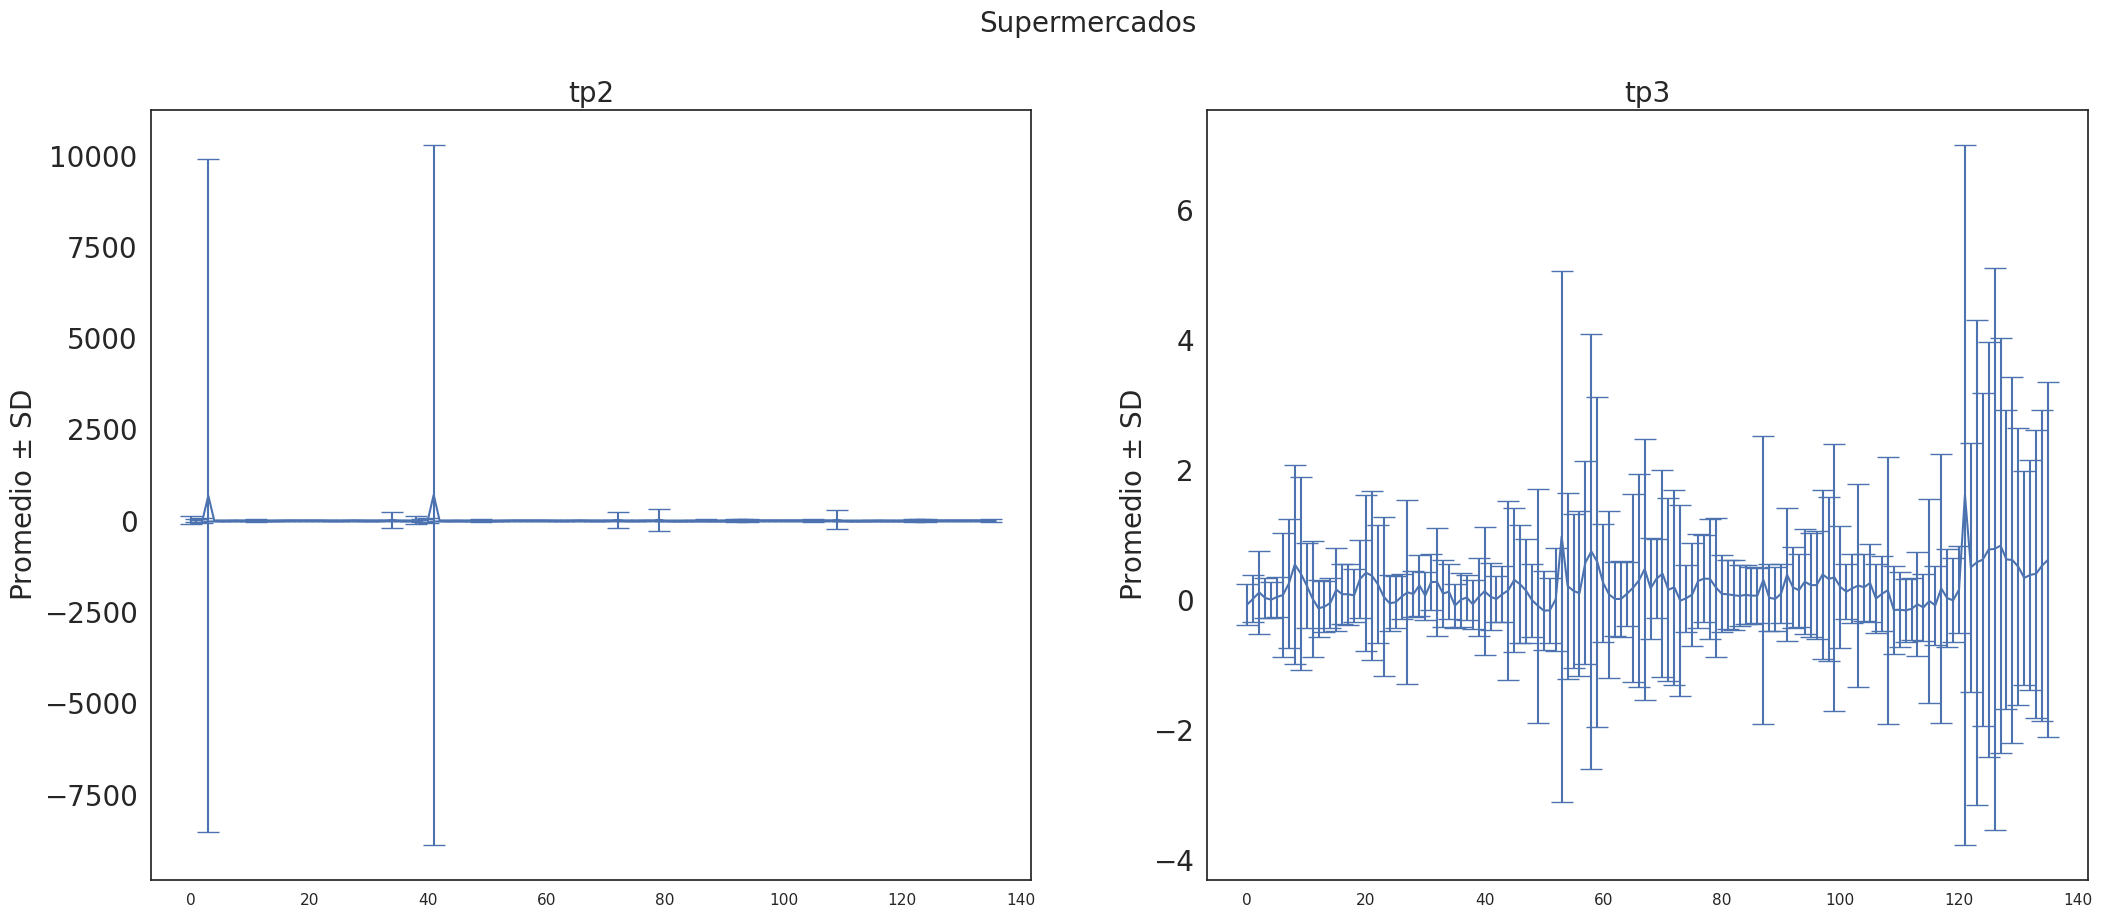

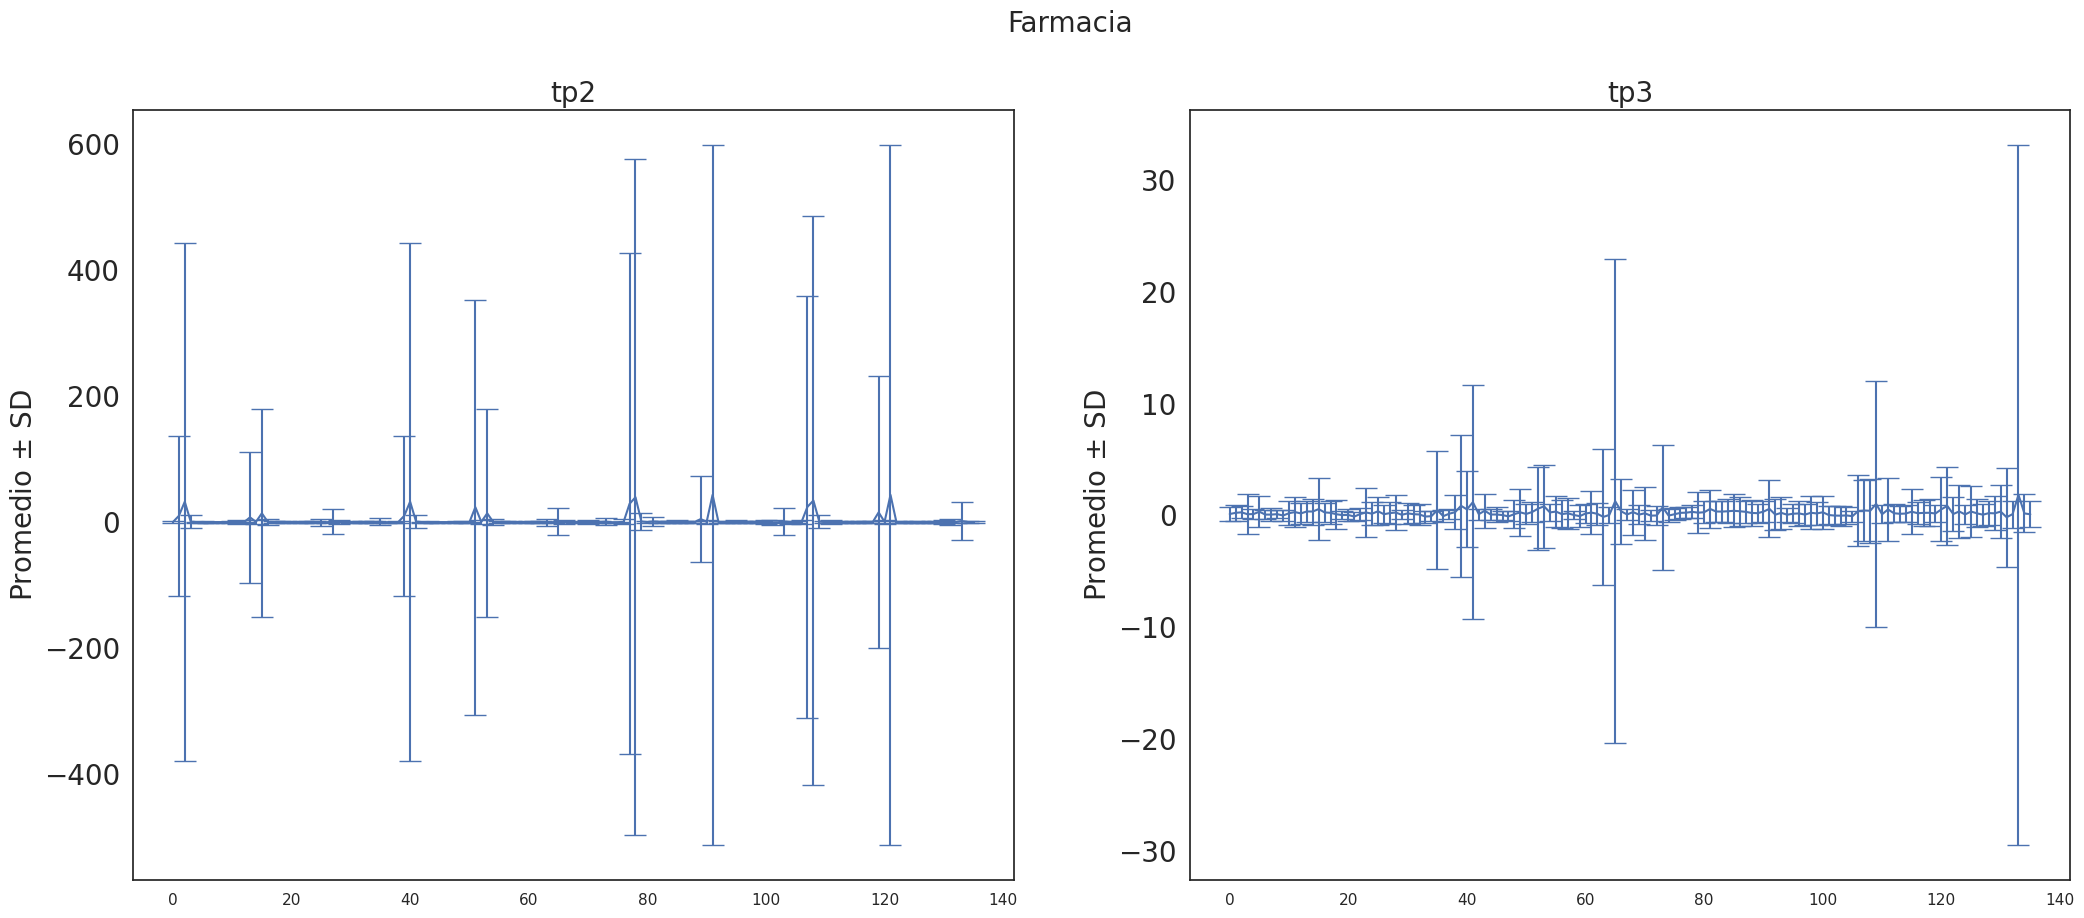

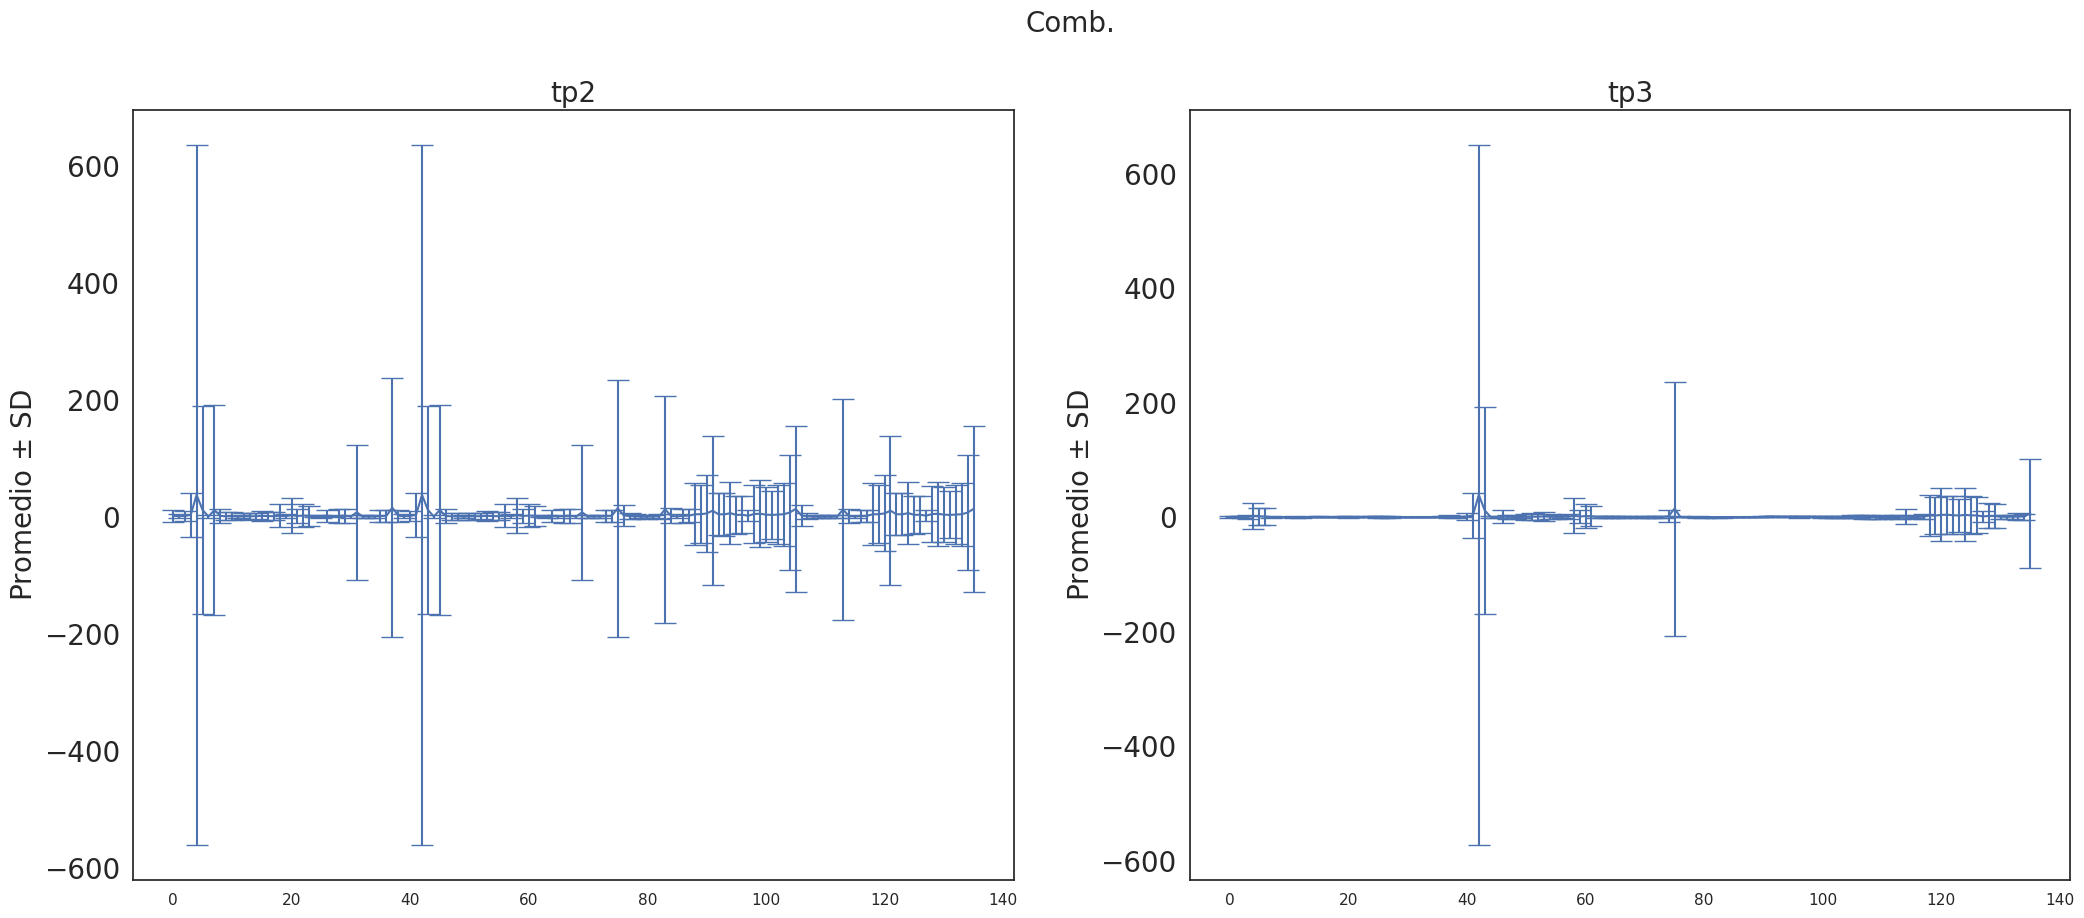

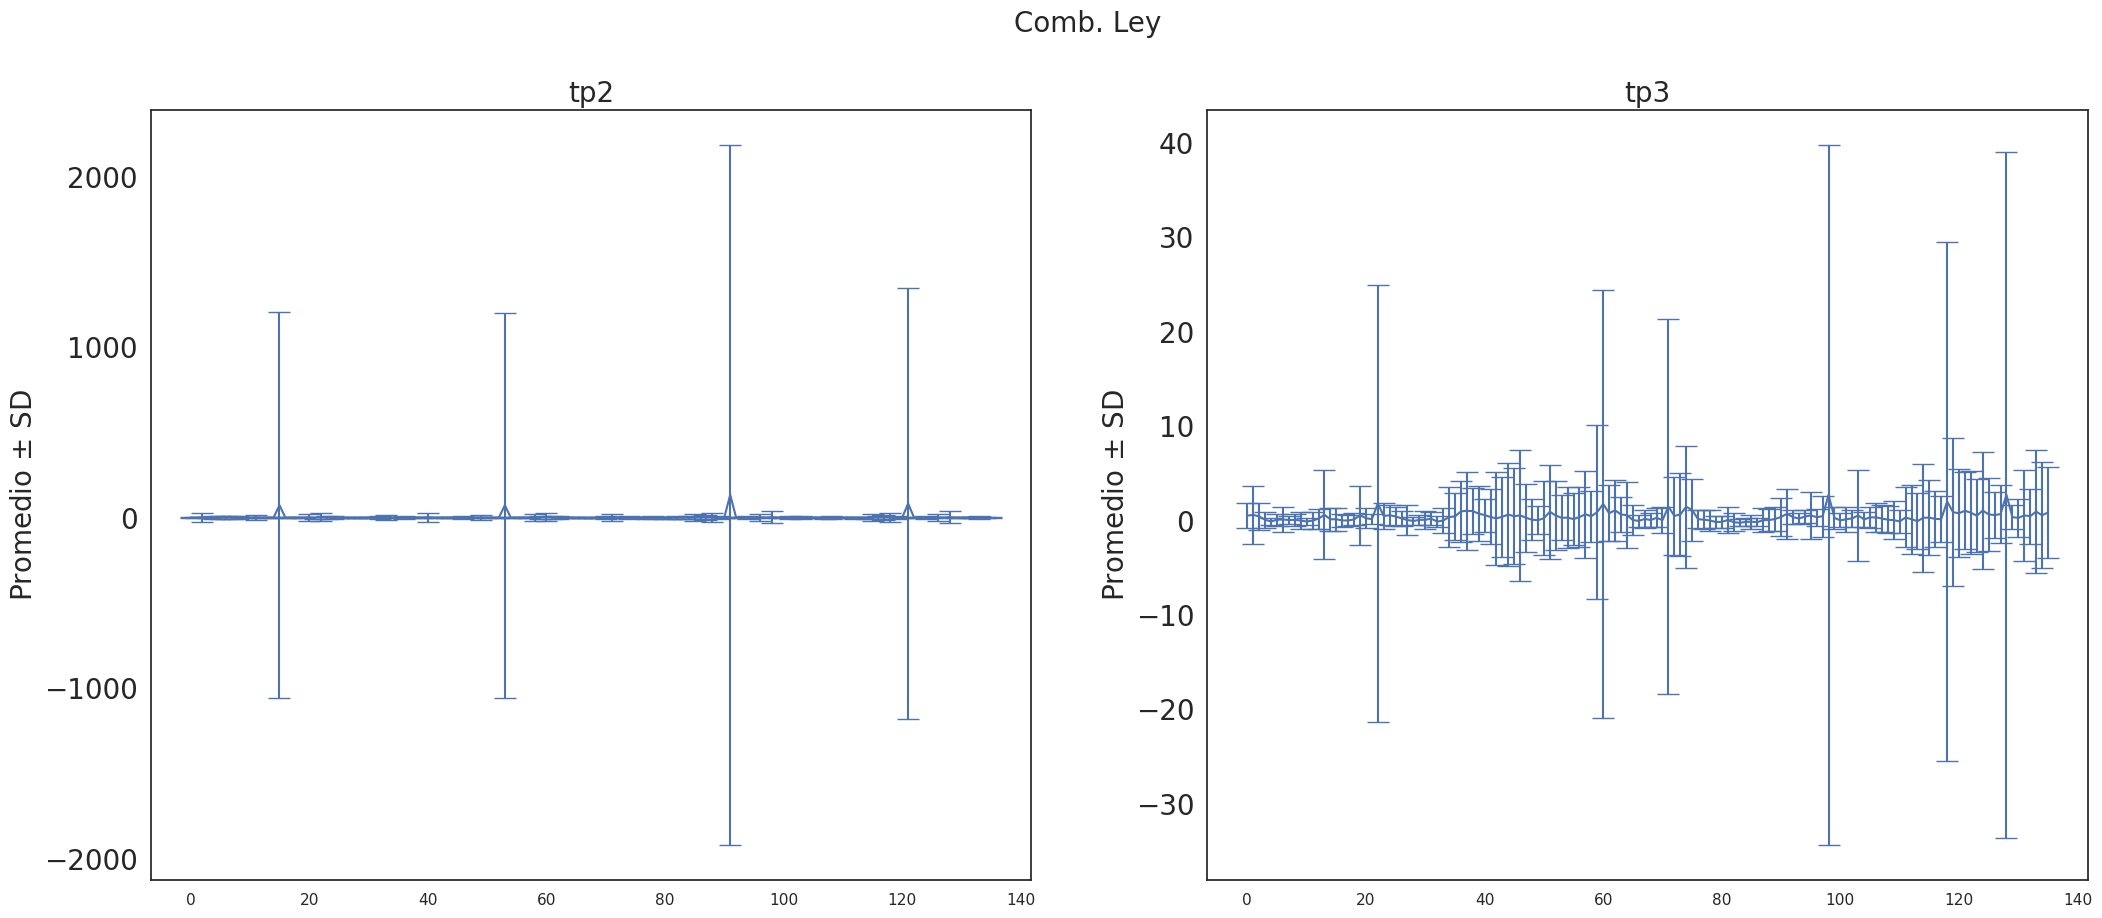

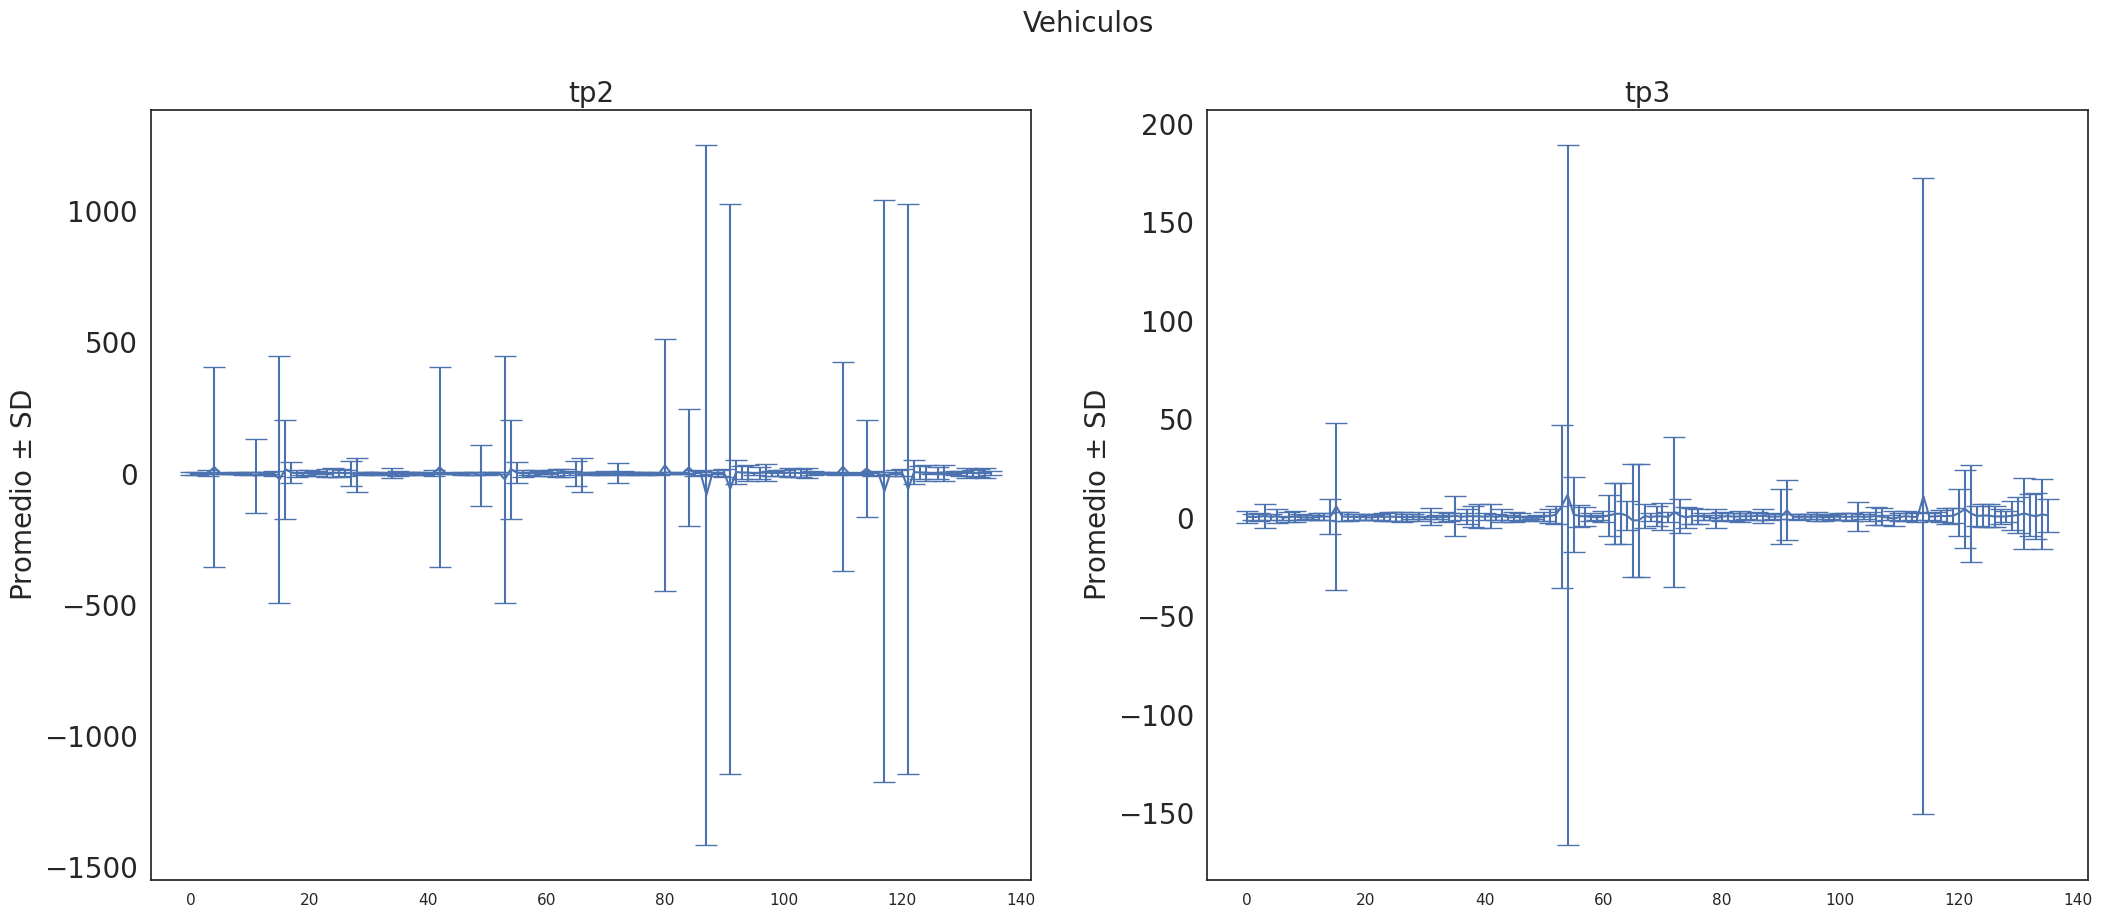

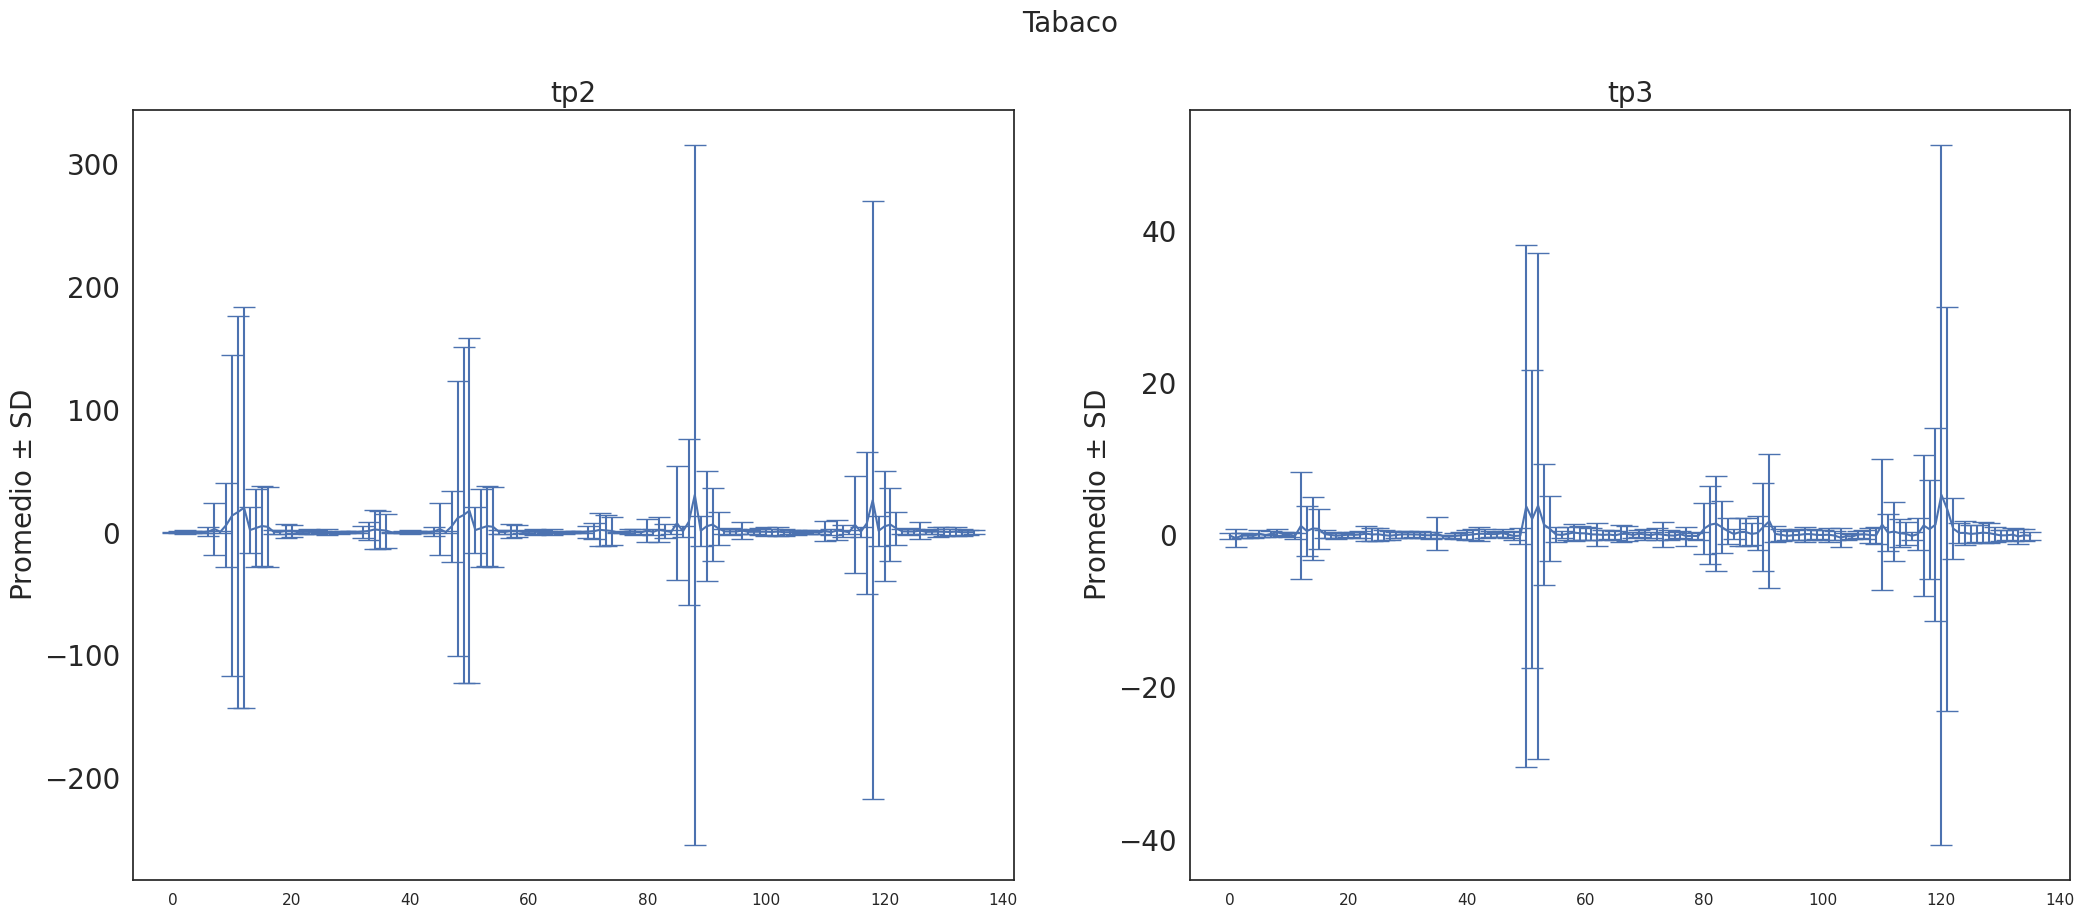

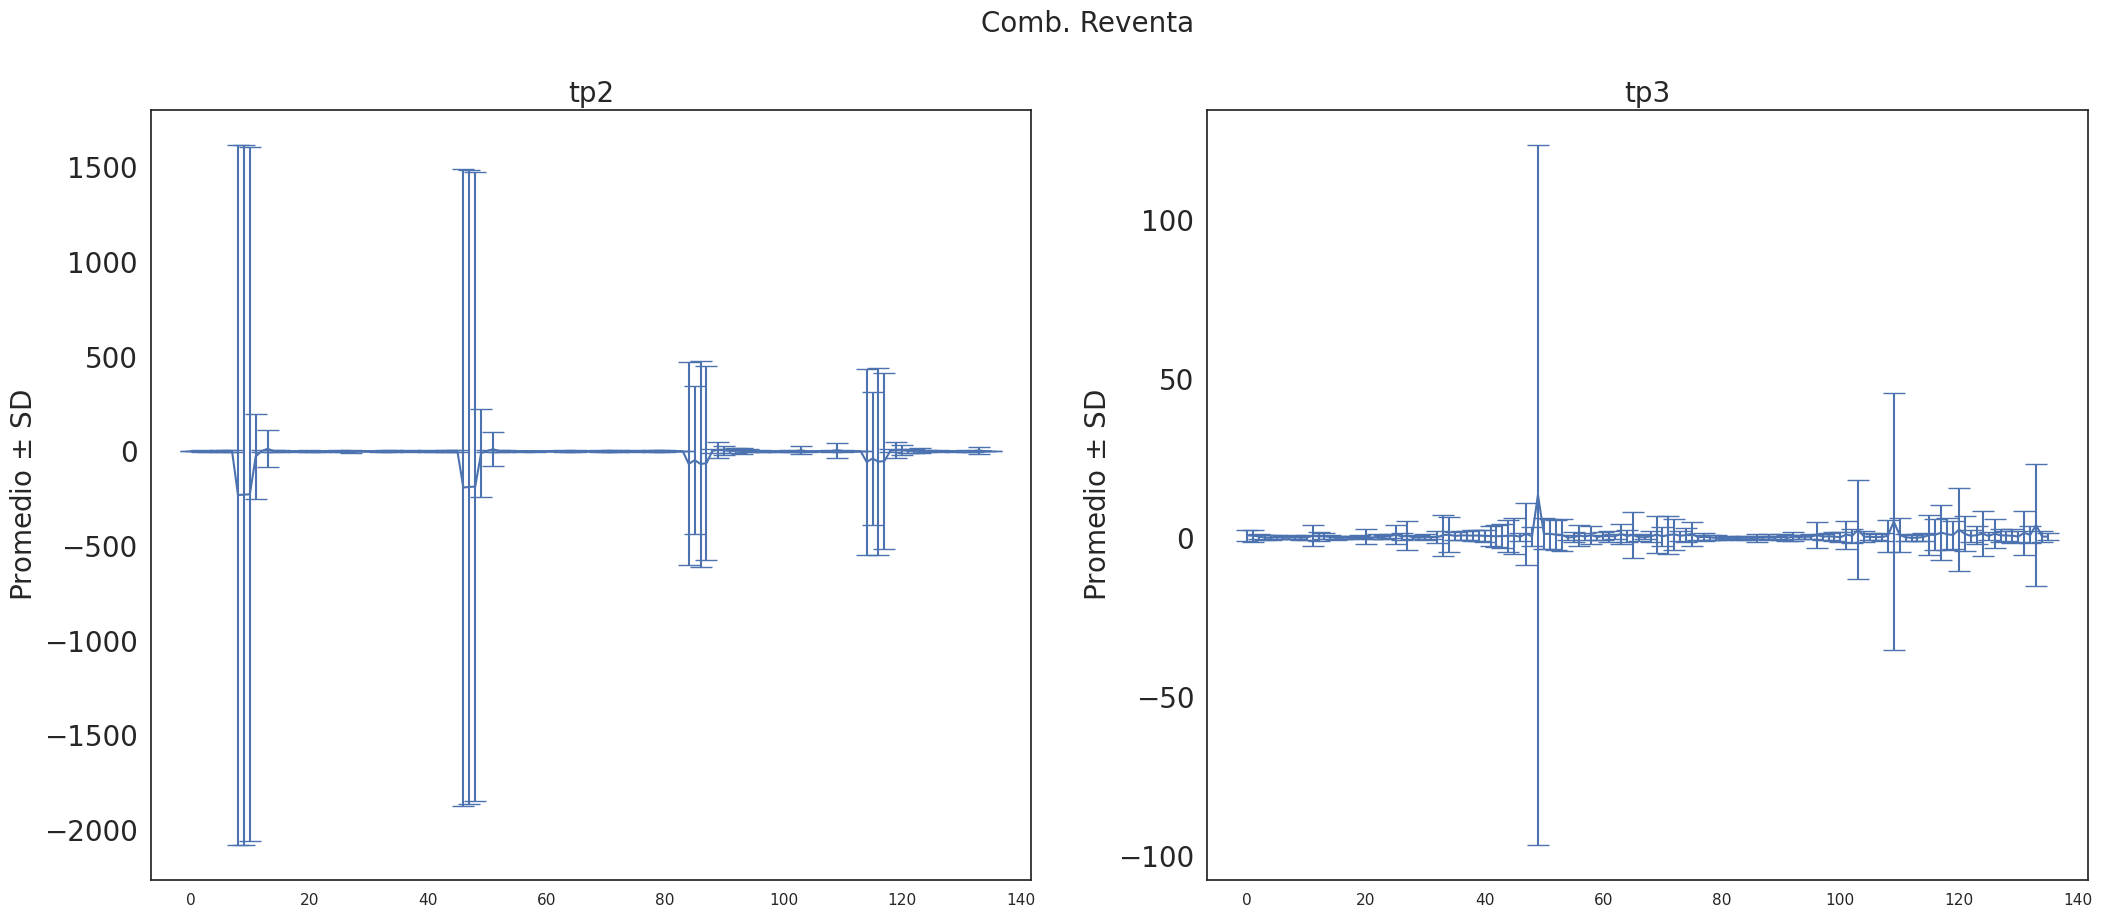

In [36]:
for sr in tp2.Subrubro.unique():

    tp2sr = tp2[tp2['Subrubro'] == sr].copy()
    tp3sr = tp3[tp3['Subrubro'] == sr].copy()

    fig, axs = plt.subplots(1, 2, figsize=(25, 10))

    fig.suptitle(sr, fontsize=20)

    axs[0].set_title('tp2', fontsize=20)
    axs[0].errorbar(range(len(tp2sr.iloc[:, 3:].mean())), tp2sr.iloc[:, 3:].mean(), yerr = tp2sr.iloc[:, 3:].std(), capsize = 8)
    axs[0].set_ylabel(r'Promedio $\pm$ SD', fontsize=20)
    axs[0].tick_params(axis='y', labelsize=20)

    axs[1].set_title('tp3', fontsize=20)
    axs[1].errorbar(range(len(tp3sr.iloc[:, 3:].mean())), tp3sr.iloc[:, 3:].mean(), yerr = tp3sr.iloc[:, 3:].std(), capsize = 8)
    axs[1].set_ylabel(r'Promedio $\pm$ SD', fontsize=20)
    axs[1].tick_params(axis='y', labelsize=20)

    plt.show()

---
# Datos faltantes en el nuevo dataset pivoteado

## Sin distinguir por subrubro

Vemos que hay una gran cantidad de datos faltantes en todas las variables asociadas a la variación porcentual. Más aún: ninguna de estas columnas posee el 100% de los datos. Para cada grupo de variables (según sea comisión/ventas o anual/cuatrimestral) la cantidad de datos faltantes disminuye al progresar en el tiempo (lo cual tiene sentido).

Las variables asociadas a la comisión presentan más datos faltantes que aquellas asociadas a las ventas. Dentro de ventas, hay más datos en el caso cuatrimestral que en el caso anual.

**Nota:** En la gráfica aparecen, desde arriba hacia abajo, ventas anuales, comisión anuales, ventas cuatrimestrales y comisión cuatrimestrales. Dentro de cada grupo, aparecen desde el mes más reciente hacia el más antigüo.

ValueError: The number of FixedLocator locations (0), usually from a call to set_ticks, does not match the number of labels (136).

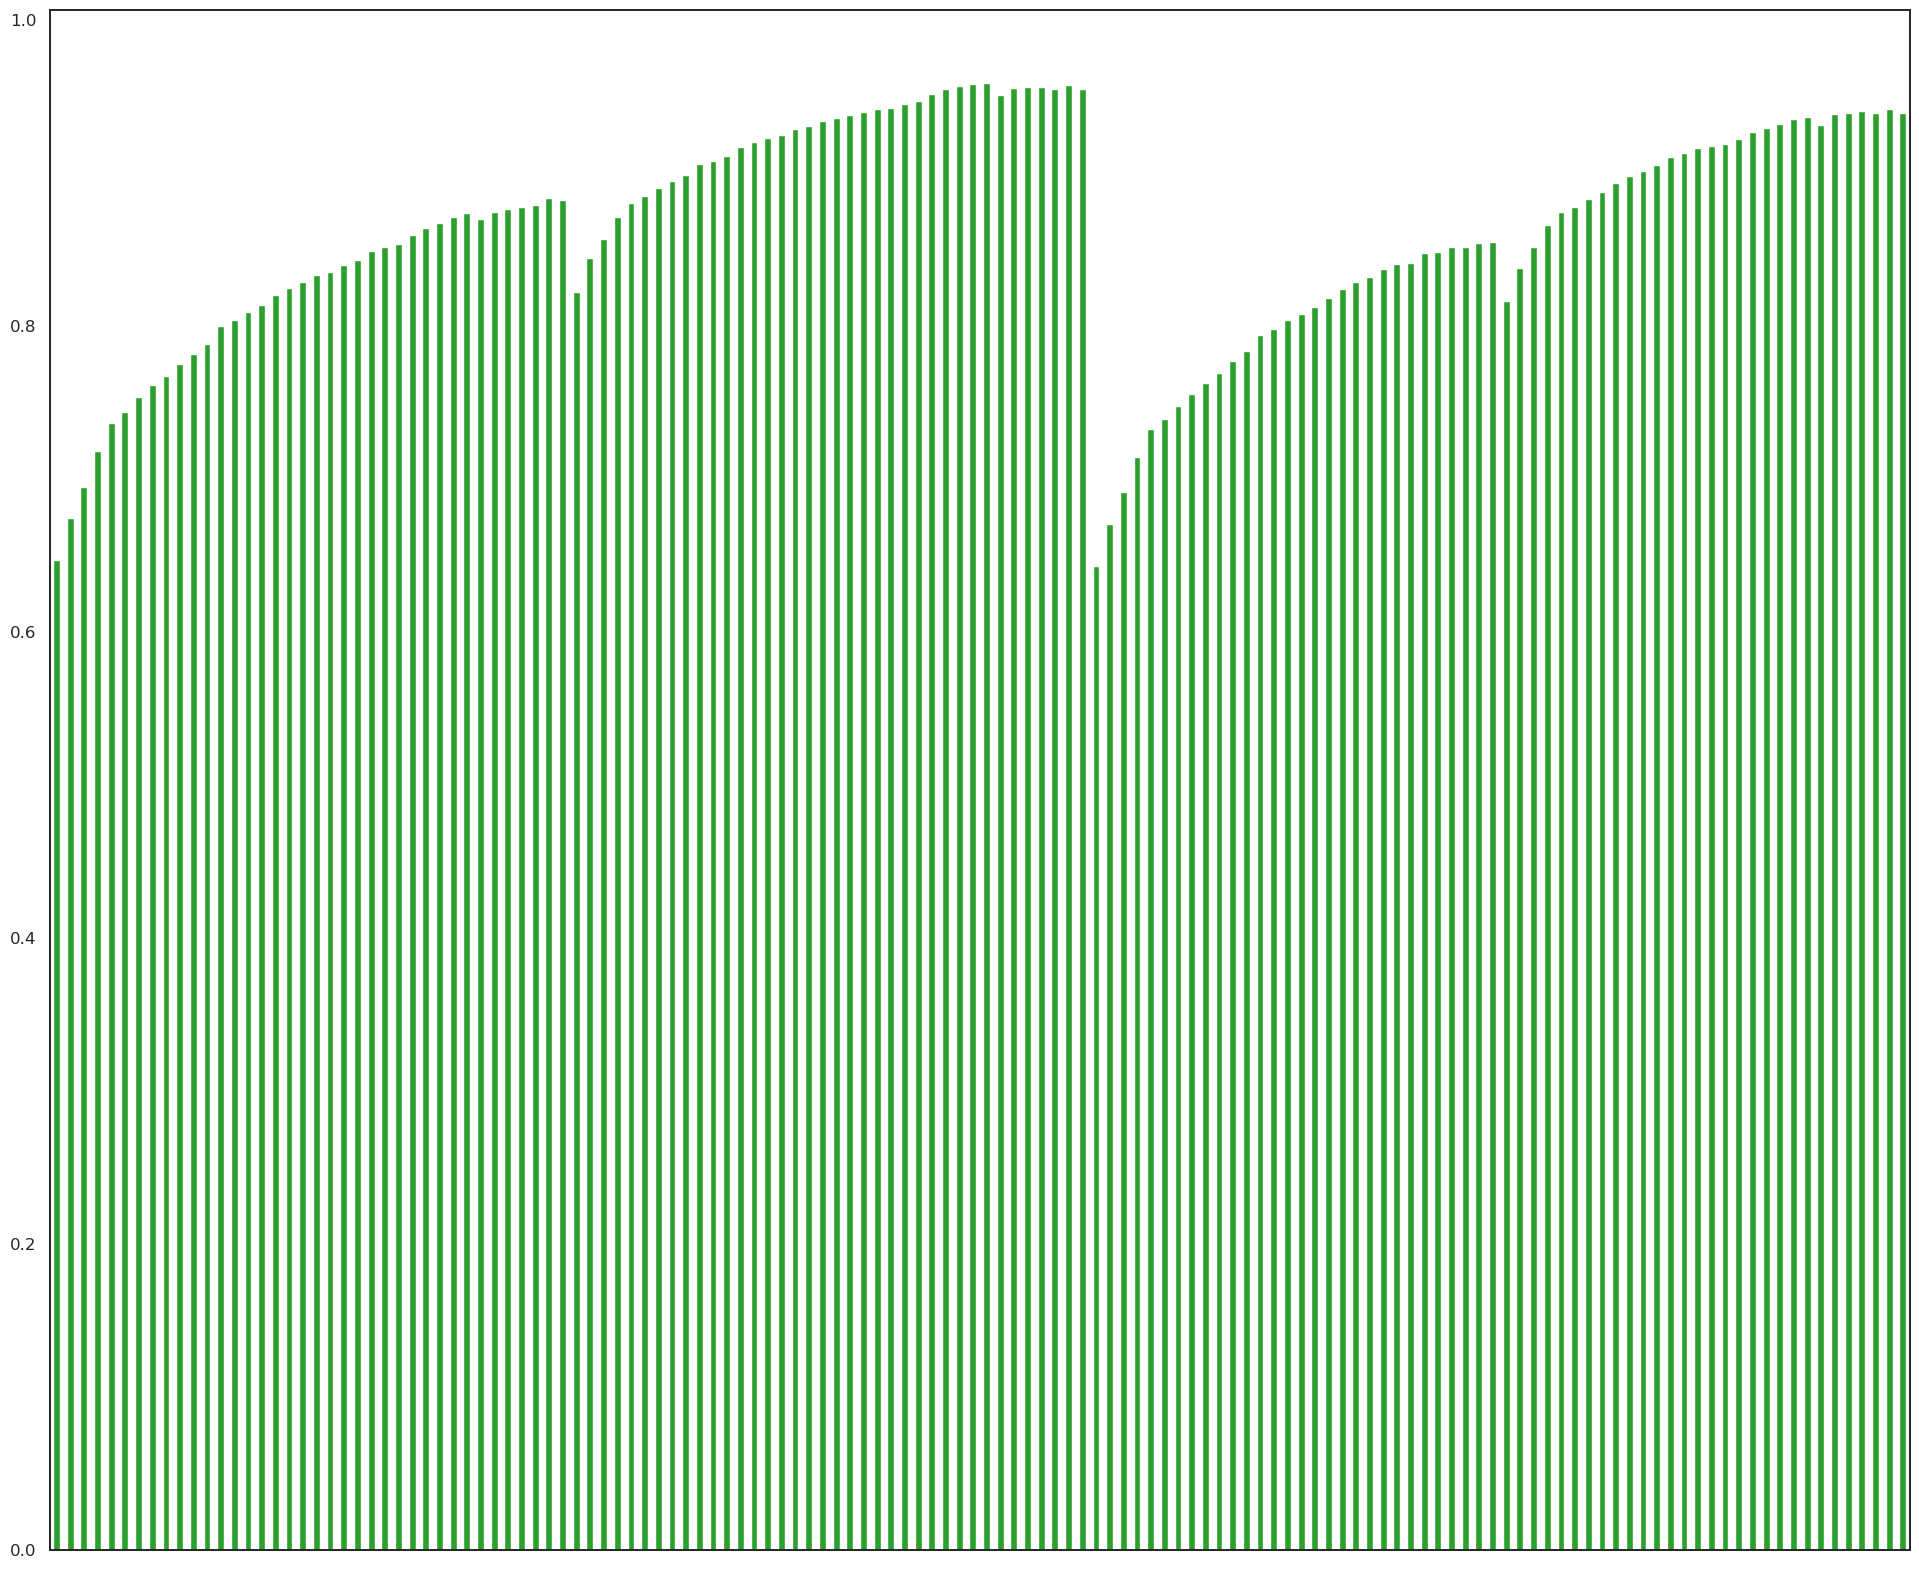

In [37]:
msno.bar(tp3.iloc[:, 3:], fontsize=12, color="tab:green", figsize=(24, 20))
plt.show()

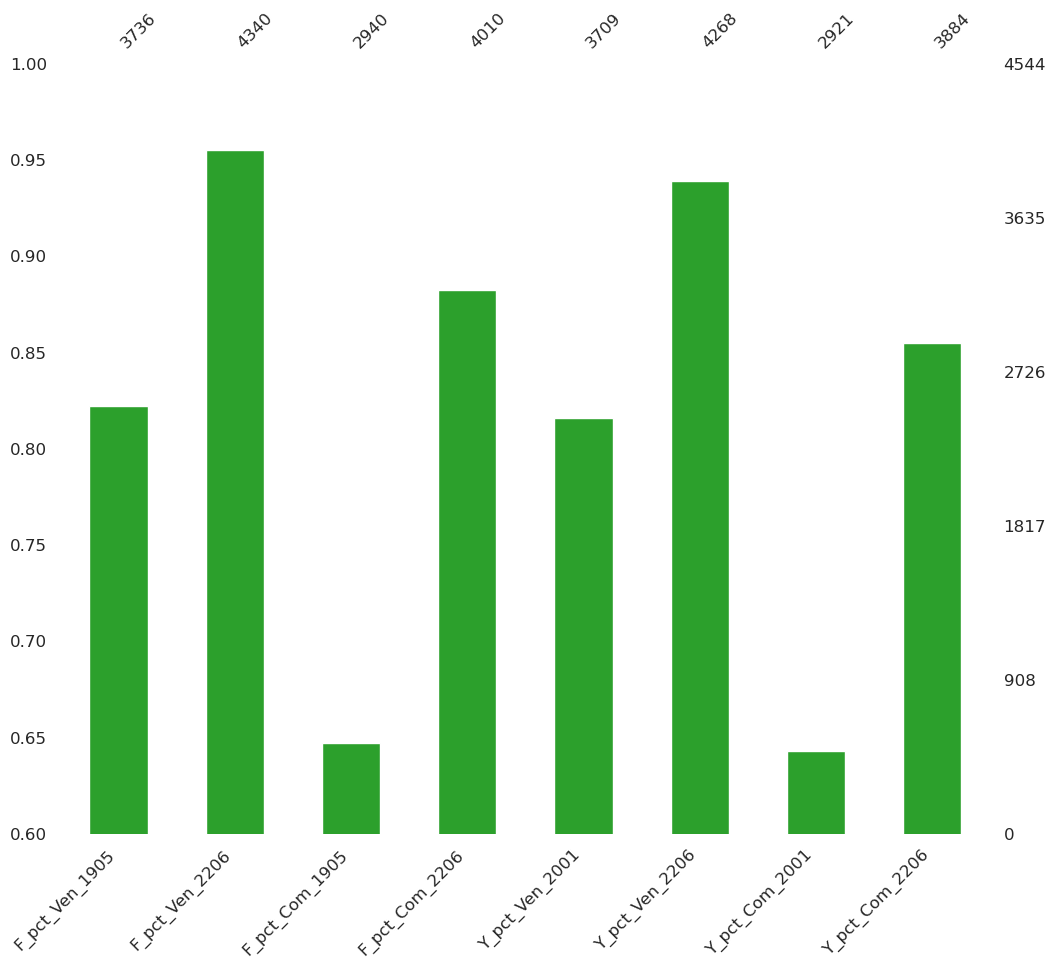

In [38]:
msno.bar(tp3[['F_pct_Ven_1905', 'F_pct_Ven_2206', 'F_pct_Com_1905', 'F_pct_Com_2206', 'Y_pct_Ven_2001', 'Y_pct_Ven_2206', 'Y_pct_Com_2001', 'Y_pct_Com_2206']], fontsize=12, color="tab:green", figsize=(12, 10))
plt.ylim(0.6, 1)
plt.show()

Por lo antes dicho, seguiremos el análisis con la ventas intercuatrimestrales.

In [39]:
basics = ['ID', 'Subrubro', 'Modelo']

F_Ven = ['F_pct_Ven_1905', 'F_pct_Ven_1906', 'F_pct_Ven_1907', 'F_pct_Ven_1908', 
         'F_pct_Ven_1909', 'F_pct_Ven_1910', 'F_pct_Ven_1911', 'F_pct_Ven_1912',
         'F_pct_Ven_2001', 'F_pct_Ven_2002', 'F_pct_Ven_2003', 'F_pct_Ven_2004',
         'F_pct_Ven_2005', 'F_pct_Ven_2006', 'F_pct_Ven_2007', 'F_pct_Ven_2008',
         'F_pct_Ven_2009', 'F_pct_Ven_2010', 'F_pct_Ven_2011', 'F_pct_Ven_2012',
         'F_pct_Ven_2101', 'F_pct_Ven_2102', 'F_pct_Ven_2103', 'F_pct_Ven_2104',
         'F_pct_Ven_2105', 'F_pct_Ven_2106', 'F_pct_Ven_2107', 'F_pct_Ven_2108',
         'F_pct_Ven_2109', 'F_pct_Ven_2110', 'F_pct_Ven_2111', 'F_pct_Ven_2112',
         'F_pct_Ven_2201', 'F_pct_Ven_2202', 'F_pct_Ven_2203', 'F_pct_Ven_2204',
         'F_pct_Ven_2205', 'F_pct_Ven_2206']

tp3_Fven = tp3[basics+F_Ven].copy()

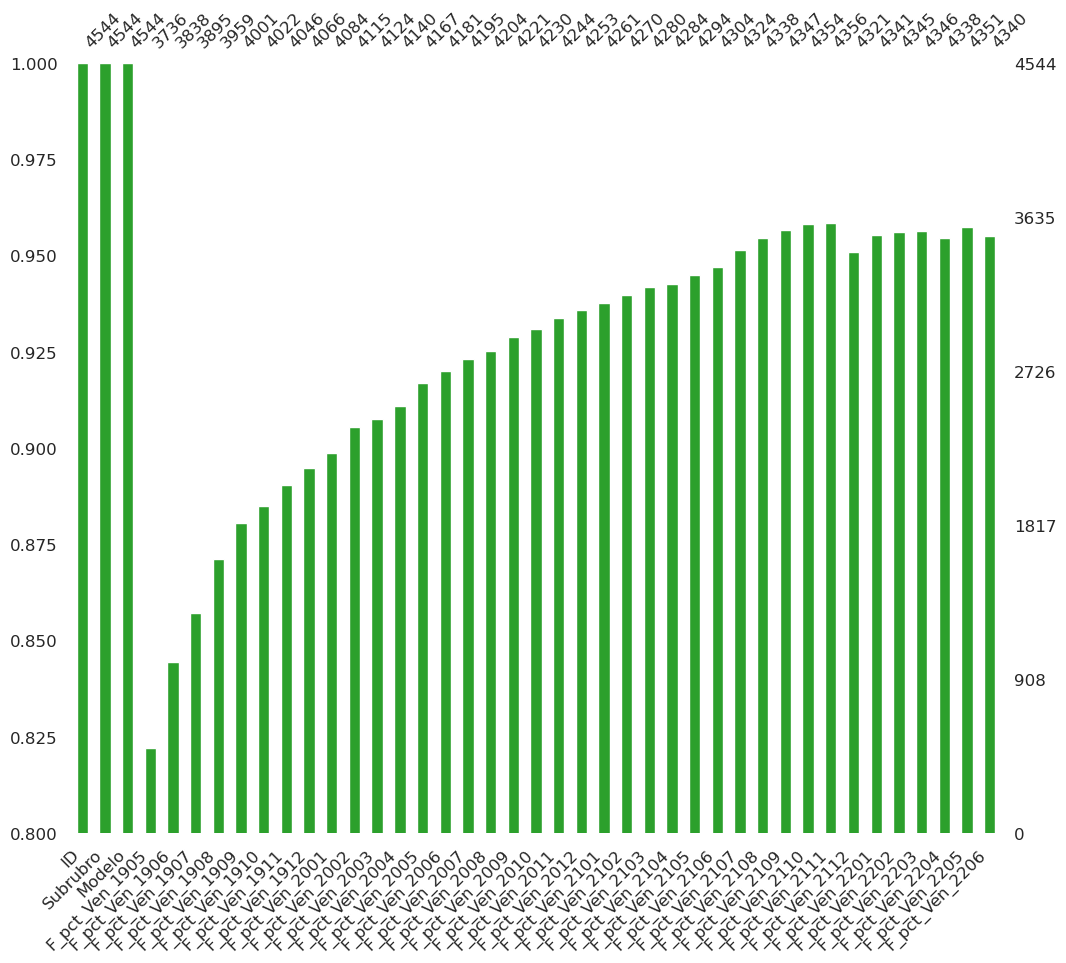

In [40]:
msno.bar(tp3_Fven, fontsize=12, color="tab:green", figsize=(12, 10))
plt.ylim(0.8, 1)
plt.show()

## Diferenciando por subrubro

Hay de todo un poco. Algunos casos presentan menos de 80% de los datos. La mayoría sigue la tendencia de ir aumentando a medida que pasa el tiempo. Algunos son más "consistentes" que otros.

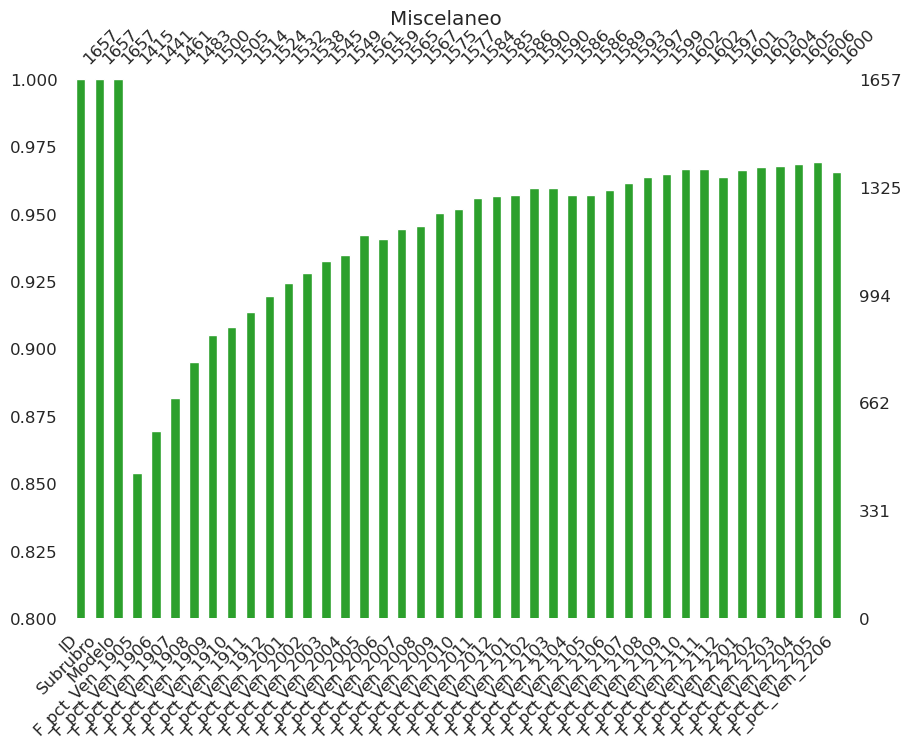

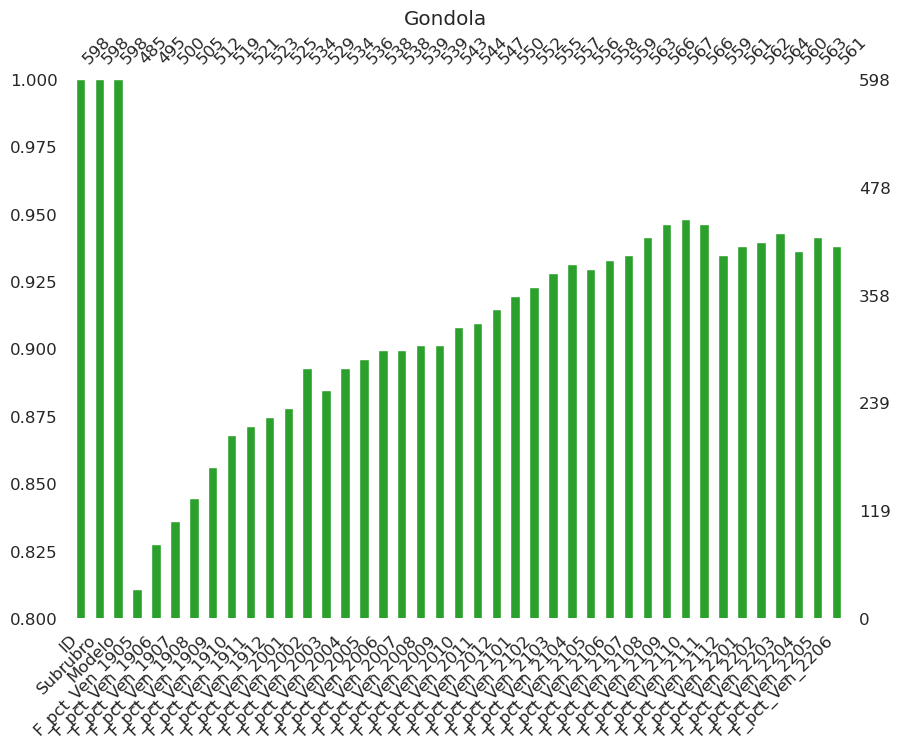

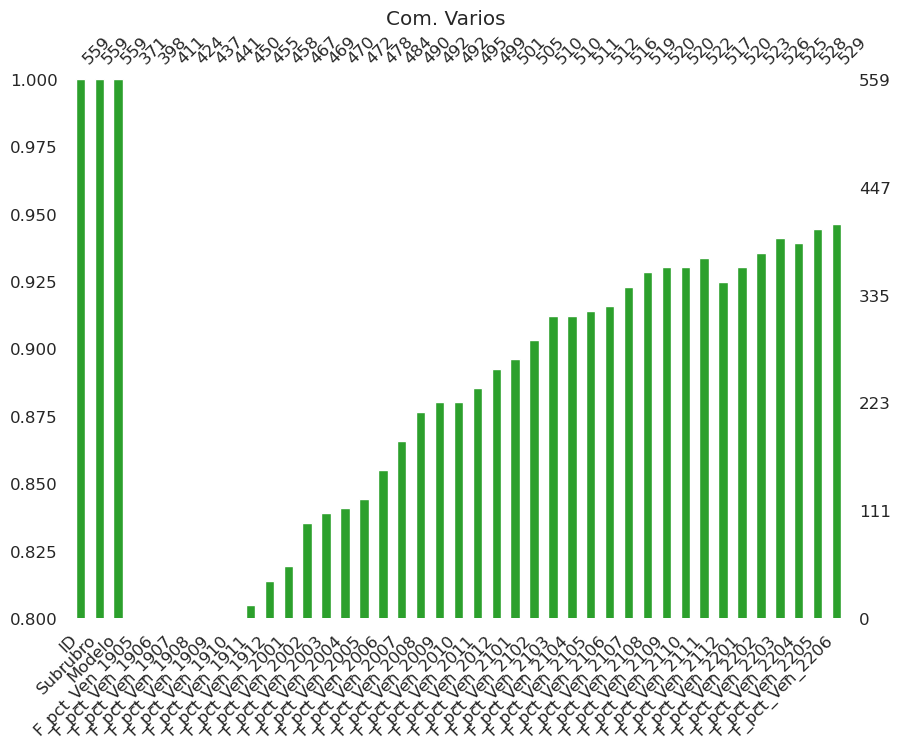

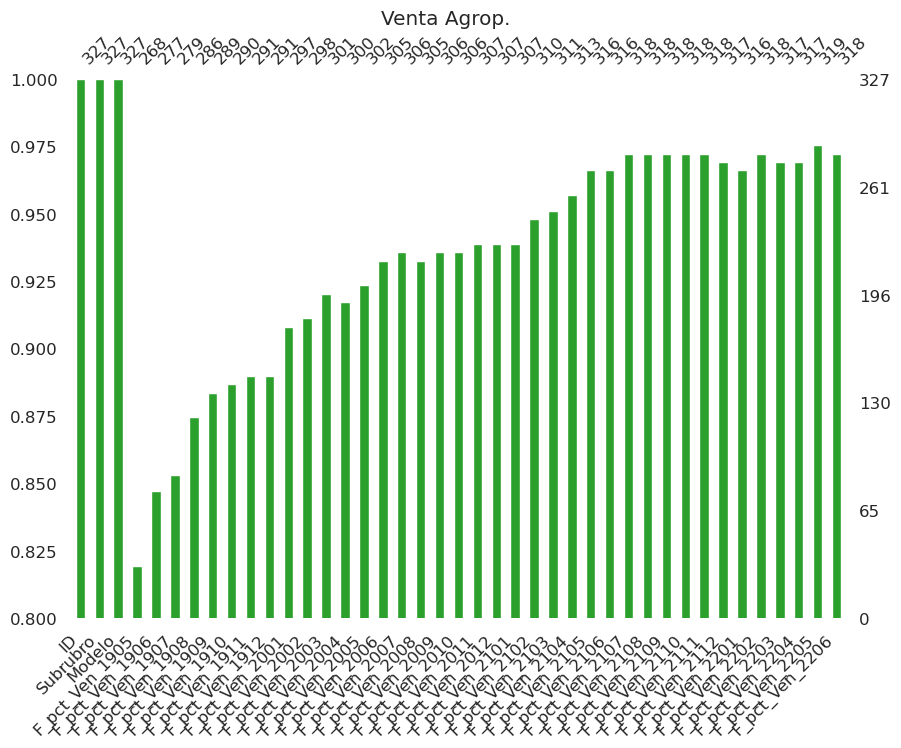

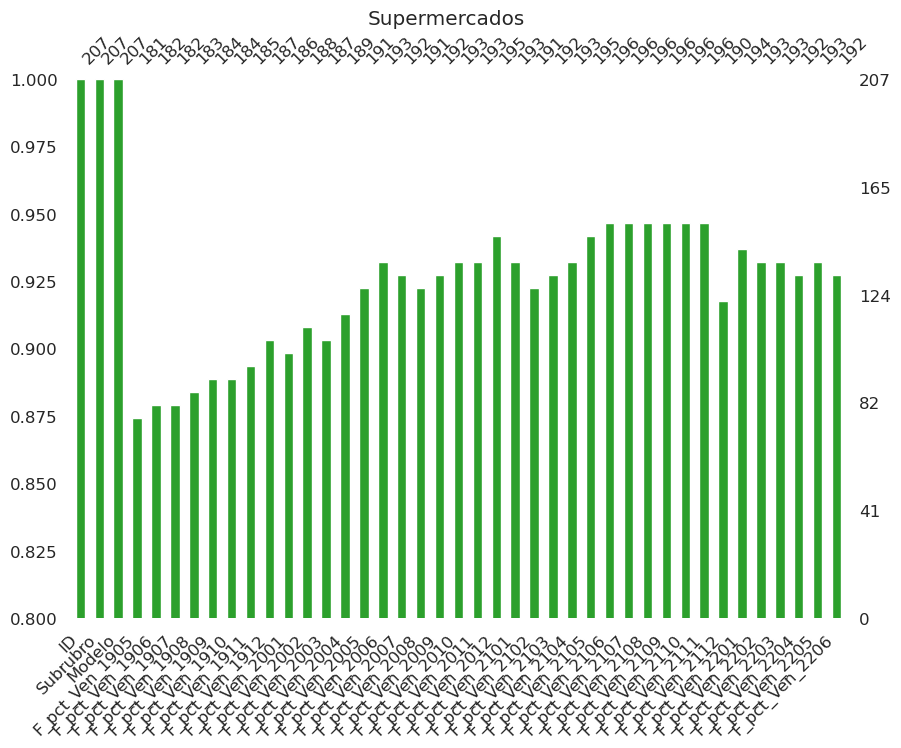

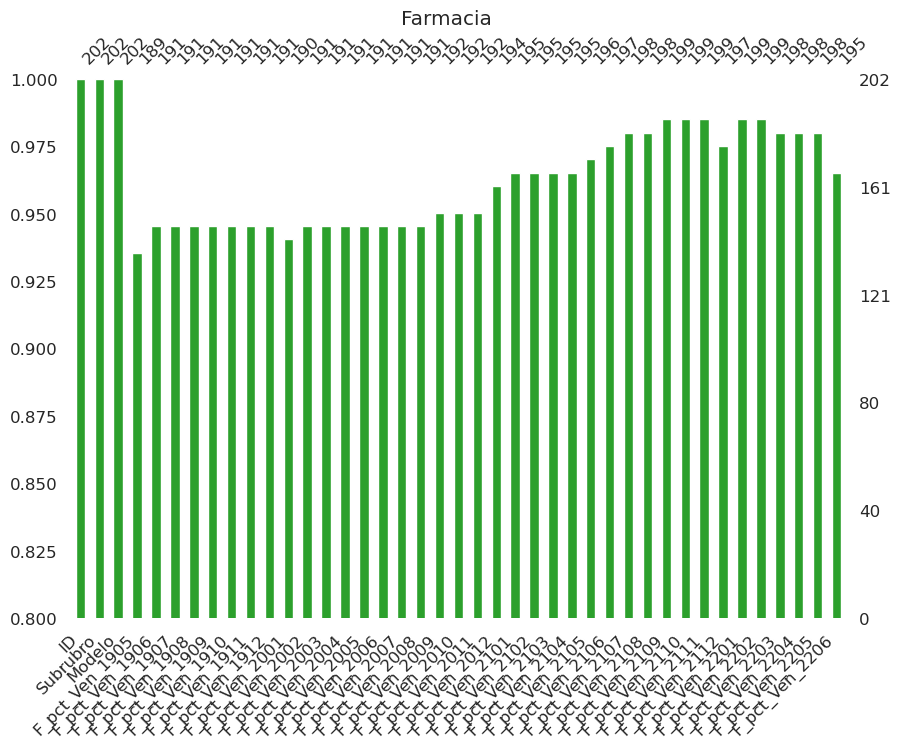

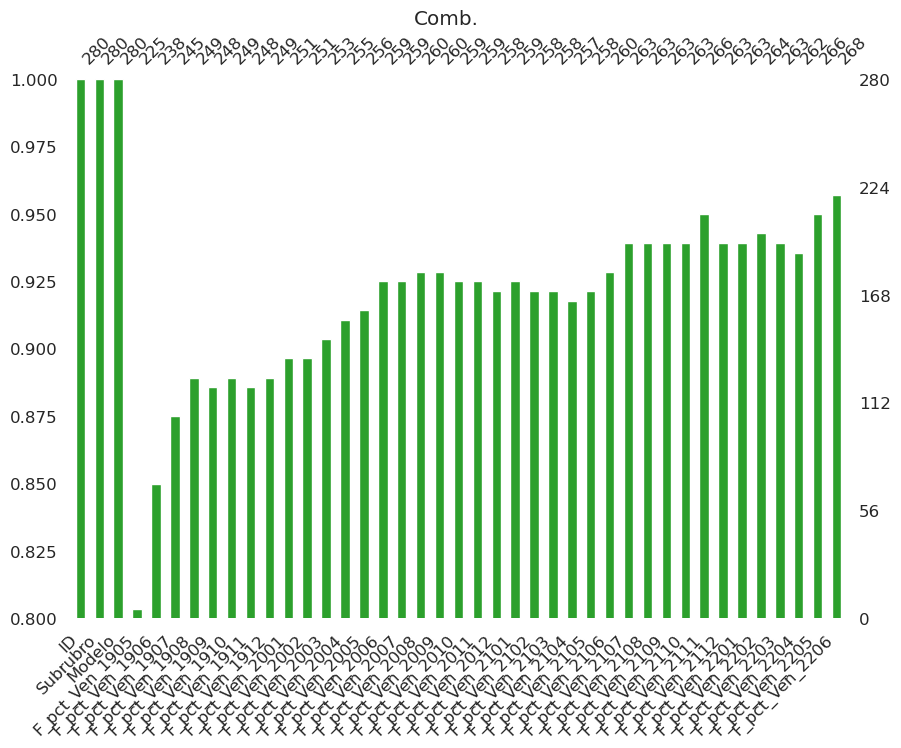

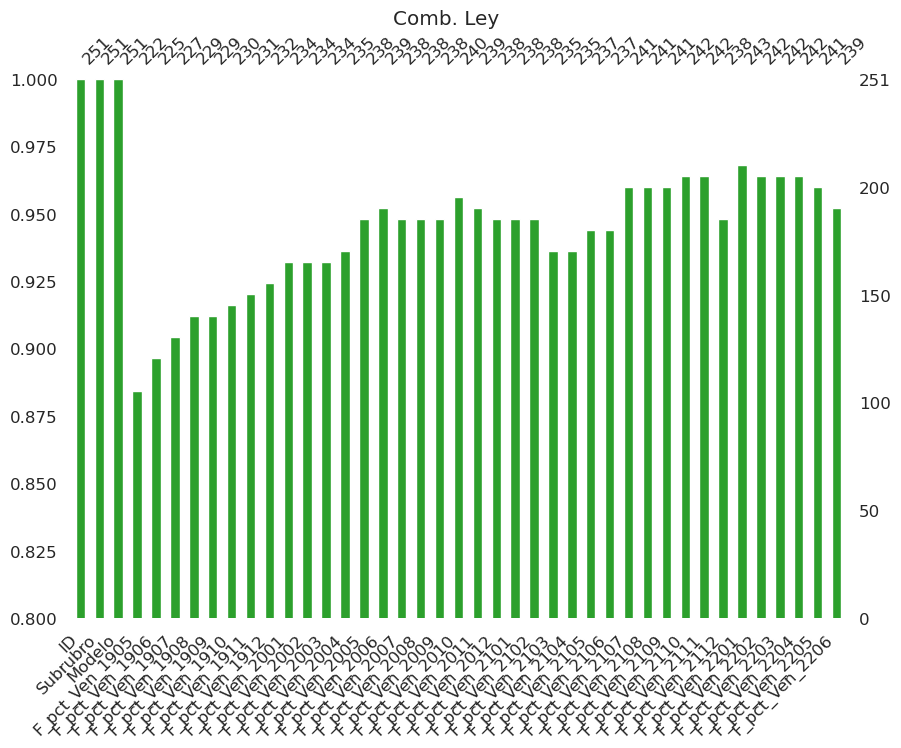

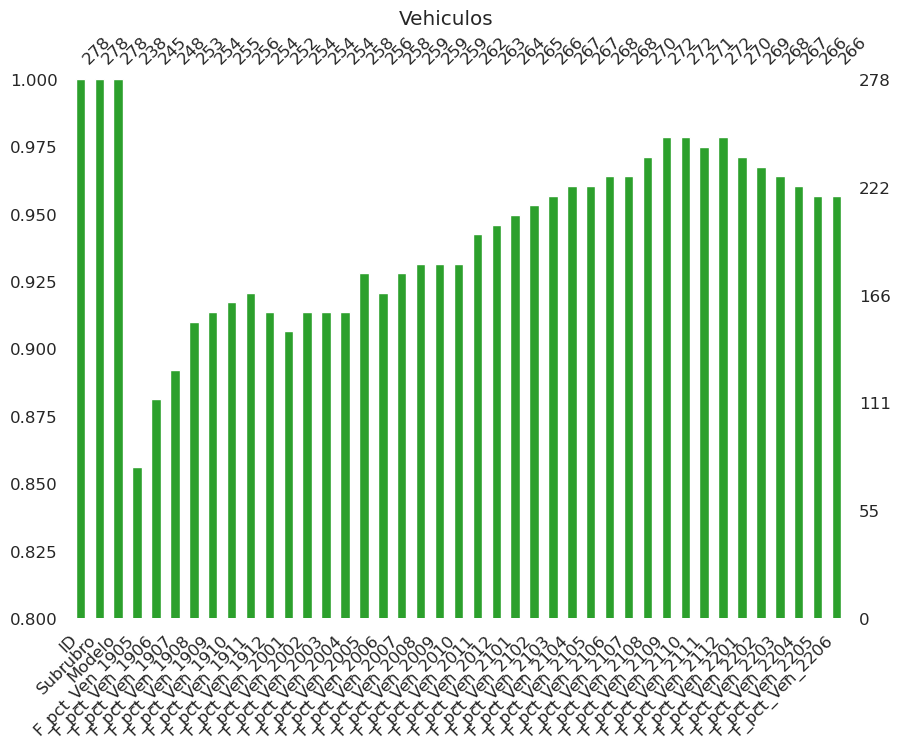

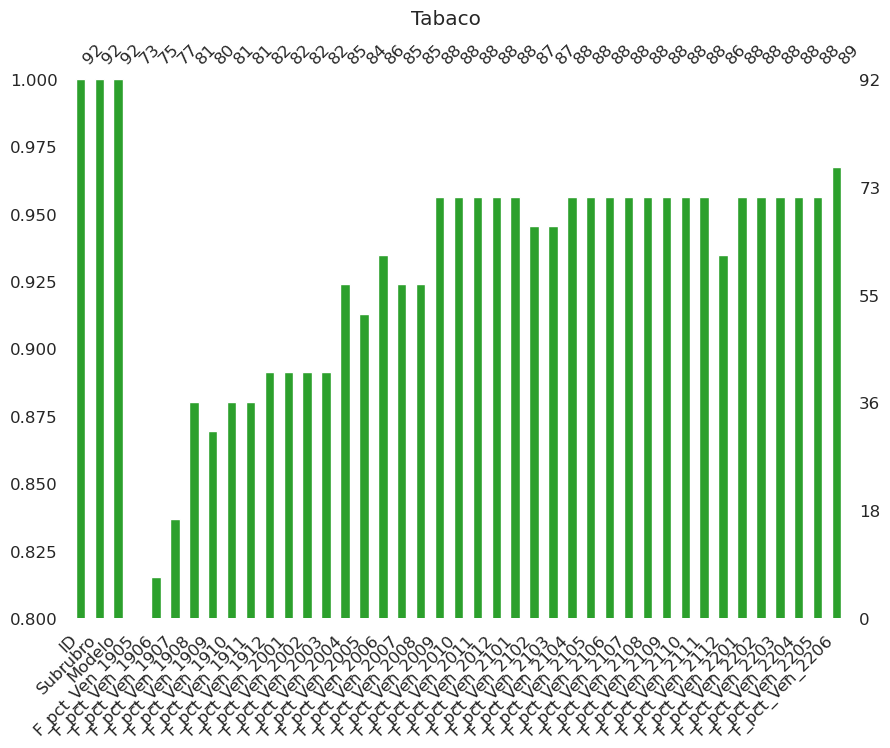

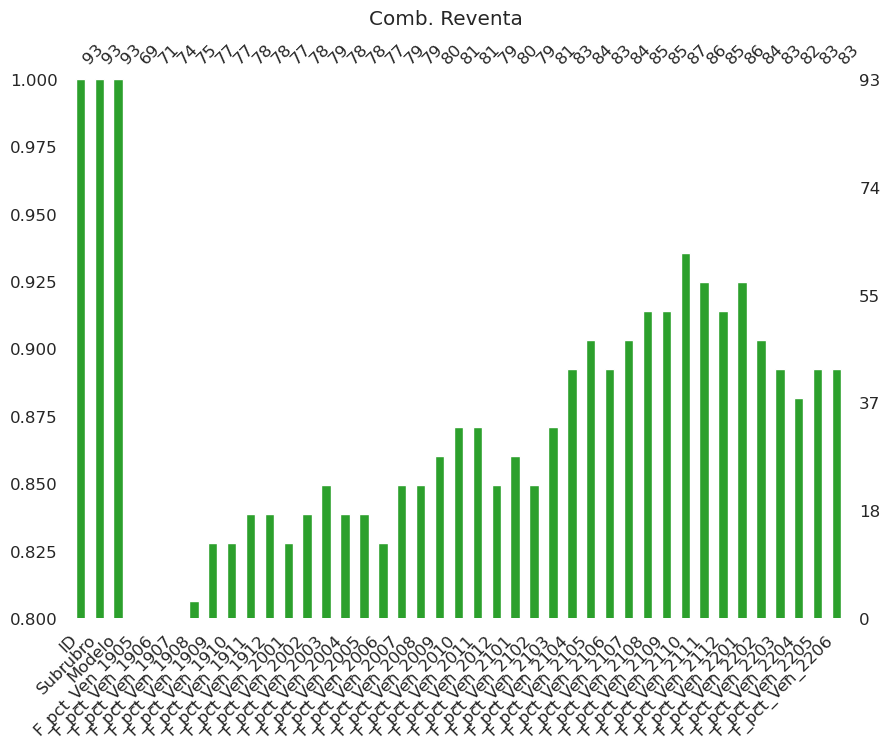

In [41]:
for sr in tp2.Subrubro.unique():

    tp3sr = tp3_Fven[tp3_Fven['Subrubro'] == sr].copy()

    plt.suptitle(sr)
    msno.bar(tp3sr, fontsize=12, color="tab:green", figsize=(10, 7))
    plt.ylim(0.8, 1)
    plt.show()

## Cantidad de vacíos por vendedor

De las 41 columnas, 3 son el `ID`, el `Subrubro` y `Modelo`. Las otras 38 corresponder a las variaciones porcentuales intercuatrimestrales. Si tomamos como aceptable un 10% de datos faltantes, podemos tolerar como máximo que haya 4 datos faltantes.

De los 4544 vendedores únicos, 3488 (el 77 %) no presentan ningún dato faltante. En el otro extremo, llegamos a tener vendedores con 37 datos faltantes, siendo que son 38 columnas. Acá hay algo raro, que debemos analizar.

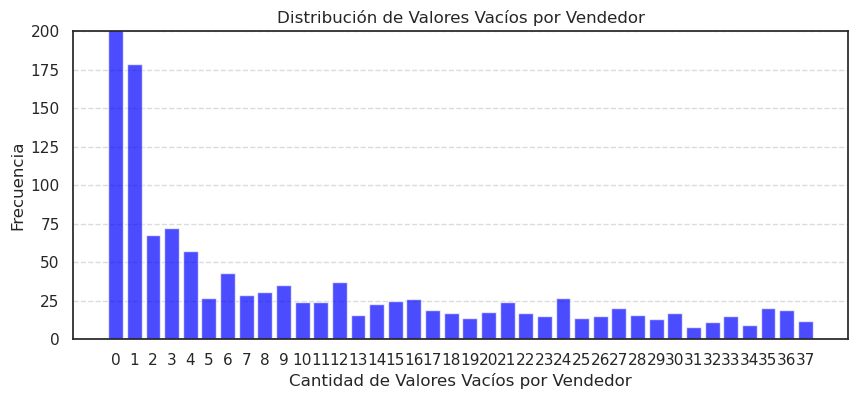

Cantidad de Valores Vacíos  Número de Filas
0                            0             3488
1                            1              179
3                            2               68
2                            3               72
4                            4               57
10                           5               27
5                            6               43
9                            7               29
8                            8               31
7                            9               35
16                          10               24
14                          11               24
6                           12               37
27                          13               16
17                          14               23
13                          15               25
12                          16               26
20                          17               19
24                          18               17
31                          19               14
22                          20               18
15                          21               24
23                          22               17
29                          23               15
11                          24               27
32                          25               14
28                          26               15
18                          27               20
26                          28               16
33                          29               13
25                          30               17
37                          31                8
35                          32               11
30                          33               15
36                          34                9
19                          35               20
21                          36               19
34                          37               12

In [42]:
# Paso 1: Contar valores vacíos por fila
vacios_por_fila = tp3_Fven.isnull().sum(axis=1)

# Paso 2: Generar un resumen de cuántas filas tienen 0, 1, 2, 3, etc., valores vacíos
resumen = vacios_por_fila.value_counts().reset_index()
resumen.columns = ['Cantidad de Valores Vacíos', 'Número de Filas']
resumen = resumen.sort_values(by='Cantidad de Valores Vacíos')

plt.figure(figsize=(10, 4))  # Tamaño del gráfico
plt.bar(resumen['Cantidad de Valores Vacíos'], resumen['Número de Filas'], color='blue', alpha=0.7)
plt.xlabel('Cantidad de Valores Vacíos por Vendedor')
plt.ylabel('Frecuencia')
plt.title('Distribución de Valores Vacíos por Vendedor')
plt.xticks(resumen['Cantidad de Valores Vacíos'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 200)

plt.show()

display(resumen)

Analicemos esto mismo, pero por subrubro. `Miscelaneo` presenta la mayor cantidad de vendedores con diferente cantidad de datos faltantes. En todos los casos hay algún vendedor con más de 30 datos faltantes.

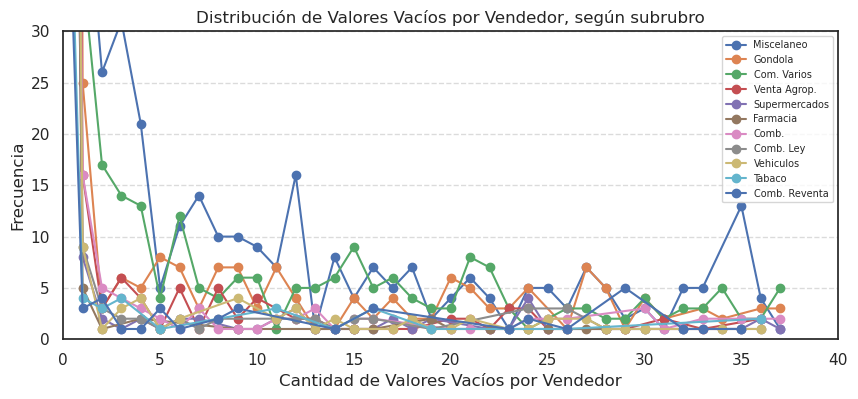

In [43]:
plt.figure(figsize=(10, 4))  # Tamaño del gráfico

for sr in tp2.Subrubro.unique():

    tp3sr = tp3_Fven[tp3_Fven['Subrubro'] == sr].copy()

    # Paso 1: Contar valores vacíos por fila
    vacios_por_fila = tp3sr.isnull().sum(axis=1)

    # Paso 2: Generar un resumen de cuántas filas tienen 0, 1, 2, 3, etc., valores vacíos
    resumen = vacios_por_fila.value_counts().reset_index()
    resumen.columns = ['Cantidad de Valores Vacíos', 'Número de Filas']
    resumen = resumen.sort_values(by='Cantidad de Valores Vacíos')

    plt.plot(resumen['Cantidad de Valores Vacíos'], resumen['Número de Filas'], label=sr, marker='o')
    
plt.xlabel('Cantidad de Valores Vacíos por Vendedor')
plt.ylabel('Frecuencia')
plt.title('Distribución de Valores Vacíos por Vendedor, según subrubro')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 30)
plt.xlim(0, 40)

plt.legend(fontsize=7)

plt.show()

Vemos que en todos los subrubros tenemos modelo (por las dudas si nos había quedado alguno sin).

In [44]:
print('Subrubro \t Cantidad de modelos')
for sr in tp2.Subrubro.unique():

    tp3sr = tp3_Fven[tp3_Fven['Subrubro'] == sr].copy()
    
    print(f"{sr} \t {tp3sr['Modelo'].sum()}")

Subrubro 	 Cantidad de modelos
Miscelaneo 	 20
Gondola 	 3
Com. Varios 	 4
Venta Agrop. 	 1
Supermercados 	 4
Farmacia 	 4
Comb. 	 6
Comb. Ley 	 4
Vehiculos 	 2
Tabaco 	 5
Comb. Reventa 	 1


Vamos a repetir la gráfica de valores faltantes por subrubro, pero ahora tomando únicamente a los modelo. Sólo se grafican aquellos subrubros donde algún modelo posee al menos 1 dato  faltante. Estos subrubros resultaron ser: `Comb.`, `Supermercados`, `Comb. Ley`, `Vehiculos` y `Tabaco`. Los últimos 4 casos presentan modelos con una cantidad de datos faltantes muy por encima del valor tolerable.

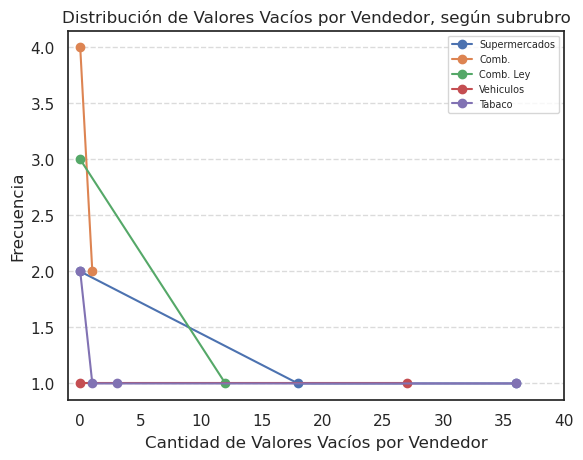

In [45]:
for sr in tp2.Subrubro.unique():

    tp3sr = tp3_Fven[(tp3_Fven['Modelo'] == 1) & (tp3_Fven['Subrubro'] == sr)].copy()

    # Paso 1: Contar valores vacíos por fila
    vacios_por_fila = tp3sr.isnull().sum(axis=1)

    # Paso 2: Generar un resumen de cuántas filas tienen 0, 1, 2, 3, etc., valores vacíos
    resumen = vacios_por_fila.value_counts().reset_index()
    resumen.columns = ['Cantidad de Valores Vacíos', 'Número de Filas']
    resumen = resumen.sort_values(by='Cantidad de Valores Vacíos')
    if len(resumen) > 1:
        plt.plot(resumen['Cantidad de Valores Vacíos'], resumen['Número de Filas'], label=sr, marker='o')
    
plt.xlabel('Cantidad de Valores Vacíos por Vendedor')
plt.ylabel('Frecuencia')
plt.title('Distribución de Valores Vacíos por Vendedor, según subrubro')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(-1, 40)

plt.legend(fontsize=7)

plt.show()

Vamos a identificar a estos modelos con datos faltantes y corroborar si no es que pertenecen a más de un subrubro. Esto explicaría el porque de que aparezcan con datos faltantes en algún rubro.

Tomamos las siguientes decisiones
+ Eliminar al vendedor 306 de `Supermercados` y `Tabaco`, ya que sólo tiene 2 datos al principio.
+ Los 12 NaN del vendedor 494 correspoden a que vendía sólo en `Comb.` y con el tiempo empezó a vender también en `Comb. Ley`. Por este motivo no se lo elimina, sino que se lo imputará de alguna manera.
+ El vendedor 496 presenta un único dato faltante en dos de tres subrubros. Se lo imputará de alguna manera.
+ El vendedor 599 presenta 3 datos faltantes en uno de sus subrubros. Se lo imputará de alguna manera.
+ El vendedor 798 presenta 27 datos faltantes en `Vehiculos` y entre los 11 valores que no son NaN, solo hay 4 que son no nulos. Se lo elimina de esta categoría.
+ El vendedor 891 presenta un único dato faltante en un subrubro. Se lo imputará de alguna manera.

In [46]:
# Busco los ID que tienen datos faltantes
ids = []
for sr in ['Supermercados', 'Comb.', 'Comb. Ley', 'Vehiculos', 'Tabaco']:

    tp3sr = tp3_Fven[(tp3_Fven['Modelo'] == 1) & (tp3_Fven['Subrubro'] == sr)]['ID'].copy()
    for k in tp3sr:
        ids.append(k)

ids = np.unique(np.array(ids))

for k in ids:
    tp3sr = tp3_Fven[(tp3_Fven['ID'] == k)].copy()
    vacios_por_fila = tp3sr.isnull().sum(axis=1)
    resumen = vacios_por_fila.value_counts().reset_index()
    resumen.columns = ['Cantidad de Valores Vacíos', 'Número de Filas']
    resumen = resumen.sort_values(by='Cantidad de Valores Vacíos')
    if len(resumen) > 1:
        print(f'\n\nVendedor {k}:')
        display(tp3sr)
        display(resumen)

# for sr in tp2.Subrubro.unique():

#     tp3sr = tp3_Fven[(tp3_Fven['Modelo'] == 1) & (tp3_Fven['Subrubro'] == sr)].copy()

#     # Paso 1: Contar valores vacíos por fila
#     vacios_por_fila = tp3sr.isnull().sum(axis=1)

#     # Paso 2: Generar un resumen de cuántas filas tienen 0, 1, 2, 3, etc., valores vacíos
#     resumen = vacios_por_fila.value_counts().reset_index()
#     resumen.columns = ['Cantidad de Valores Vacíos', 'Número de Filas']
#     resumen = resumen.sort_values(by='Cantidad de Valores Vacíos')
#     if len(resumen) > 1:
#         plt.plot(resumen['Cantidad de Valores Vacíos'], resumen['Número de Filas'], label=sr, marker='o')
    
# plt.xlabel('Cantidad de Valores Vacíos por Vendedor')
# plt.ylabel('Frecuencia')
# plt.title('Distribución de Valores Vacíos por Vendedor, según subrubro')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.xlim(-1, 40)

# plt.legend(fontsize=7)

# plt.show()



Vendedor 306:


ID       Subrubro  Modelo  F_pct_Ven_1905  F_pct_Ven_1906   
480  306    Com. Varios       1       -0.495664       -0.245922  \
481  306          Comb.       1       -0.092596       -0.060213   
482  306     Miscelaneo       1       -0.425721       -0.083162   
483  306  Supermercados       1       -0.527417       -0.538135   
484  306         Tabaco       1       -0.275271       -0.444455   

     F_pct_Ven_1907  F_pct_Ven_1908  F_pct_Ven_1909  F_pct_Ven_1910   
480       -0.028127       -0.416119        0.164137        0.204448  \
481        0.053533       -0.000182       -0.105085       -0.001438   
482        4.236186       -0.309724        0.060256       -0.134849   
483             NaN             NaN             NaN             NaN   
484             NaN             NaN             NaN             NaN   

     F_pct_Ven_1911  F_pct_Ven_1912  F_pct_Ven_2001  F_pct_Ven_2002   
480        0.300149        1.153867        0.254681        0.084570  \
481       -0.069625        0.076039        0.246135        0.122198   
482       -0.811946        0.389102        0.596819        0.397699   
483             NaN             NaN             NaN             NaN   
484             NaN             NaN             NaN             NaN   

     F_pct_Ven_2003  F_pct_Ven_2004  F_pct_Ven_2005  F_pct_Ven_2006   
480       -0.717859       -0.919327       -0.929037       -0.597152  \
481       -0.363343       -0.786711       -0.901123       -0.544555   
482       -0.066822       -0.344028       -0.488041       -0.398303   
483             NaN             NaN             NaN             NaN   
484             NaN             NaN             NaN             NaN   

     F_pct_Ven_2007  F_pct_Ven_2008  F_pct_Ven_2009  F_pct_Ven_2010   
480       -0.034352        3.002629        8.654665        1.190492  \
481       -0.069063        1.253884        3.693492        0.259242   
482       -0.076379        0.092214        0.224948        0.084648   
483             NaN             NaN             NaN             NaN   
484             NaN             NaN             NaN             NaN   

     F_pct_Ven_2011  F_pct_Ven_2012  F_pct_Ven_2101  F_pct_Ven_2102   
480        0.999587        1.058817        0.874394       -0.253307  \
481        0.377280        0.821749        0.962296        0.496044   
482        0.330969        1.039170        0.413257        0.527746   
483             NaN             NaN             NaN             NaN   
484             NaN             NaN             NaN             NaN   

     F_pct_Ven_2103  F_pct_Ven_2104  F_pct_Ven_2105  F_pct_Ven_2106   
480        0.348049        0.004273       -0.448706        0.114884  \
481        0.228534       -0.063115       -0.124485       -0.007870   
482       -0.095339       -0.359650       -0.217571       -0.324142   
483             NaN             NaN             NaN             NaN   
484             NaN             NaN             NaN             NaN   

     F_pct_Ven_2107  F_pct_Ven_2108  F_pct_Ven_2109  F_pct_Ven_2110   
480       -0.184090       -0.344033        0.131153       -0.002140  \
481        0.077006        0.168858        0.081842        0.048184   
482       -0.032946       -0.035099        0.011881        0.588995   
483             NaN             NaN             NaN             NaN   
484             NaN             NaN             NaN             NaN   

     F_pct_Ven_2111  F_pct_Ven_2112  F_pct_Ven_2201  F_pct_Ven_2202   
480       -0.147142        0.031084       -0.032954        0.389731  \
481       -0.077975       -0.089063       -0.039978        0.010688   
482        0.565820        0.378832        0.443114       -0.052967   
483             NaN             NaN             NaN             NaN   
484             NaN             NaN             NaN             NaN   

     F_pct_Ven_2203  F_pct_Ven_2204  F_pct_Ven_2205  F_pct_Ven_2206  
480        0.473385        0.783866        0.098906        0.022240  
481        0.072768       -0.023762       -0.07

Cantidad de Valores Vacíos  Número de Filas
0                           0                3
1                          36                2



Vendedor 494:


ID   Subrubro  Modelo  F_pct_Ven_1905  F_pct_Ven_1906  F_pct_Ven_1907   
774  494      Comb.       1        0.043237        0.127218        0.092752  \
775  494  Comb. Ley       1             NaN             NaN             NaN   

     F_pct_Ven_1908  F_pct_Ven_1909  F_pct_Ven_1910  F_pct_Ven_1911   
774         0.09427       -0.041805        0.023054       -0.066931  \
775             NaN             NaN             NaN             NaN   

     F_pct_Ven_1912  F_pct_Ven_2001  F_pct_Ven_2002  F_pct_Ven_2003   
774        0.008699       -0.739867       -0.763125       -0.808191  \
775             NaN             NaN             NaN             NaN   

     F_pct_Ven_2004  F_pct_Ven_2005  F_pct_Ven_2006  F_pct_Ven_2007   
774       -0.906968       -0.429497       -0.303181        0.003273  \
775             NaN       -0.489179       -0.295398        0.019871   

     F_pct_Ven_2008  F_pct_Ven_2009  F_pct_Ven_2010  F_pct_Ven_2011   
774        0.803908        0.166009        0.150956        0.070140  \
775        1.312431        0.935213        0.138073        0.089751   

     F_pct_Ven_2012  F_pct_Ven_2101  F_pct_Ven_2102  F_pct_Ven_2103   
774        0.360934        0.311801        0.035943        0.198844  \
775        0.353801       -0.075637        0.170539        0.239201   

     F_pct_Ven_2104  F_pct_Ven_2105  F_pct_Ven_2106  F_pct_Ven_2107   
774       -0.068396        0.106672       -0.013751       -0.000932  \
775       -0.090561       -0.072983       -0.112773       -0.083630   

     F_pct_Ven_2108  F_pct_Ven_2109  F_pct_Ven_2110  F_pct_Ven_2111   
774        0.116418        0.016813        0.222013       -0.081615  \
775        0.006750        0.101409        0.195834       -0.011147   

     F_pct_Ven_2112  F_pct_Ven_2201  F_pct_Ven_2202  F_pct_Ven_2203   
774       -0.175919       -0.238453       -0.226108         0.03426  \
775       -0.009421       -0.233487       -0.193986        -0.03531   

     F_pct_Ven_2204  F_pct_Ven_2205  F_pct_Ven_2206  
774        0.051446        0.264477        0.257926  
775       -0.108430        0.278361        0.286894

Cantidad de Valores Vacíos  Número de Filas
0                           0                1
1                          12                1



Vendedor 496:


ID       Subrubro  Modelo  F_pct_Ven_1905  F_pct_Ven_1906   
777  496          Comb.       1       -0.149148       -0.594586  \
778  496      Comb. Ley       1       -0.040622       -0.066164   
779  496  Comb. Reventa       1       -0.312375        0.102973   

     F_pct_Ven_1907  F_pct_Ven_1908  F_pct_Ven_1909  F_pct_Ven_1910   
777       -0.030384       -0.165971        3.257126        1.132844  \
778       -0.156172       -0.053055       -0.803696       -0.019423   
779        1.188790        0.021662        0.006591        0.236371   

     F_pct_Ven_1911  F_pct_Ven_1912  F_pct_Ven_2001  F_pct_Ven_2002   
777       -0.121567        0.135307       -0.824351       -0.157616  \
778        0.059342       -0.022457        3.260781       -0.110178   
779        0.525786        0.122524       -0.325730       -0.781332   

     F_pct_Ven_2003  F_pct_Ven_2004  F_pct_Ven_2005  F_pct_Ven_2006   
777       -0.353409       -0.686805       -0.474727       -0.284149  \
778       -0.405148       -0.730765       -0.558478       -0.506094   
779       -0.367471       -0.883986       -0.945466       -0.754624   

     F_pct_Ven_2007  F_pct_Ven_2008  F_pct_Ven_2009  F_pct_Ven_2010   
777        0.048950        0.693196        0.172200        0.081819  \
778       -0.219190        1.672742        0.293336       -0.021271   
779       -0.933428        4.875700        4.776288       12.629024   

     F_pct_Ven_2011  F_pct_Ven_2012  F_pct_Ven_2101  F_pct_Ven_2102   
777        0.057175        0.420135        0.316610        0.052971  \
778       -0.074636       -0.252638        0.029018        0.052114   
779       12.629024       -0.111543        1.178816       -0.076568   

     F_pct_Ven_2103  F_pct_Ven_2104  F_pct_Ven_2105  F_pct_Ven_2106   
777        0.193159       -0.086681        0.213973        0.110462  \
778        0.146208       -0.098991       -0.115089       -0.174683   
779       -0.076568       -0.600290       -0.580880       -0.580880   

     F_pct_Ven_2107  F_pct_Ven_2108  F_pct_Ven_2109  F_pct_Ven_2110   
777       -0.064802        0.005188       -0.121892       -0.004459  \
778       -0.185271       -0.064329        0.010077        0.388343   
779       -0.580880        1.497749        1.382071        0.152161   

     F_pct_Ven_2111  F_pct_Ven_2112  F_pct_Ven_2201  F_pct_Ven_2202   
777       -0.066114       -0.015682       -0.114979       -0.180420  \
778        0.031275        0.164766       -0.069192       -0.237014   
779        0.943357        0.215463       -0.486671       -0.049632   

     F_pct_Ven_2203  F_pct_Ven_2204  F_pct_Ven_2205  F_pct_Ven_2206  
777        0.023363             NaN       -0.075831        0.264016  
778        0.133980       -0.035696        0.322761        0.832276  
779        0.601686             NaN        0.390352        2.548794

Cantidad de Valores Vacíos  Número de Filas
1                           0                1
0                           1                2



Vendedor 599:


ID    Subrubro  Modelo  F_pct_Ven_1905  F_pct_Ven_1906  F_pct_Ven_1907   
940  599  Miscelaneo       1        -0.13917       -0.283775        0.310207  \
941  599      Tabaco       1             NaN             NaN             NaN   

     F_pct_Ven_1908  F_pct_Ven_1909  F_pct_Ven_1910  F_pct_Ven_1911   
940         0.00731       -0.262844       -0.062519       -0.309449  \
941         0.04393       -0.138290        0.520342       -0.161716   

     F_pct_Ven_1912  F_pct_Ven_2001  F_pct_Ven_2002  F_pct_Ven_2003   
940        0.210940        0.099178        1.075333       -0.334298  \
941        0.017244       -0.273390       -0.277418       -0.199979   

     F_pct_Ven_2004  F_pct_Ven_2005  F_pct_Ven_2006  F_pct_Ven_2007   
940       -0.618173        0.402425       -0.322572        1.418767  \
941       -0.199979       -0.009966       -0.027218       -0.120019   

     F_pct_Ven_2008  F_pct_Ven_2009  F_pct_Ven_2010  F_pct_Ven_2011   
940        1.881204        0.032476        0.201775        0.229984  \
941       -0.120019        0.203379       -0.375780        0.080798   

     F_pct_Ven_2012  F_pct_Ven_2101  F_pct_Ven_2102  F_pct_Ven_2103   
940        1.526002        0.020474       -0.351393       -0.310312  \
941       -0.021080       -0.030486        0.407485        0.794848   

     F_pct_Ven_2104  F_pct_Ven_2105  F_pct_Ven_2106  F_pct_Ven_2107   
940       -0.524599        0.516977        0.574898        0.577210  \
941        1.294692        0.646885        1.007266       -0.149233   

     F_pct_Ven_2108  F_pct_Ven_2109  F_pct_Ven_2110  F_pct_Ven_2111   
940        0.557839       -0.440644       -0.299072       -0.387014  \
941       -0.529258       -0.499573       -0.568425       -0.543848   

     F_pct_Ven_2112  F_pct_Ven_2201  F_pct_Ven_2202  F_pct_Ven_2203   
940        0.812498        0.659130        0.678302        0.470556  \
941       -0.311866        0.088256        0.530730        2.408301   

     F_pct_Ven_2204  F_pct_Ven_2205  F_pct_Ven_2206  
940       -0.793698        0.064398        0.244375  
941        1.678053        0.534493        0.675483

Cantidad de Valores Vacíos  Número de Filas
0                           0                1
1                           3                1



Vendedor 798:


ID    Subrubro  Modelo  F_pct_Ven_1905  F_pct_Ven_1906  F_pct_Ven_1907   
1245  798  Miscelaneo       1       -0.123301         0.30535        0.716482  \
1246  798   Vehiculos       1             NaN             NaN             NaN   

      F_pct_Ven_1908  F_pct_Ven_1909  F_pct_Ven_1910  F_pct_Ven_1911   
1245        0.122014        0.004664        0.170964       -0.175865  \
1246             NaN             NaN             NaN             NaN   

      F_pct_Ven_1912  F_pct_Ven_2001  F_pct_Ven_2002  F_pct_Ven_2003   
1245        0.545788        0.214613       -0.305607       -0.399103  \
1246             NaN             NaN             NaN             NaN   

      F_pct_Ven_2004  F_pct_Ven_2005  F_pct_Ven_2006  F_pct_Ven_2007   
1245       -0.458571        0.424409        1.110977        1.393062  \
1246             NaN             NaN             NaN             NaN   

      F_pct_Ven_2008  F_pct_Ven_2009  F_pct_Ven_2010  F_pct_Ven_2011   
1245        0.928032        -0.52203        0.052312       -0.039483  \
1246             NaN             NaN             NaN             NaN   

      F_pct_Ven_2012  F_pct_Ven_2101  F_pct_Ven_2102  F_pct_Ven_2103   
1245         0.07713        0.277343       -0.511527       -0.352926  \
1246             NaN             NaN             NaN             NaN   

      F_pct_Ven_2104  F_pct_Ven_2105  F_pct_Ven_2106  F_pct_Ven_2107   
1245       -0.492887        0.104091        0.635079        0.491623  \
1246             NaN             NaN             NaN             NaN   

      F_pct_Ven_2108  F_pct_Ven_2109  F_pct_Ven_2110  F_pct_Ven_2111   
1245        0.233772        0.095371       -0.201766        0.108925  \
1246        0.000000        0.000000        0.000000        0.122911   

      F_pct_Ven_2112  F_pct_Ven_2201  F_pct_Ven_2202  F_pct_Ven_2203   
1245        0.925464        0.426857       -0.040948       -0.122491  \
1246        0.122911        0.122911        0.122911        0.000000   

      F_pct_Ven_2204  F_pct_Ven_2205  F_pct_Ven_2206  
1245       -0.442798       -0.215688        0.292898  
1246        0.000000        0.000000        0.000000

Cantidad de Valores Vacíos  Número de Filas
0                           0                1
1                          27                1



Vendedor 891:


ID       Subrubro  Modelo  F_pct_Ven_1905  F_pct_Ven_1906   
1392  891  Supermercados       1        0.306377       -0.257703  \
1393  891         Tabaco       1             NaN       -0.161883   

      F_pct_Ven_1907  F_pct_Ven_1908  F_pct_Ven_1909  F_pct_Ven_1910   
1392       -0.355913        0.354431       -0.094963       -0.115590  \
1393       -0.151379        0.105235        0.201754        0.411029   

      F_pct_Ven_1911  F_pct_Ven_1912  F_pct_Ven_2001  F_pct_Ven_2002   
1392        0.211934        0.186710       -0.046084        0.254686  \
1393        0.425055        0.683783        0.240880        0.270083   

      F_pct_Ven_2003  F_pct_Ven_2004  F_pct_Ven_2005  F_pct_Ven_2006   
1392       -0.140467        -0.40815       -0.193580       -0.259253  \
1393       -0.091536        -0.32594       -0.535232       -0.127737   

      F_pct_Ven_2007  F_pct_Ven_2008  F_pct_Ven_2009  F_pct_Ven_2010   
1392       -0.028259        0.525892        0.230593        0.117857  \
1393       -0.126785       -0.379651        0.124064       -0.498910   

      F_pct_Ven_2011  F_pct_Ven_2012  F_pct_Ven_2101  F_pct_Ven_2102   
1392       -0.038634        0.158489       -0.228388        0.224741  \
1393       -0.371125       -0.244891       -0.244891       -0.275944   

      F_pct_Ven_2103  F_pct_Ven_2104  F_pct_Ven_2105  F_pct_Ven_2106   
1392        0.388661       -0.267289        0.132605       -0.331009  \
1393       -0.212103       -0.155584       -0.155584       -0.143836   

      F_pct_Ven_2107  F_pct_Ven_2108  F_pct_Ven_2109  F_pct_Ven_2110   
1392       -0.227018        0.053594        0.475687        0.047794  \
1393       -0.117443       -0.045714        0.136347        0.019259   

      F_pct_Ven_2111  F_pct_Ven_2112  F_pct_Ven_2201  F_pct_Ven_2202   
1392        0.218929       -0.080310       -0.290504        0.465367  \
1393       -0.017225        0.159239       -0.194740       -0.081584   

      F_pct_Ven_2203  F_pct_Ven_2204  F_pct_Ven_2205  F_pct_Ven_2206  
1392       -0.015898        0.192358        0.184155       -0.191607  
1393       -0.075973       -0.172829        0.000000        0.000000

Cantidad de Valores Vacíos  Número de Filas
0                           0                1
1                           1                1

In [47]:
tp3_Fven[['ID']].value_counts()

ID  
1474    9
1416    9
1215    9
1089    8
1987    8
       ..
1238    1
1237    1
1235    1
1234    1
3126    1
Name: count, Length: 2804, dtype: int64

In [48]:
# msno.matrix(tp3.iloc[:, 3:], fontsize=12, color=[0.5,0,0], figsize=(6, 5))
# plt.show()

In [49]:
# # Definir grupos de variables:

# basics = ['ID', 'Subrubro', 'Modelo']

# F_Com = ['F_pct_Com_1905', 'F_pct_Com_1906', 'F_pct_Com_1907', 'F_pct_Com_1908', 
#          'F_pct_Com_1909', 'F_pct_Com_1910', 'F_pct_Com_1911', 'F_pct_Com_1912',
#          'F_pct_Com_2001', 'F_pct_Com_2002', 'F_pct_Com_2003', 'F_pct_Com_2004',
#          'F_pct_Com_2005', 'F_pct_Com_2006', 'F_pct_Com_2007', 'F_pct_Com_2008',
#          'F_pct_Com_2009', 'F_pct_Com_2010', 'F_pct_Com_2011', 'F_pct_Com_2012',
#          'F_pct_Com_2101', 'F_pct_Com_2102', 'F_pct_Com_2103', 'F_pct_Com_2104',
#          'F_pct_Com_2105', 'F_pct_Com_2106', 'F_pct_Com_2107', 'F_pct_Com_2108',
#          'F_pct_Com_2109', 'F_pct_Com_2110', 'F_pct_Com_2111', 'F_pct_Com_2112',
#          'F_pct_Com_2201', 'F_pct_Com_2202', 'F_pct_Com_2203', 'F_pct_Com_2204',
#          'F_pct_Com_2205', 'F_pct_Com_2206']

# F_Ven = ['F_pct_Ven_1905', 'F_pct_Ven_1906', 'F_pct_Ven_1907', 'F_pct_Ven_1908', 
#          'F_pct_Ven_1909', 'F_pct_Ven_1910', 'F_pct_Ven_1911', 'F_pct_Ven_1912',
#          'F_pct_Ven_2001', 'F_pct_Ven_2002', 'F_pct_Ven_2003', 'F_pct_Ven_2004',
#          'F_pct_Ven_2005', 'F_pct_Ven_2006', 'F_pct_Ven_2007', 'F_pct_Ven_2008',
#          'F_pct_Ven_2009', 'F_pct_Ven_2010', 'F_pct_Ven_2011', 'F_pct_Ven_2012',
#          'F_pct_Ven_2101', 'F_pct_Ven_2102', 'F_pct_Ven_2103', 'F_pct_Ven_2104',
#          'F_pct_Ven_2105', 'F_pct_Ven_2106', 'F_pct_Ven_2107', 'F_pct_Ven_2108',
#          'F_pct_Ven_2109', 'F_pct_Ven_2110', 'F_pct_Ven_2111', 'F_pct_Ven_2112',
#          'F_pct_Ven_2201', 'F_pct_Ven_2202', 'F_pct_Ven_2203', 'F_pct_Ven_2204',
#          'F_pct_Ven_2205', 'F_pct_Ven_2206']

# Y_Com = ['Y_pct_Com_2001', 'Y_pct_Com_2002', 'Y_pct_Com_2003', 'Y_pct_Com_2004',
#          'Y_pct_Com_2005', 'Y_pct_Com_2006', 'Y_pct_Com_2007', 'Y_pct_Com_2008',
#          'Y_pct_Com_2009', 'Y_pct_Com_2010', 'Y_pct_Com_2011', 'Y_pct_Com_2012',
#          'Y_pct_Com_2101', 'Y_pct_Com_2102', 'Y_pct_Com_2103', 'Y_pct_Com_2104',
#          'Y_pct_Com_2105', 'Y_pct_Com_2106', 'Y_pct_Com_2107', 'Y_pct_Com_2108',
#          'Y_pct_Com_2109', 'Y_pct_Com_2110', 'Y_pct_Com_2111', 'Y_pct_Com_2112',
#          'Y_pct_Com_2201', 'Y_pct_Com_2202', 'Y_pct_Com_2203', 'Y_pct_Com_2204',
#          'Y_pct_Com_2205', 'Y_pct_Com_2206']

# Y_Ven = ['Y_pct_Ven_2001', 'Y_pct_Ven_2002', 'Y_pct_Ven_2003', 'Y_pct_Ven_2004',
#          'Y_pct_Ven_2005', 'Y_pct_Ven_2006', 'Y_pct_Ven_2007', 'Y_pct_Ven_2008',
#          'Y_pct_Ven_2009', 'Y_pct_Ven_2010', 'Y_pct_Ven_2011', 'Y_pct_Ven_2012',
#          'Y_pct_Ven_2101', 'Y_pct_Ven_2102', 'Y_pct_Ven_2103', 'Y_pct_Ven_2104',
#          'Y_pct_Ven_2105', 'Y_pct_Ven_2106', 'Y_pct_Ven_2107', 'Y_pct_Ven_2108',
#          'Y_pct_Ven_2109', 'Y_pct_Ven_2110', 'Y_pct_Ven_2111', 'Y_pct_Ven_2112',
#          'Y_pct_Ven_2201', 'Y_pct_Ven_2202', 'Y_pct_Ven_2203', 'Y_pct_Ven_2204',
#          'Y_pct_Ven_2205', 'Y_pct_Ven_2206']

# Tratamiento de vacíos

In [50]:
# Para que las funciones se actualicen sin tener que refrescar el kernel
%load_ext autoreload
%autoreload 2

# Funciones de visualización y curación
import pandas as pd
import json
from os.path import exists
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import linregress as LR
from scipy.stats import skew, kurtosis, skewtest, kurtosistest

# Funciones de clustering
from sklearn.cluster import KMeans, MeanShift
from sklearn import manifold, preprocessing, decomposition

# Funciones propias
from utils_limpieza import * 

# Preferencias
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows',150)
sns.set_context('talk')
sns.set_theme(style='white')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
tp3 = pd.read_csv('../data/interim/tp3_vendedores_vector.csv')
tp3 = limpiar_basic(tp3, cols_drop='Omega')

basics = ['ID', 'Subrubro', 'Modelo']

F_Ven = ['F_pct_Ven_1905', 'F_pct_Ven_1906', 'F_pct_Ven_1907', 'F_pct_Ven_1908', 
         'F_pct_Ven_1909', 'F_pct_Ven_1910', 'F_pct_Ven_1911', 'F_pct_Ven_1912',
         'F_pct_Ven_2001', 'F_pct_Ven_2002', 'F_pct_Ven_2003', 'F_pct_Ven_2004',
         'F_pct_Ven_2005', 'F_pct_Ven_2006', 'F_pct_Ven_2007', 'F_pct_Ven_2008',
         'F_pct_Ven_2009', 'F_pct_Ven_2010', 'F_pct_Ven_2011', 'F_pct_Ven_2012',
         'F_pct_Ven_2101', 'F_pct_Ven_2102', 'F_pct_Ven_2103', 'F_pct_Ven_2104',
         'F_pct_Ven_2105', 'F_pct_Ven_2106', 'F_pct_Ven_2107', 'F_pct_Ven_2108',
         'F_pct_Ven_2109', 'F_pct_Ven_2110', 'F_pct_Ven_2111', 'F_pct_Ven_2112',
         'F_pct_Ven_2201', 'F_pct_Ven_2202', 'F_pct_Ven_2203', 'F_pct_Ven_2204',
         'F_pct_Ven_2205', 'F_pct_Ven_2206']

tp3_Fven = tp3[basics+F_Ven].copy()

tp3_Fven['Vacios'] = tp3_Fven[F_Ven].isnull().sum(axis=1)

tp3_Fven

ID      Subrubro  Modelo  F_pct_Ven_1905  F_pct_Ven_1906   
0        0    Miscelaneo       0        0.580411        0.580411  \
1        1    Miscelaneo       0        0.560242        0.592999   
2        2    Miscelaneo       0        0.012719       -0.010125   
3        4       Gondola       0        0.193896        0.072714   
4        5   Com. Varios       0             NaN             NaN   
...    ...           ...     ...             ...             ...   
4539  3111       Gondola       0             NaN             NaN   
4540  3112    Miscelaneo       0             NaN             NaN   
4541  3115  Venta Agrop.       0             NaN             NaN   
4542  3116    Miscelaneo       0             NaN             NaN   
4543  3126       Gondola       0             NaN             NaN   

      F_pct_Ven_1907  F_pct_Ven_1908  F_pct_Ven_1909  F_pct_Ven_1910   
0           0.580411        0.000000        0.000000        0.000000  \
1           0.011296       -0.266983       -0.441363       -0.430089   
2           0.325712        0.167671       -0.260562        0.173718   
3          -0.055670        0.027243       -0.173982        0.008415   
4                NaN             NaN             NaN             NaN   
...              ...             ...             ...             ...   
4539             NaN             NaN             NaN             NaN   
4540             NaN             NaN             NaN             NaN   
4541             NaN             NaN             NaN             NaN   
4542             NaN             NaN             NaN             NaN   
4543             NaN             NaN             NaN             NaN   

      F_pct_Ven_1911  F_pct_Ven_1912  F_pct_Ven_2001  F_pct_Ven_2002   
0           0.000000        0.000000        0.000000        0.000000  \
1          -0.167779        1.110347        0.185458        0.176078   
2          -0.134293        0.477774        0.678065        0.010735   
3           0.003202        0.050649       -0.078214       -0.414493   
4                NaN             NaN             NaN             NaN   
...              ...             ...             ...             ...   
4539             NaN             NaN             NaN             NaN   
4540             NaN             NaN             NaN             NaN   
4541             NaN             NaN             NaN             NaN   
4542             NaN             NaN             NaN             NaN   
4543             NaN             NaN             NaN             NaN   

      F_pct_Ven_2003  F_pct_Ven_2004  F_pct_Ven_2005  F_pct_Ven_2006   
0           0.000000        0.000000        0.000000        0.000000  \
1          -0.489700       -0.664758       -0.894072        0.009338   
2          -0.388949       -0.983314       -0.636293       -0.263252   
3          -0.069101       -0.136931        0.107958        0.343828   
4                NaN             NaN             NaN             NaN   
...              ...             ...             ...             ...   
4539             NaN             NaN             NaN             NaN   
4540             NaN             NaN             NaN             NaN   
4541             NaN             NaN             NaN             NaN   
4542             NaN             NaN             NaN             NaN   
4543             NaN             NaN             NaN             NaN   

      F_pct_Ven_2007  F_pct_Ven_2008  F_pct_Ven_2009  F_pct_Ven_2010   
0         452.547408      457.728829      457.728829      457.728829  \
1           0.879161        0.026533        4.183454       -0.535172   
2           1.073850       57.508963        4.130725        3.139416   
3          -0.020965       -0.037958        0.129644        0.456897   
4                NaN        0.450596       -0.237927       -0.237927   
...              ...             ...             ...             ...   
4539             NaN             NaN             NaN             NaN   
4540             NaN

En primer lugar, vamos a definir una variable llamada `Tipo_subrubro` que determina si el rubro en cuestión es *Primario* o *Secundario*. Donde cada vendedor va a tener un único rubro *Primario* y ninguno, uno o más rubros *Secundario*.
* Los vendedores con un solo rubro, van a tener el valor *Primario* en todos los casos.
* Para los vendedores con varios rubros, se tendrá en cuenta la siguiente regla de decisión:
    * Es *Primario* el subrubro con menor cantidad de valores vacíos (en caso de empate define el que tenga el mayor volumen de ventas)
    * El resto de los subrubros son *Secundario*.

In [52]:
# Encuentra los ID que aparecen más de una vez
duplicados = tp3_Fven[tp3_Fven.duplicated(subset='ID', keep=False)].sort_values(by=['ID', 'Subrubro']).copy()
duplicados

ID      Subrubro  Modelo  F_pct_Ven_1905  F_pct_Ven_1906   
4        5   Com. Varios       0             NaN             NaN  \
5        5  Venta Agrop.       0        1.728359        4.203790   
9        9       Gondola       0        0.388525        0.098840   
10       9    Miscelaneo       0        0.535088        0.265234   
11      10       Gondola       0        0.200221       -0.197894   
...    ...           ...     ...             ...             ...   
4490  3021  Venta Agrop.       0             NaN             NaN   
4510  3050    Miscelaneo       0             NaN             NaN   
4511  3050     Vehiculos       0             NaN             NaN   
4524  3083   Com. Varios       0             NaN             NaN   
4525  3083       Gondola       0             NaN             NaN   

      F_pct_Ven_1907  F_pct_Ven_1908  F_pct_Ven_1909  F_pct_Ven_1910   
4                NaN             NaN             NaN             NaN  \
5          -0.580229        0.168523       -0.796961        0.110348   
9          -0.192983       -0.133713       -0.088902       -0.116629   
10          0.832065        0.758694        0.004668       -0.080061   
11         -0.062205        0.489982       -0.281609        1.060372   
...              ...             ...             ...             ...   
4490             NaN             NaN             NaN             NaN   
4510             NaN             NaN             NaN             NaN   
4511             NaN             NaN             NaN             NaN   
4524             NaN             NaN             NaN             NaN   
4525             NaN             NaN             NaN             NaN   

      F_pct_Ven_1911  F_pct_Ven_1912  F_pct_Ven_2001  F_pct_Ven_2002   
4                NaN             NaN             NaN             NaN  \
5           1.634003        3.817642        0.554519       -0.707520   
9          -0.092348       -0.356984       -0.153109       -0.022541   
10         -0.264132       -0.458490       -0.151339       -0.145511   
11         -0.160490        0.315285       -0.096965       -0.337745   
...              ...             ...             ...             ...   
4490             NaN             NaN             NaN             NaN   
4510             NaN             NaN             NaN             NaN   
4511             NaN             NaN             NaN             NaN   
4524             NaN             NaN             NaN             NaN   
4525             NaN             NaN             NaN             NaN   

      F_pct_Ven_2003  F_pct_Ven_2004  F_pct_Ven_2005  F_pct_Ven_2006   
4                NaN             NaN             NaN             NaN  \
5          -0.567563       -0.398155        3.966332        4.059159   
9           0.250874        0.814449        0.206797        0.237294   
10          0.272602        1.018970        0.427751        0.609042   
11          0.149428       -0.202024        0.153262        0.083904   
...              ...             ...             ...             ...   
4490             NaN             NaN             NaN             NaN   
4510             NaN             NaN        0.360796        2.218779   
4511             NaN             NaN        2.681081       -0.933243   
4524             NaN             NaN             NaN             NaN   
4525             NaN             NaN             NaN             NaN   

      F_pct_Ven_2007  F_pct_Ven_2008  F_pct_Ven_2009  F_pct_Ven_2010   
4                NaN        0.450596       -0.237927       -0.237927  \
5           2.752705       -0.469371       -0.682299       -0.432133   
9          -0.007669        0.095842       -0.000951       -0.095607   
10          0.523308        0.101789        0.192377        0.055249   
11          0.034534        0.346065        0.627711        0.040108   
...              ...             ...             ...             ...   
4490             NaN             NaN             NaN             NaN   
4510        0.552417

Necesitamos recuperar la variable `Ventas`

In [53]:
path = '../data/interim/tp3_registros_vendedores_abs.csv'
montos = pd.read_csv(path)
montos = montos.sort_values(by=['ID', 'Subrubro']).copy()
montos

Subrubro    ID       Fecha         Ventas  Comision  Modelo  Omega   
2021    Miscelaneo     0  2019-01-01   61155.916146      0.00       0      1  \
6631    Miscelaneo     0  2019-02-01       0.000000      0.00       0      1   
11241   Miscelaneo     0  2019-03-01       0.000000      0.00       0      1   
15851   Miscelaneo     0  2019-04-01   96651.469361      0.00       0      1   
20461   Miscelaneo     0  2019-05-01       0.000000      0.00       0      1   
...            ...   ...         ...            ...       ...     ...    ...   
174262  Miscelaneo  3131  2022-02-01       0.000000      0.00       0      1   
178872  Miscelaneo  3131  2022-03-01       0.000000      0.00       0      1   
183482  Miscelaneo  3131  2022-04-01  163688.033337      0.00       0      1   
188092  Miscelaneo  3131  2022-05-01  205529.543519      0.00       0      1   
192702  Miscelaneo  3131  2022-06-01  243822.300000  11581.56       0      1   

        Dato_original  
2021                1  
6631                1  
11241               1  
15851               1  
20461               1  
...               ...  
174262              0  
178872              0  
183482              1  
188092              1  
192702              1  

[193620 rows x 8 columns]

In [54]:
# Crear la nueva variable 'Montos' que contendrá la suma de las Ventas por Subrubro e ID
montos['Montos'] = montos.groupby(['ID', 'Subrubro'])['Ventas'].transform('sum')
montos = montos[['ID', 'Subrubro', 'Montos']].copy()
montos = montos.drop_duplicates(subset=['ID', 'Subrubro'], keep='first').copy()
montos

ID     Subrubro        Montos
2021     0   Miscelaneo  1.580649e+08
2022     1   Miscelaneo  9.074331e+08
2023     2   Miscelaneo  3.190490e+08
1413     4      Gondola  5.409168e+08
0        5  Com. Varios  8.633400e+06
...    ...          ...           ...
3691  3122   Miscelaneo  1.759413e+07
578   3123  Com. Varios  5.975803e+04
2020  3126      Gondola  3.627312e+07
4281  3127    Vehiculos  9.985510e+05
3692  3131   Miscelaneo  6.130399e+05

[4610 rows x 3 columns]

In [55]:
# Mergear la variable Montos al df duplicados
duplicados = duplicados.merge(montos[['ID', 'Subrubro', 'Montos']], on=['ID', 'Subrubro'], how='left')
duplicados

ID      Subrubro  Modelo  F_pct_Ven_1905  F_pct_Ven_1906   
0        5   Com. Varios       0             NaN             NaN  \
1        5  Venta Agrop.       0        1.728359        4.203790   
2        9       Gondola       0        0.388525        0.098840   
3        9    Miscelaneo       0        0.535088        0.265234   
4       10       Gondola       0        0.200221       -0.197894   
...    ...           ...     ...             ...             ...   
2765  3021  Venta Agrop.       0             NaN             NaN   
2766  3050    Miscelaneo       0             NaN             NaN   
2767  3050     Vehiculos       0             NaN             NaN   
2768  3083   Com. Varios       0             NaN             NaN   
2769  3083       Gondola       0             NaN             NaN   

      F_pct_Ven_1907  F_pct_Ven_1908  F_pct_Ven_1909  F_pct_Ven_1910   
0                NaN             NaN             NaN             NaN  \
1          -0.580229        0.168523       -0.796961        0.110348   
2          -0.192983       -0.133713       -0.088902       -0.116629   
3           0.832065        0.758694        0.004668       -0.080061   
4          -0.062205        0.489982       -0.281609        1.060372   
...              ...             ...             ...             ...   
2765             NaN             NaN             NaN             NaN   
2766             NaN             NaN             NaN             NaN   
2767             NaN             NaN             NaN             NaN   
2768             NaN             NaN             NaN             NaN   
2769             NaN             NaN             NaN             NaN   

      F_pct_Ven_1911  F_pct_Ven_1912  F_pct_Ven_2001  F_pct_Ven_2002   
0                NaN             NaN             NaN             NaN  \
1           1.634003        3.817642        0.554519       -0.707520   
2          -0.092348       -0.356984       -0.153109       -0.022541   
3          -0.264132       -0.458490       -0.151339       -0.145511   
4          -0.160490        0.315285       -0.096965       -0.337745   
...              ...             ...             ...             ...   
2765             NaN             NaN             NaN             NaN   
2766             NaN             NaN             NaN             NaN   
2767             NaN             NaN             NaN             NaN   
2768             NaN             NaN             NaN             NaN   
2769             NaN             NaN             NaN             NaN   

      F_pct_Ven_2003  F_pct_Ven_2004  F_pct_Ven_2005  F_pct_Ven_2006   
0                NaN             NaN             NaN             NaN  \
1          -0.567563       -0.398155        3.966332        4.059159   
2           0.250874        0.814449        0.206797        0.237294   
3           0.272602        1.018970        0.427751        0.609042   
4           0.149428       -0.202024        0.153262        0.083904   
...              ...             ...             ...             ...   
2765             NaN             NaN             NaN             NaN   
2766             NaN             NaN        0.360796        2.218779   
2767             NaN             NaN        2.681081       -0.933243   
2768             NaN             NaN             NaN             NaN   
2769             NaN             NaN             NaN             NaN   

      F_pct_Ven_2007  F_pct_Ven_2008  F_pct_Ven_2009  F_pct_Ven_2010   
0                NaN        0.450596       -0.237927       -0.237927  \
1           2.752705       -0.469371       -0.682299       -0.432133   
2          -0.007669        0.095842       -0.000951       -0.095607   
3           0.523308        0.101789        0.192377        0.055249   
4           0.034534        0.346065        0.627711        0.040108   
...              ...             ...             ...             ...   
2765             NaN             NaN             NaN             NaN   
2766        0.552417

In [56]:
def etiquetar_tipo_subrubro(df_grupo):
    # Si hay empate en la cantidad de Vacíos, seleccionamos el que tenga el menor Promedio
    min_vacios = df_grupo['Vacios'].min()
    max_montos = df_grupo[df_grupo['Vacios'] == min_vacios]['Montos'].max()
    
    # Identificar el Primario y Secundarios
    df_grupo['Tipo_subrubro'] = 'Secundario'
    df_grupo.loc[(df_grupo['Vacios'] == min_vacios) & (df_grupo['Montos'] == max_montos), 'Tipo_subrubro'] = 'Primario'
    
    return df_grupo

# Aplicar la función de etiquetado por grupo (ID)
duplicados = duplicados.groupby('ID').apply(etiquetar_tipo_subrubro)
duplicados.reset_index(drop=True, inplace=True)

duplicados

ID      Subrubro  Modelo  F_pct_Ven_1905  F_pct_Ven_1906   
0        5   Com. Varios       0             NaN             NaN  \
1        5  Venta Agrop.       0        1.728359        4.203790   
2        9       Gondola       0        0.388525        0.098840   
3        9    Miscelaneo       0        0.535088        0.265234   
4       10       Gondola       0        0.200221       -0.197894   
...    ...           ...     ...             ...             ...   
2765  3021  Venta Agrop.       0             NaN             NaN   
2766  3050    Miscelaneo       0             NaN             NaN   
2767  3050     Vehiculos       0             NaN             NaN   
2768  3083   Com. Varios       0             NaN             NaN   
2769  3083       Gondola       0             NaN             NaN   

      F_pct_Ven_1907  F_pct_Ven_1908  F_pct_Ven_1909  F_pct_Ven_1910   
0                NaN             NaN             NaN             NaN  \
1          -0.580229        0.168523       -0.796961        0.110348   
2          -0.192983       -0.133713       -0.088902       -0.116629   
3           0.832065        0.758694        0.004668       -0.080061   
4          -0.062205        0.489982       -0.281609        1.060372   
...              ...             ...             ...             ...   
2765             NaN             NaN             NaN             NaN   
2766             NaN             NaN             NaN             NaN   
2767             NaN             NaN             NaN             NaN   
2768             NaN             NaN             NaN             NaN   
2769             NaN             NaN             NaN             NaN   

      F_pct_Ven_1911  F_pct_Ven_1912  F_pct_Ven_2001  F_pct_Ven_2002   
0                NaN             NaN             NaN             NaN  \
1           1.634003        3.817642        0.554519       -0.707520   
2          -0.092348       -0.356984       -0.153109       -0.022541   
3          -0.264132       -0.458490       -0.151339       -0.145511   
4          -0.160490        0.315285       -0.096965       -0.337745   
...              ...             ...             ...             ...   
2765             NaN             NaN             NaN             NaN   
2766             NaN             NaN             NaN             NaN   
2767             NaN             NaN             NaN             NaN   
2768             NaN             NaN             NaN             NaN   
2769             NaN             NaN             NaN             NaN   

      F_pct_Ven_2003  F_pct_Ven_2004  F_pct_Ven_2005  F_pct_Ven_2006   
0                NaN             NaN             NaN             NaN  \
1          -0.567563       -0.398155        3.966332        4.059159   
2           0.250874        0.814449        0.206797        0.237294   
3           0.272602        1.018970        0.427751        0.609042   
4           0.149428       -0.202024        0.153262        0.083904   
...              ...             ...             ...             ...   
2765             NaN             NaN             NaN             NaN   
2766             NaN             NaN        0.360796        2.218779   
2767             NaN             NaN        2.681081       -0.933243   
2768             NaN             NaN             NaN             NaN   
2769             NaN             NaN             NaN             NaN   

      F_pct_Ven_2007  F_pct_Ven_2008  F_pct_Ven_2009  F_pct_Ven_2010   
0                NaN        0.450596       -0.237927       -0.237927  \
1           2.752705       -0.469371       -0.682299       -0.432133   
2          -0.007669        0.095842       -0.000951       -0.095607   
3           0.523308        0.101789        0.192377        0.055249   
4           0.034534        0.346065        0.627711        0.040108   
...              ...             ...             ...             ...   
2765             NaN             NaN             NaN             NaN   
2766        0.552417

In [57]:
duplicados = duplicados[['ID', 'Subrubro', 'Tipo_subrubro']].copy()
duplicados

ID      Subrubro Tipo_subrubro
0        5   Com. Varios    Secundario
1        5  Venta Agrop.      Primario
2        9       Gondola      Primario
3        9    Miscelaneo    Secundario
4       10       Gondola      Primario
...    ...           ...           ...
2765  3021  Venta Agrop.      Primario
2766  3050    Miscelaneo    Secundario
2767  3050     Vehiculos      Primario
2768  3083   Com. Varios      Primario
2769  3083       Gondola    Secundario

[2770 rows x 3 columns]

In [58]:
# Mergear la variable Tipo_subrubro al df tp3_Fven
tp3_Fven = tp3_Fven.merge(duplicados[['ID', 'Subrubro', 'Tipo_subrubro']], on=['ID', 'Subrubro'], how='left')

# Para los vacíos, asignar Primario
tp3_Fven['Tipo_subrubro'].fillna("Primario", inplace=True)

tp3_Fven

ID      Subrubro  Modelo  F_pct_Ven_1905  F_pct_Ven_1906   
0        0    Miscelaneo       0        0.580411        0.580411  \
1        1    Miscelaneo       0        0.560242        0.592999   
2        2    Miscelaneo       0        0.012719       -0.010125   
3        4       Gondola       0        0.193896        0.072714   
4        5   Com. Varios       0             NaN             NaN   
...    ...           ...     ...             ...             ...   
4539  3111       Gondola       0             NaN             NaN   
4540  3112    Miscelaneo       0             NaN             NaN   
4541  3115  Venta Agrop.       0             NaN             NaN   
4542  3116    Miscelaneo       0             NaN             NaN   
4543  3126       Gondola       0             NaN             NaN   

      F_pct_Ven_1907  F_pct_Ven_1908  F_pct_Ven_1909  F_pct_Ven_1910   
0           0.580411        0.000000        0.000000        0.000000  \
1           0.011296       -0.266983       -0.441363       -0.430089   
2           0.325712        0.167671       -0.260562        0.173718   
3          -0.055670        0.027243       -0.173982        0.008415   
4                NaN             NaN             NaN             NaN   
...              ...             ...             ...             ...   
4539             NaN             NaN             NaN             NaN   
4540             NaN             NaN             NaN             NaN   
4541             NaN             NaN             NaN             NaN   
4542             NaN             NaN             NaN             NaN   
4543             NaN             NaN             NaN             NaN   

      F_pct_Ven_1911  F_pct_Ven_1912  F_pct_Ven_2001  F_pct_Ven_2002   
0           0.000000        0.000000        0.000000        0.000000  \
1          -0.167779        1.110347        0.185458        0.176078   
2          -0.134293        0.477774        0.678065        0.010735   
3           0.003202        0.050649       -0.078214       -0.414493   
4                NaN             NaN             NaN             NaN   
...              ...             ...             ...             ...   
4539             NaN             NaN             NaN             NaN   
4540             NaN             NaN             NaN             NaN   
4541             NaN             NaN             NaN             NaN   
4542             NaN             NaN             NaN             NaN   
4543             NaN             NaN             NaN             NaN   

      F_pct_Ven_2003  F_pct_Ven_2004  F_pct_Ven_2005  F_pct_Ven_2006   
0           0.000000        0.000000        0.000000        0.000000  \
1          -0.489700       -0.664758       -0.894072        0.009338   
2          -0.388949       -0.983314       -0.636293       -0.263252   
3          -0.069101       -0.136931        0.107958        0.343828   
4                NaN             NaN             NaN             NaN   
...              ...             ...             ...             ...   
4539             NaN             NaN             NaN             NaN   
4540             NaN             NaN             NaN             NaN   
4541             NaN             NaN             NaN             NaN   
4542             NaN             NaN             NaN             NaN   
4543             NaN             NaN             NaN             NaN   

      F_pct_Ven_2007  F_pct_Ven_2008  F_pct_Ven_2009  F_pct_Ven_2010   
0         452.547408      457.728829      457.728829      457.728829  \
1           0.879161        0.026533        4.183454       -0.535172   
2           1.073850       57.508963        4.130725        3.139416   
3          -0.020965       -0.037958        0.129644        0.456897   
4                NaN        0.450596       -0.237927       -0.237927   
...              ...             ...             ...             ...   
4539             NaN             NaN             NaN             NaN   
4540             NaN

Una vez definida la variable `Tipo_subrubro`, vamos a tomar determinaciones respecto a qué hacer con los valores nulos.
Las reglas de decisión van a tener en cuenta a las variables `Modelo`, `Tipo_subrubro` y `Vacios`.

| Modelo | Tipo_subrubro | Vacíos         | Decisión       |
|--------|---------------|----------------|----------------|
| 1      | Primario      | 0              | No hacer nada  |
| 1      | Primario      | Hasta 20 (50%) | Imputar        |
| 1      | Primario      | Más de 20      | Tirar          |
| 1      | Secundario    | 0              | No hacer nada  |
| 1      | Secundario    | Hasta 10 (25%) | Imputar        |
| 1      | Secundario    | Más de 10      | Tirar          |
| 0      | Primario      | 0              | No hacer nada  |
| 0      | Primario      | Hasta 4 (10%)  | Imputar        |
| 0      | Primario      | Más de 4       | Tirar          |
| 0      | Secundario    | 0              | No hacer nada  |
| 0      | Secundario    | Hasta 2 (5%)   | Imputar        |
| 0      | Secundario    | Más de 2      | Tirar          |

In [59]:
# Crear una función para determinar la decisión
def determinar_decision(row):
    if row['Modelo'] == 1:
        if row['Tipo_subrubro'] == 'Primario':
            if row['Vacios'] == 0:
                return 'No hacer nada'
            elif row['Vacios'] <= 20:
                return 'Imputar'
            else:
                return 'Tirar'
        elif row['Tipo_subrubro'] == 'Secundario':
            if row['Vacios'] == 0:
                return 'No hacer nada'
            elif row['Vacios'] <= 10:
                return 'Imputar'
            else:
                return 'Tirar'
    elif row['Modelo'] == 0:
        if row['Tipo_subrubro'] == 'Primario':
            if row['Vacios'] == 0:
                return 'No hacer nada'
            elif row['Vacios'] <= 4:
                return 'Imputar'
            else:
                return 'Tirar'
        elif row['Tipo_subrubro'] == 'Secundario':
            if row['Vacios'] == 0:
                return 'No hacer nada'
            elif row['Vacios'] <= 2:
                return 'Imputar'
            else:
                return 'Tirar'
    return 'Desconocido'

In [60]:
# Aplicar la función para crear la columna "Decisión"
tp3_Fven['Decision'] = tp3_Fven.apply(determinar_decision, axis=1)
tp3_Fven

ID      Subrubro  Modelo  F_pct_Ven_1905  F_pct_Ven_1906   
0        0    Miscelaneo       0        0.580411        0.580411  \
1        1    Miscelaneo       0        0.560242        0.592999   
2        2    Miscelaneo       0        0.012719       -0.010125   
3        4       Gondola       0        0.193896        0.072714   
4        5   Com. Varios       0             NaN             NaN   
...    ...           ...     ...             ...             ...   
4539  3111       Gondola       0             NaN             NaN   
4540  3112    Miscelaneo       0             NaN             NaN   
4541  3115  Venta Agrop.       0             NaN             NaN   
4542  3116    Miscelaneo       0             NaN             NaN   
4543  3126       Gondola       0             NaN             NaN   

      F_pct_Ven_1907  F_pct_Ven_1908  F_pct_Ven_1909  F_pct_Ven_1910   
0           0.580411        0.000000        0.000000        0.000000  \
1           0.011296       -0.266983       -0.441363       -0.430089   
2           0.325712        0.167671       -0.260562        0.173718   
3          -0.055670        0.027243       -0.173982        0.008415   
4                NaN             NaN             NaN             NaN   
...              ...             ...             ...             ...   
4539             NaN             NaN             NaN             NaN   
4540             NaN             NaN             NaN             NaN   
4541             NaN             NaN             NaN             NaN   
4542             NaN             NaN             NaN             NaN   
4543             NaN             NaN             NaN             NaN   

      F_pct_Ven_1911  F_pct_Ven_1912  F_pct_Ven_2001  F_pct_Ven_2002   
0           0.000000        0.000000        0.000000        0.000000  \
1          -0.167779        1.110347        0.185458        0.176078   
2          -0.134293        0.477774        0.678065        0.010735   
3           0.003202        0.050649       -0.078214       -0.414493   
4                NaN             NaN             NaN             NaN   
...              ...             ...             ...             ...   
4539             NaN             NaN             NaN             NaN   
4540             NaN             NaN             NaN             NaN   
4541             NaN             NaN             NaN             NaN   
4542             NaN             NaN             NaN             NaN   
4543             NaN             NaN             NaN             NaN   

      F_pct_Ven_2003  F_pct_Ven_2004  F_pct_Ven_2005  F_pct_Ven_2006   
0           0.000000        0.000000        0.000000        0.000000  \
1          -0.489700       -0.664758       -0.894072        0.009338   
2          -0.388949       -0.983314       -0.636293       -0.263252   
3          -0.069101       -0.136931        0.107958        0.343828   
4                NaN             NaN             NaN             NaN   
...              ...             ...             ...             ...   
4539             NaN             NaN             NaN             NaN   
4540             NaN             NaN             NaN             NaN   
4541             NaN             NaN             NaN             NaN   
4542             NaN             NaN             NaN             NaN   
4543             NaN             NaN             NaN             NaN   

      F_pct_Ven_2007  F_pct_Ven_2008  F_pct_Ven_2009  F_pct_Ven_2010   
0         452.547408      457.728829      457.728829      457.728829  \
1           0.879161        0.026533        4.183454       -0.535172   
2           1.073850       57.508963        4.130725        3.139416   
3          -0.020965       -0.037958        0.129644        0.456897   
4                NaN        0.450596       -0.237927       -0.237927   
...              ...             ...             ...             ...   
4539             NaN             NaN             NaN             NaN   
4540             NaN

## Aplicación de las decisiones

#### Tirar

In [65]:
tp3_Fven_limpio = tp3_Fven[tp3_Fven['Decision'] != 'Tirar'].copy()
tp3_Fven_limpio

ID      Subrubro  Modelo  F_pct_Ven_1905  F_pct_Ven_1906   
0        0    Miscelaneo       0        0.580411        0.580411  \
1        1    Miscelaneo       0        0.560242        0.592999   
2        2    Miscelaneo       0        0.012719       -0.010125   
3        4       Gondola       0        0.193896        0.072714   
5        5  Venta Agrop.       0        1.728359        4.203790   
...    ...           ...     ...             ...             ...   
4455  2973      Farmacia       0        0.067191        0.168471   
4456  2974       Gondola       0        0.533815        0.271578   
4457  2975      Farmacia       0       -0.007857        0.163375   
4458  2977    Miscelaneo       0       -0.295017       -0.388342   
4459  2978    Miscelaneo       0             NaN             NaN   

      F_pct_Ven_1907  F_pct_Ven_1908  F_pct_Ven_1909  F_pct_Ven_1910   
0           0.580411        0.000000        0.000000        0.000000  \
1           0.011296       -0.266983       -0.441363       -0.430089   
2           0.325712        0.167671       -0.260562        0.173718   
3          -0.055670        0.027243       -0.173982        0.008415   
5          -0.580229        0.168523       -0.796961        0.110348   
...              ...             ...             ...             ...   
4455        0.223234        0.204894        0.033863        0.270882   
4456       -0.197582        0.336976        2.397581        2.189153   
4457        0.435761       -0.087601       -0.334698        0.472357   
4458       -0.364785       -0.302340        0.413482        1.373845   
4459             NaN             NaN       -0.189176        0.000000   

      F_pct_Ven_1911  F_pct_Ven_1912  F_pct_Ven_2001  F_pct_Ven_2002   
0           0.000000        0.000000        0.000000        0.000000  \
1          -0.167779        1.110347        0.185458        0.176078   
2          -0.134293        0.477774        0.678065        0.010735   
3           0.003202        0.050649       -0.078214       -0.414493   
5           1.634003        3.817642        0.554519       -0.707520   
...              ...             ...             ...             ...   
4455       -0.058344        0.146829        0.023595       -0.238705   
4456        0.475121       -0.718979       -0.921502       -0.857810   
4457       -0.349948       -0.175423        0.549314       -0.341120   
4458        0.137661        0.471830        0.000106       -0.190446   
4459        0.000000        0.000000        0.000000        0.000000   

      F_pct_Ven_2003  F_pct_Ven_2004  F_pct_Ven_2005  F_pct_Ven_2006   
0           0.000000        0.000000        0.000000        0.000000  \
1          -0.489700       -0.664758       -0.894072        0.009338   
2          -0.388949       -0.983314       -0.636293       -0.263252   
3          -0.069101       -0.136931        0.107958        0.343828   
5          -0.567563       -0.398155        3.966332        4.059159   
...              ...             ...             ...             ...   
4455       -0.431904       -0.858397       -0.406775        0.091405   
4456       -0.536016        0.103845        0.165839       -0.214516   
4457        0.118339       -0.052428       -0.316147       -0.060798   
4458        2.466280        0.422802        1.324961        0.788472   
4459        0.000000        0.000000        0.000000        0.000000   

      F_pct_Ven_2007  F_pct_Ven_2008  F_pct_Ven_2009  F_pct_Ven_2010   
0         452.547408      457.728829      457.728829      457.728829  \
1           0.879161        0.026533        4.183454       -0.535172   
2           1.073850       57.508963        4.130725        3.139416   
3          -0.020965       -0.037958        0.129644        0.456897   
5           2.752705       -0.469371       -0.682299       -0.432133   
...              ...             ...             ...             ...   
4455        0.722289        4.782569        0.626528        0.181471   
4456       -0.323989

#### Imputar con KNN

In [77]:
tp3_Fven_limpio.columns

Index(['ID', 'Subrubro', 'Modelo', 'F_pct_Ven_1905', 'F_pct_Ven_1906',
       'F_pct_Ven_1907', 'F_pct_Ven_1908', 'F_pct_Ven_1909', 'F_pct_Ven_1910',
       'F_pct_Ven_1911', 'F_pct_Ven_1912', 'F_pct_Ven_2001', 'F_pct_Ven_2002',
       'F_pct_Ven_2003', 'F_pct_Ven_2004', 'F_pct_Ven_2005', 'F_pct_Ven_2006',
       'F_pct_Ven_2007', 'F_pct_Ven_2008', 'F_pct_Ven_2009', 'F_pct_Ven_2010',
       'F_pct_Ven_2011', 'F_pct_Ven_2012', 'F_pct_Ven_2101', 'F_pct_Ven_2102',
       'F_pct_Ven_2103', 'F_pct_Ven_2104', 'F_pct_Ven_2105', 'F_pct_Ven_2106',
       'F_pct_Ven_2107', 'F_pct_Ven_2108', 'F_pct_Ven_2109', 'F_pct_Ven_2110',
       'F_pct_Ven_2111', 'F_pct_Ven_2112', 'F_pct_Ven_2201', 'F_pct_Ven_2202',
       'F_pct_Ven_2203', 'F_pct_Ven_2204', 'F_pct_Ven_2205', 'F_pct_Ven_2206',
       'Vacios', 'Tipo_subrubro', 'Decision'],
      dtype='object')

In [85]:
# transponemos para imputar, porque knn funciona asignando el valor en función de las otras calumnas. 
# Acá como cada feature en el mismo usuario en otro momento del tiempo los transpuse para que las columnas 
# sean otros usuarios en el mismo momento del tiempo.


X = tp3_Fven_limpio.iloc[:, 2:41].transpose() 
X.head(10)

0         1         2         3         5         6      
Modelo          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  \
F_pct_Ven_1905  0.580411  0.560242  0.012719  0.193896  1.728359 -0.144834   
F_pct_Ven_1906  0.580411  0.592999 -0.010125  0.072714  4.203790 -0.221394   
F_pct_Ven_1907  0.580411  0.011296  0.325712 -0.055670 -0.580229 -0.108528   
F_pct_Ven_1908  0.000000 -0.266983  0.167671  0.027243  0.168523  0.111950   
F_pct_Ven_1909  0.000000 -0.441363 -0.260562 -0.173982 -0.796961 -0.034002   
F_pct_Ven_1910  0.000000 -0.430089  0.173718  0.008415  0.110348       NaN   
F_pct_Ven_1911  0.000000 -0.167779 -0.134293  0.003202  1.634003  0.086497   
F_pct_Ven_1912  0.000000  1.110347  0.477774  0.050649  3.817642  0.180903   
F_pct_Ven_2001  0.000000  0.185458  0.678065 -0.078214  0.554519 -0.157640   

                    7         8         9         10        11        12     
Modelo          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  \
F_pct_Ven_1905  0.045961  1.516343  0.388525  0.535088  0.200221  0.184683   
F_pct_Ven_1906 -0.080762  1.124226  0.098840  0.265234 -0.197894 -0.319247   
F_pct_Ven_1907  0.110005 -0.434772 -0.192983  0.832065 -0.062205  0.241279   
F_pct_Ven_1908  0.236700 -0.214207 -0.133713  0.758694  0.489982  0.066933   
F_pct_Ven_1909  0.067176 -0.510719 -0.088902  0.004668 -0.281609 -0.617847   
F_pct_Ven_1910  0.484711 -0.234557 -0.116629 -0.080061  1.060372  0.496739   
F_pct_Ven_1911  0.161844 -0.219800 -0.092348 -0.264132 -0.160490  0.434243   
F_pct_Ven_1912  0.694883  0.626026 -0.356984 -0.458490  0.315285  0.873402   
F_pct_Ven_2001 -0.351564 -0.036688 -0.153109 -0.151339 -0.096965  1.112811   

                    13        14        15        16        17        18     
Modelo          0.000000  0.000000  0.000000  1.000000  0.000000  1.000000  \
F_pct_Ven_1905 -0.748937 -0.201446  0.046896  0.506764  0.116311 -0.223867   
F_pct_Ven_1906 -0.303047 -0.226079  0.259196 -0.131069  0.123820  0.111707   
F_pct_Ven_1907 -0.736744  0.205688  0.073573  0.126415  0.105061 -0.095142   
F_pct_Ven_1908 -0.521765 -0.482625  0.116471 -0.011749  0.132555 -0.146788   
F_pct_Ven_1909  0.616154 -0.347709  0.189274  0.133692  0.051328 -0.133142   
F_pct_Ven_1910  0.326681  0.133951  0.510748  0.298548  0.139870 -0.023886   
F_pct_Ven_1911 -0.037728  0.403785  0.081830 -0.069593  0.026750 -0.100835   
F_pct_Ven_1912  0.886804  1.136122  0.600426 -0.242721  0.310960  0.108650   
F_pct_Ven_2001  0.429863  0.245331  0.149825 -0.256127  0.278252  0.298924   

                    19        20        22        23        24        25     
Modelo          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  \
F_pct_Ven_1905  0.209976 -0.008682  0.213298  0.133717 -0.006181 -0.469208   
F_pct_Ven_1906  0.186090  0.042154  0.467439  0.083752 -0.968275  2.565795   
F_pct_Ven_1907  0.045619  0.118339  0.442955  0.495811 -0.790994  1.792682   
F_pct_Ven_1908 -0.017531  0.112910  0.513887 -0.312073  0.371296  1.185862   
F_pct_Ven_1909 -0.061993  0.059161  0.161171  0.463784  0.730166  1.485435   
F_pct_Ven_1910  0.225164  0.099379 -0.028089  0.257462  6.027684  1.611864   
F_pct_Ven_1911 -0.214748  0.022349  0.018463 -0.088528  5.961194  0.892694   
F_pct_Ven_1912 -0.192265  0.093193  0.168408  0.684313  0.987512  2.256669   
F_pct_Ven_2001 -0.180380 -0.005893  0.022820 -0.508714  0.420096  0.716337   

                    26        27        28        29        30        31     
Modelo          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  \
F_pct_Ven_1905  0.123540 -0.027324  0.008526 -0.053638  0.172718 -0.163838   
F_pct_Ven_1906  0.145958  0.456453 -0.017435  0.535581  0.456529 -0.144372   
F_pct_Ven_1907 -0.015182 -0.037244  0.049158  1.005798  0.366296  0.031843   
F_pct_Ven_1908  0.034601 -0.109299 -0.268899  0.727890  0.620486  0.002208   
F_pct_Ven_1909 -0.038525  0.324856 -0.047519 -0.261766  0.889815 -0.070557   
F_pct_Ven_1910  0.187025  0.227465  0.

In [92]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
imputer.fit(X)
X_imputed_arr = imputer.transform(X)

X_imputed_df_trans = pd.DataFrame(X_imputed_arr, columns=X.columns)

# vuelve a transponer para volver a la forma original
X_imputed_df = X_imputed_df_trans.transpose()
X_imputed_df.head()


0         1         2         3         4         5         6         7    
0  0.0  0.580411  0.580411  0.580411  0.000000  0.000000  0.000000  0.000000  \
1  0.0  0.560242  0.592999  0.011296 -0.266983 -0.441363 -0.430089 -0.167779   
2  0.0  0.012719 -0.010125  0.325712  0.167671 -0.260562  0.173718 -0.134293   
3  0.0  0.193896  0.072714 -0.055670  0.027243 -0.173982  0.008415  0.003202   
5  0.0  1.728359  4.203790 -0.580229  0.168523 -0.796961  0.110348  1.634003   

         8         9         10        11        12        13        14   
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  \
1  1.110347  0.185458  0.176078 -0.489700 -0.664758 -0.894072  0.009338   
2  0.477774  0.678065  0.010735 -0.388949 -0.983314 -0.636293 -0.263252   
3  0.050649 -0.078214 -0.414493 -0.069101 -0.136931  0.107958  0.343828   
5  3.817642  0.554519 -0.707520 -0.567563 -0.398155  3.966332  4.059159   

           15          16          17          18        19        20   
0  452.547408  457.728829  457.728829  457.728829 -0.203215 -0.710101  \
1    0.879161    0.026533    4.183454   -0.535172 -0.373324  1.276247   
2    1.073850   57.508963    4.130725    3.139416  0.992096  0.655232   
3   -0.020965   -0.037958    0.129644    0.456897  0.410191  0.651948   
5    2.752705   -0.469371   -0.682299   -0.432133 -0.485836  0.373180   

         21        22        23        24        25        26        27   
0 -0.710101 -0.938750 -0.922251 -0.788721 -0.788721  0.000000  0.000000  \
1  0.168231  0.334280  0.487384 -0.320647  0.452886  0.495895 -0.136233   
2 -0.302983 -0.683443 -0.052528 -0.247789 -0.133563  0.758891 -0.351847   
3  0.073848  0.034325 -0.022338 -0.118265  0.020972 -0.183847  0.038077   
5 -0.416755 -0.416958 -0.112452 -0.634694  1.578138  1.100276  1.370289   

         28        29        30        31        32         33         34   
0  0.000000 -0.954996 -0.954996  0.035706  1.598752  17.949262  17.949262  \
1 -0.266387 -0.202242 -0.348981 -0.031099  0.900433  -0.155532   0.492585   
2 -0.026916  0.240366  0.611252 -0.073709 -0.088358  -0.378793  -0.386948   
3 -0.020166  0.066091  0.140059 -0.115213 -0.036514  -0.431350  -0.373287   
5  4.154978  0.420448  0.309896 -0.485097  0.387735  -0.355202  -0.817434   

         35        36        37         38  
0 -0.011453 -0.661136  0.032632  -0.240964  
1  0.227850 -0.151318  1.190775   0.390497  
2 -0.409333 -0.361089  0.010926  -0.265505  
3 -0.174904 -0.235093 -0.004616   0.187411  
5 -0.023355 -0.205820 -0.243716  10.140715

In [94]:
X_imputed = tp3_Fven_limpio.copy()
# inserto el df imputado en la misma forma de df del que se partió para tener las otras features categóricas (Subrubro, principalmente)
X_imputed.iloc[:, 2:41] = X_imputed_df

X_imputed.tail(10)

ID     Subrubro  Modelo  F_pct_Ven_1905  F_pct_Ven_1906   
4450  2970  Com. Varios     0.0       -0.275451        1.716239  \
4451  2970   Miscelaneo     0.0       -0.609126       -0.323665   
4452  2970    Vehiculos     0.0       -0.211553        0.074928   
4453  2971   Miscelaneo     0.0       -0.431445       -0.115502   
4454  2971    Vehiculos     0.0        0.335490       -0.416041   
4455  2973     Farmacia     0.0        0.067191        0.168471   
4456  2974      Gondola     0.0        0.533815        0.271578   
4457  2975     Farmacia     0.0       -0.007857        0.163375   
4458  2977   Miscelaneo     0.0       -0.295017       -0.388342   
4459  2978   Miscelaneo     0.0        0.039691        0.039691   

      F_pct_Ven_1907  F_pct_Ven_1908  F_pct_Ven_1909  F_pct_Ven_1910   
4450        0.349714        0.000000        0.000000        0.000000  \
4451       -0.093767       -0.549570       -0.240108        0.525303   
4452        0.567465       -0.637632       -0.081356       -0.405413   
4453        0.561268        0.333443        0.129741        0.359779   
4454       -0.146735       -0.306323       -0.117453        1.009349   
4455        0.223234        0.204894        0.033863        0.270882   
4456       -0.197582        0.336976        2.397581        2.189153   
4457        0.435761       -0.087601       -0.334698        0.472357   
4458       -0.364785       -0.302340        0.413482        1.373845   
4459        0.039691        0.039691       -0.189176        0.000000   

      F_pct_Ven_1911  F_pct_Ven_1912  F_pct_Ven_2001  F_pct_Ven_2002   
4450        0.000000        0.000000        0.000000        0.000000  \
4451       -0.030686        3.284666        0.724209        0.301607   
4452       -0.775619        2.653674       -0.580951       -0.016013   
4453       -0.117664        0.546344        1.321183        1.269858   
4454       -0.037202        1.341723        0.119814       -0.350934   
4455       -0.058344        0.146829        0.023595       -0.238705   
4456        0.475121       -0.718979       -0.921502       -0.857810   
4457       -0.349948       -0.175423        0.549314       -0.341120   
4458        0.137661        0.471830        0.000106       -0.190446   
4459        0.000000        0.000000        0.000000        0.000000   

      F_pct_Ven_2003  F_pct_Ven_2004  F_pct_Ven_2005  F_pct_Ven_2006   
4450        0.000000       -0.342164       -0.342164       -0.342164  \
4451       -0.430918       -0.850913       -0.500671       -0.599464   
4452        1.129969       -0.898152        1.611134        0.123615   
4453       -0.510467       -0.700503       -0.593200       -0.694735   
4454       -0.017428       -0.036167        1.158909        1.093757   
4455       -0.431904       -0.858397       -0.406775        0.091405   
4456       -0.536016        0.103845        0.165839       -0.214516   
4457        0.118339       -0.052428       -0.316147       -0.060798   
4458        2.466280        0.422802        1.324961        0.788472   
4459        0.000000        0.000000        0.000000        0.000000   

      F_pct_Ven_2007  F_pct_Ven_2008  F_pct_Ven_2009  F_pct_Ven_2010   
4450       -0.342164        0.000000        0.000000        0.000000  \
4451        0.289942        0.255968        0.152469        1.733275   
4452       -0.232938       -0.104326       -0.462338        1.131174   
4453        0.046226        0.727891       -0.243145       -0.113558   
4454        0.257096        0.451218       -0.480303       -0.470595   
4455        0.722289        4.782569        0.626528        0.181471   
4456       -0.323989        0.876081        7.582443        3.553055   
4457        0.240392        0.807924        0.001004        0.133641   
4458       -0.328091        0.267426       -0.465998        0.073688   
4459        0.000000        0.000000        0.000000        0.000000   

      F_pct_Ven_2011  F_pct_Ven_2012  F_pct_Ven_2101  F_pct_Ven_2102   
4450        0.000000      

### Imputar con ceros

Para empezar, imputamos por 0 (luego decidir qué hacer)

In [62]:
# Imputar los valores faltantes con 0 en las columnas especificadas
tp3_Fven_limpio[F_Ven] = tp3_Fven_limpio[F_Ven].fillna(0)
tp3_Fven_limpio.drop(columns=['Decision', 'Vacios', 'Tipo_subrubro'], inplace=True)
tp3_Fven_limpio

ID      Subrubro  Modelo  F_pct_Ven_1905  F_pct_Ven_1906   
0        0    Miscelaneo       0        0.580411        0.580411  \
1        1    Miscelaneo       0        0.560242        0.592999   
2        2    Miscelaneo       0        0.012719       -0.010125   
3        4       Gondola       0        0.193896        0.072714   
5        5  Venta Agrop.       0        1.728359        4.203790   
...    ...           ...     ...             ...             ...   
4455  2973      Farmacia       0        0.067191        0.168471   
4456  2974       Gondola       0        0.533815        0.271578   
4457  2975      Farmacia       0       -0.007857        0.163375   
4458  2977    Miscelaneo       0       -0.295017       -0.388342   
4459  2978    Miscelaneo       0        0.000000        0.000000   

      F_pct_Ven_1907  F_pct_Ven_1908  F_pct_Ven_1909  F_pct_Ven_1910   
0           0.580411        0.000000        0.000000        0.000000  \
1           0.011296       -0.266983       -0.441363       -0.430089   
2           0.325712        0.167671       -0.260562        0.173718   
3          -0.055670        0.027243       -0.173982        0.008415   
5          -0.580229        0.168523       -0.796961        0.110348   
...              ...             ...             ...             ...   
4455        0.223234        0.204894        0.033863        0.270882   
4456       -0.197582        0.336976        2.397581        2.189153   
4457        0.435761       -0.087601       -0.334698        0.472357   
4458       -0.364785       -0.302340        0.413482        1.373845   
4459        0.000000        0.000000       -0.189176        0.000000   

      F_pct_Ven_1911  F_pct_Ven_1912  F_pct_Ven_2001  F_pct_Ven_2002   
0           0.000000        0.000000        0.000000        0.000000  \
1          -0.167779        1.110347        0.185458        0.176078   
2          -0.134293        0.477774        0.678065        0.010735   
3           0.003202        0.050649       -0.078214       -0.414493   
5           1.634003        3.817642        0.554519       -0.707520   
...              ...             ...             ...             ...   
4455       -0.058344        0.146829        0.023595       -0.238705   
4456        0.475121       -0.718979       -0.921502       -0.857810   
4457       -0.349948       -0.175423        0.549314       -0.341120   
4458        0.137661        0.471830        0.000106       -0.190446   
4459        0.000000        0.000000        0.000000        0.000000   

      F_pct_Ven_2003  F_pct_Ven_2004  F_pct_Ven_2005  F_pct_Ven_2006   
0           0.000000        0.000000        0.000000        0.000000  \
1          -0.489700       -0.664758       -0.894072        0.009338   
2          -0.388949       -0.983314       -0.636293       -0.263252   
3          -0.069101       -0.136931        0.107958        0.343828   
5          -0.567563       -0.398155        3.966332        4.059159   
...              ...             ...             ...             ...   
4455       -0.431904       -0.858397       -0.406775        0.091405   
4456       -0.536016        0.103845        0.165839       -0.214516   
4457        0.118339       -0.052428       -0.316147       -0.060798   
4458        2.466280        0.422802        1.324961        0.788472   
4459        0.000000        0.000000        0.000000        0.000000   

      F_pct_Ven_2007  F_pct_Ven_2008  F_pct_Ven_2009  F_pct_Ven_2010   
0         452.547408      457.728829      457.728829      457.728829  \
1           0.879161        0.026533        4.183454       -0.535172   
2           1.073850       57.508963        4.130725        3.139416   
3          -0.020965       -0.037958        0.129644        0.456897   
5           2.752705       -0.469371       -0.682299       -0.432133   
...              ...             ...             ...             ...   
4455        0.722289        4.782569        0.626528        0.181471   
4456       -0.323989

In [74]:
tp3_Fven_limpio

ID      Subrubro  Modelo  F_pct_Ven_1905  F_pct_Ven_1906   
0        0    Miscelaneo       0        0.580411        0.580411  \
1        1    Miscelaneo       0        0.560242        0.592999   
2        2    Miscelaneo       0        0.012719       -0.010125   
3        4       Gondola       0        0.193896        0.072714   
5        5  Venta Agrop.       0        1.728359        4.203790   
...    ...           ...     ...             ...             ...   
4455  2973      Farmacia       0        0.067191        0.168471   
4456  2974       Gondola       0        0.533815        0.271578   
4457  2975      Farmacia       0       -0.007857        0.163375   
4458  2977    Miscelaneo       0       -0.295017       -0.388342   
4459  2978    Miscelaneo       0             NaN             NaN   

      F_pct_Ven_1907  F_pct_Ven_1908  F_pct_Ven_1909  F_pct_Ven_1910   
0           0.580411        0.000000        0.000000        0.000000  \
1           0.011296       -0.266983       -0.441363       -0.430089   
2           0.325712        0.167671       -0.260562        0.173718   
3          -0.055670        0.027243       -0.173982        0.008415   
5          -0.580229        0.168523       -0.796961        0.110348   
...              ...             ...             ...             ...   
4455        0.223234        0.204894        0.033863        0.270882   
4456       -0.197582        0.336976        2.397581        2.189153   
4457        0.435761       -0.087601       -0.334698        0.472357   
4458       -0.364785       -0.302340        0.413482        1.373845   
4459             NaN             NaN       -0.189176        0.000000   

      F_pct_Ven_1911  F_pct_Ven_1912  F_pct_Ven_2001  F_pct_Ven_2002   
0           0.000000        0.000000        0.000000        0.000000  \
1          -0.167779        1.110347        0.185458        0.176078   
2          -0.134293        0.477774        0.678065        0.010735   
3           0.003202        0.050649       -0.078214       -0.414493   
5           1.634003        3.817642        0.554519       -0.707520   
...              ...             ...             ...             ...   
4455       -0.058344        0.146829        0.023595       -0.238705   
4456        0.475121       -0.718979       -0.921502       -0.857810   
4457       -0.349948       -0.175423        0.549314       -0.341120   
4458        0.137661        0.471830        0.000106       -0.190446   
4459        0.000000        0.000000        0.000000        0.000000   

      F_pct_Ven_2003  F_pct_Ven_2004  F_pct_Ven_2005  F_pct_Ven_2006   
0           0.000000        0.000000        0.000000        0.000000  \
1          -0.489700       -0.664758       -0.894072        0.009338   
2          -0.388949       -0.983314       -0.636293       -0.263252   
3          -0.069101       -0.136931        0.107958        0.343828   
5          -0.567563       -0.398155        3.966332        4.059159   
...              ...             ...             ...             ...   
4455       -0.431904       -0.858397       -0.406775        0.091405   
4456       -0.536016        0.103845        0.165839       -0.214516   
4457        0.118339       -0.052428       -0.316147       -0.060798   
4458        2.466280        0.422802        1.324961        0.788472   
4459        0.000000        0.000000        0.000000        0.000000   

      F_pct_Ven_2007  F_pct_Ven_2008  F_pct_Ven_2009  F_pct_Ven_2010   
0         452.547408      457.728829      457.728829      457.728829  \
1           0.879161        0.026533        4.183454       -0.535172   
2           1.073850       57.508963        4.130725        3.139416   
3          -0.020965       -0.037958        0.129644        0.456897   
5           2.752705       -0.469371       -0.682299       -0.432133   
...              ...             ...             ...             ...   
4455        0.722289        4.782569        0.626528        0.181471   
4456       -0.323989

### Comparación de datasets antes y después del tratamiento de nulos

In [63]:
# Crear los DataFrames "antes" y "ahora"
antes = tp3_Fven.pivot_table(index='Subrubro', columns='Modelo', aggfunc='size', fill_value=0)
ahora = tp3_Fven_limpio.pivot_table(index='Subrubro', columns='Modelo', aggfunc='size', fill_value=0)
diferencia = ahora - antes
porcentual = (ahora - antes)/antes*100

# Agregar nombres a los DataFrames
antes = antes.rename(columns=lambda x: (x, 'antes'))
ahora = ahora.rename(columns=lambda x: (x, 'después'))
diferencia = diferencia.rename(columns=lambda x: (x, 'diferencia'))
porcentual = porcentual.rename(columns=lambda x: (x, 'porcentual'))

# Concatenar los DataFrames con nombres
resultado = pd.concat([antes, ahora, diferencia, porcentual], axis=1)
resultado.columns = pd.MultiIndex.from_tuples(resultado.columns)
resultado.columns = resultado.columns.swaplevel(0, 1)  # Intercambiar el orden de los niveles de las columnas
resultado.columns.names = ['Tabla', 'Modelo']  # Cambiar el orden de los nombres de los niveles

# Mostrar el resultado
resultado

Tabla         antes     después     diferencia    porcentual      
Modelo            0   1       0   1          0  1          0     1
Subrubro                                                          
Com. Varios     555   4     392   4       -163  0 -29.369369   0.0
Comb.           274   6     226   6        -48  0 -17.518248   0.0
Comb. Ley       247   4     217   3        -30 -1 -12.145749 -25.0
Comb. Reventa    92   1      65   1        -27  0 -29.347826   0.0
Farmacia        198   4     185   4        -13  0  -6.565657   0.0
Gondola         595   3     478   3       -117  0 -19.663866   0.0
Miscelaneo     1637  20    1428  20       -209  0 -12.767257   0.0
Supermercados   203   4     169   3        -34 -1 -16.748768 -25.0
Tabaco           87   5      72   4        -15 -1 -17.241379 -20.0
Vehiculos       276   2     239   1        -37 -1 -13.405797 -50.0
Venta Agrop.    326   1     274   1        -52  0 -15.950920   0.0

In [64]:
tp3_Fven_limpio.to_csv('../data/interim/tp3_Fven_limpio.csv', index=False)